## Common Section

In [1]:
# Google Drive Operations - Only for Google Drive, Delete in Local Settings
# Reference for using R in Colab: https://towardsdatascience.com/how-to-use-r-in-google-colab-b6e02d736497

%load_ext rpy2.ipython
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/Versed Chimpanzee - AC Group")
!ls


Mounted at /content/drive
'AC Use Cases Draft.pdf'	     interim_data
 customers.csv			     Plan.gdoc
'data columns with colors.pdf'	     submission_random.csv
'Feature Importance Scores.gsheet'   transactions.csv
 geo.csv			    'Versed Chimpanzee.ipynb'
'Info - Analytics Cup 2022.pdf'


## 1. Data Preprocessing

### 1.1 Prepare Libraries

In [2]:
%%R

library(dplyr, warn.conflicts = F, quietly = T)
library(tidyverse, warn.conflicts = F, quietly = T)
library(lubridate, warn.conflicts = F, quietly = T)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ stringr 1.4.0
✔ tidyr   1.1.4     ✔ forcats 0.5.1
✔ readr   2.1.1     

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



### 1.2 Load and Inspect Transactions (transactions.csv)

In [3]:
%%R

trnsc_df = as_tibble(read_csv("transactions.csv"))

print("[INFO] Number of NA values in each column:")
for (i in 1:ncol(trnsc_df)) {
  print(paste0(names(trnsc_df)[i], ": ", sum(is.na(trnsc_df[, i])), "/", nrow(trnsc_df)))
}

trnsc_df$CUSTOMER = (substring(trnsc_df$CUSTOMER, 2, nchar(trnsc_df$CUSTOMER)-1))

Rows: 26151 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (12): MO_ID, SO_ID, CUSTOMER, END_CUSTOMER, PRICE_LIST, MO_CREATED_DATE,...
dbl (11): OFFER_PRICE, SERVICE_LIST_PRICE, MATERIAL_COST, SERVICE_COST, ISIC...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
[1] "[INFO] Number of NA values in each column:"
[1] "MO_ID: 0/26151"
[1] "SO_ID: 0/26151"
[1] "CUSTOMER: 0/26151"
[1] "END_CUSTOMER: 20114/26151"
[1] "OFFER_PRICE: 0/26151"
[1] "SERVICE_LIST_PRICE: 0/26151"
[1] "MATERIAL_COST: 0/26151"
[1] "SERVICE_COST: 0/26151"
[1] "PRICE_LIST: 0/26151"
[1] "ISIC: 1675/26151"
[1] "MO_CREATED_DATE: 0/26151"
[1] "SO_CREATED_DATE: 0/26151"
[1] "TECH: 0/26151"
[1] "OFFER_TYPE: 0/26151"
[1] "BUSINESS_TYPE: 0/26151"
[1] "COSTS_PRODUCT_A: 0/26151"
[1] "COSTS_PRODUCT_B: 0/26151"
[1] "COSTS_PRODUCT_C: 0/26151"
[1] "OFFER_STATUS: 25

### 1.3 Load, Inspect and Merge Geographic Data (geo.csv)

In [4]:
%%R

geo_df = as_tibble(read_csv("geo.csv"))

print("[INFO] Number of NA values in each column:")
for (i in 1:ncol(geo_df)) {
  print(paste0(names(geo_df)[i], ": ", sum(is.na(geo_df[, i])), "/", nrow(geo_df)))
}
# Rename column COUNTRY COUNTRY_CODE, since it only contains codes like CH, FR
geo_df = rename(geo_df, COUNTRY_CODE = COUNTRY)

# Perform left join using dplyr
trnsc_geo_df = left_join(trnsc_df, geo_df, by = 'SALES_LOCATION')

# FIXME: Delete this before submission.
write_csv(x = trnsc_geo_df, file = "interim_data/trnsc_geo_df.csv")


Rows: 46 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): COUNTRY, SALES_OFFICE, SALES_BRANCH, SALES_LOCATION

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
[1] "[INFO] Number of NA values in each column:"
[1] "COUNTRY: 0/46"
[1] "SALES_OFFICE: 2/46"
[1] "SALES_BRANCH: 1/46"
[1] "SALES_LOCATION: 1/46"


### 1.4 Load, Inspect and Merge Customers Data (customers.csv)

In [5]:
%%R

cst_df = as_tibble(read_csv("customers.csv"))

print("[INFO] Number of NA values in each column:")
for (i in 1:ncol(cst_df)) {
  print(paste0(names(cst_df)[i], ": ", sum(is.na(cst_df[, i])), "/", nrow(cst_df)))
}

##### NOTE FROM TEO: I THINK THE MERGE MAY BE WRONG, I'M MARKING THE SECTION ##########
##### WHICH I THINK MAY NEED REPLACEMENT (SEE MY SECTION) #################
##### REPLACE FROM HERE ###################
# Change data type of CUSTOMER column in customers dataset
cst_df$CUSTOMER <- as.character(cst_df$CUSTOMER)

# Create IDX_CUSTOMER for trnsc_geo_df
trnsc_geo_df = mutate(trnsc_geo_df,
                      IDX_CUSTOMER = paste0(COUNTRY_CODE, "_", CUSTOMER))

# Create IDX_CUSTOMER for customers
cst_df = cst_df %>% mutate(COUNTRY_CODE = case_when(
  COUNTRY == 'Switzerland' ~ "CH",
  COUNTRY == 'France' ~ "FR"
))

cst_df = mutate(cst_df, IDX_CUSTOMER = paste0(COUNTRY_CODE, "_", CUSTOMER))

# Perform left join using dplyr
all_merged = left_join(trnsc_geo_df, cst_df, by = 'IDX_CUSTOMER')
####### TO HERE ###############################

# FIXME: Delete this before submisssion.
write_csv(x = all_merged, file = "interim_data/all_merged.csv")

Rows: 8452 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): REV_CURRENT_YEAR, CREATION_YEAR, OWNERSHIP, COUNTRY, CURRENCY
dbl (3): CUSTOMER, REV_CURRENT_YEAR.1, REV_CURRENT_YEAR.2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
[1] "[INFO] Number of NA values in each column:"
[1] "CUSTOMER: 0/8452"
[1] "REV_CURRENT_YEAR: 0/8452"
[1] "REV_CURRENT_YEAR.1: 0/8452"
[1] "REV_CURRENT_YEAR.2: 0/8452"
[1] "CREATION_YEAR: 0/8452"
[1] "OWNERSHIP: 0/8452"
[1] "COUNTRY: 0/8452"
[1] "CURRENCY: 0/8452"


### 1.5 Fix Basic Problems in Merged Data

In [6]:
%%R

print(paste("[INFO] Number Of Cols:", ncol(all_merged)))
print(paste("[INFO] Number Of Rows:", nrow(all_merged)))
cat("[INFO] Names Of Columns:\n", sprintf("\"%s\", ", names(all_merged)))

cat("\n\n----------------------------------------------------\n\n")

print("[INFO] Glimpse:")
glimpse(all_merged)

cat("\n----------------------------------------------------\n\n")

print("[INFO] First 20 Rows:")
print(head(all_merged, n = 20))

[1] "[INFO] Number Of Cols: 36"
[1] "[INFO] Number Of Rows: 26151"
[INFO] Names Of Columns:
 "MO_ID",  "SO_ID",  "CUSTOMER.x",  "END_CUSTOMER",  "OFFER_PRICE",  "SERVICE_LIST_PRICE",  "MATERIAL_COST",  "SERVICE_COST",  "PRICE_LIST",  "ISIC",  "MO_CREATED_DATE",  "SO_CREATED_DATE",  "TECH",  "OFFER_TYPE",  "BUSINESS_TYPE",  "COSTS_PRODUCT_A",  "COSTS_PRODUCT_B",  "COSTS_PRODUCT_C",  "OFFER_STATUS",  "COSTS_PRODUCT_D",  "COSTS_PRODUCT_E",  "SALES_LOCATION",  "TEST_SET_ID",  "COUNTRY_CODE.x",  "SALES_OFFICE",  "SALES_BRANCH",  "IDX_CUSTOMER",  "CUSTOMER.y",  "REV_CURRENT_YEAR",  "REV_CURRENT_YEAR.1",  "REV_CURRENT_YEAR.2",  "CREATION_YEAR",  "OWNERSHIP",  "COUNTRY",  "CURRENCY",  "COUNTRY_CODE.y", 

----------------------------------------------------

[1] "[INFO] Glimpse:"
Rows: 26,151
Columns: 36
$ MO_ID              <chr> "a050N000013fnfrQAA", "a050N000013fgL1QAI", "a050N0…
$ SO_ID              <chr> "a030N00001EochoQAB", "a030N00001EociNQAR", "a030N0…
$ CUSTOMER.x         <chr> "1", "

In [7]:
%%R

# Feature Elimination & Fix
all_merged = select(all_merged, -c(COUNTRY_CODE.y, CUSTOMER.y, COUNTRY, MO_ID, SO_ID))

# Feature Renaming
all_merged = rename(all_merged, COUNTRY_CODE = COUNTRY_CODE.x)
all_merged = rename(all_merged, CUSTOMER = CUSTOMER.x)

In [8]:
%%R

print("[INFO] Number of NA values in each column:")
for (i in 1:ncol(all_merged)) { # for-loop over columns
  print(paste0(names(all_merged)[i], ": ", sum(is.na(all_merged[, i])), "/", nrow(all_merged)))
}

[1] "[INFO] Number of NA values in each column:"
[1] "CUSTOMER: 0/26151"
[1] "END_CUSTOMER: 20114/26151"
[1] "OFFER_PRICE: 0/26151"
[1] "SERVICE_LIST_PRICE: 0/26151"
[1] "MATERIAL_COST: 0/26151"
[1] "SERVICE_COST: 0/26151"
[1] "PRICE_LIST: 0/26151"
[1] "ISIC: 1675/26151"
[1] "MO_CREATED_DATE: 0/26151"
[1] "SO_CREATED_DATE: 0/26151"
[1] "TECH: 0/26151"
[1] "OFFER_TYPE: 0/26151"
[1] "BUSINESS_TYPE: 0/26151"
[1] "COSTS_PRODUCT_A: 0/26151"
[1] "COSTS_PRODUCT_B: 0/26151"
[1] "COSTS_PRODUCT_C: 0/26151"
[1] "OFFER_STATUS: 2576/26151"
[1] "COSTS_PRODUCT_D: 0/26151"
[1] "COSTS_PRODUCT_E: 0/26151"
[1] "SALES_LOCATION: 37/26151"
[1] "TEST_SET_ID: 23575/26151"
[1] "COUNTRY_CODE: 0/26151"
[1] "SALES_OFFICE: 38/26151"
[1] "SALES_BRANCH: 37/26151"
[1] "IDX_CUSTOMER: 0/26151"
[1] "REV_CURRENT_YEAR: 2885/26151"
[1] "REV_CURRENT_YEAR.1: 2885/26151"
[1] "REV_CURRENT_YEAR.2: 2885/26151"
[1] "CREATION_YEAR: 2885/26151"
[1] "OWNERSHIP: 2885/26151"
[1] "CURRENCY: 2885/26151"


In [9]:
%%R

print("[INFO] Unique values in each column:")
for (i in 1:ncol(all_merged)) {
  count_unq_vals = count(unique(all_merged[, i]))
  if (count_unq_vals <20) {
    print(paste0(names(all_merged)[i], ": ", unique(all_merged[, i])))
    print("---------------")
  }
}

# FIXME: Delete this before submission.
write_csv(x = all_merged, file = "interim_data/all_merged_2.csv")

[1] "[INFO] Unique values in each column:"
[1] "PRICE_LIST: c(\"SFT Standard\", \"CMT Installer\", \"CMT End Customer\", \"Tarif public\")"
[1] "---------------"
[1] "TECH: c(\"S\", \"C\", \"F\", \"BP\", \"FP\", \"EPS\", \"E\")"
[1] "---------------"
[1] "BUSINESS_TYPE: c(\"E\", \"N\", \"M\", \"C\", \"T\", \"Exp\", \"New\", \"Mig\", \"S\", \"F\", \"R\")"
[1] "---------------"
[1] "OFFER_STATUS: c(\"LOsT\", \"Lost\", \"WIN\", \"Win\", NA, \"Won\", \"LOST\", \"Lose\", \"WON\")"
[1] "---------------"
[1] "COUNTRY_CODE: c(\"CH\", \"FR\")"
[1] "---------------"
[1] "SALES_BRANCH: c(\"Branch Central\", \"Branch East\", \"Branch West\", \"EPS CH\", NA, \"Grand Paris\", \"Sud Ouest\", \"Nord FR\", \"Ouest\", \"Centre-Est\", \"Grand Est\", \"Sud-Est\", \"Enterprise Business France\", \"SI\")"
[1] "---------------"
[1] "OWNERSHIP: c(\"Privately Owned/Publicly Traded\", NA, \"Governmental\", \"No information\", \"Individual Person\")"
[1] "---------------"
[1] "CURRENCY: c(\"Chinese Yuan\", NA, \

In [10]:
%%R

merged_df = all_merged
write_csv(x = all_merged, file = "interim_data/merged_df.csv")

### 1.6 Split Data into Labeled and Unlabeled (Test) Sets

In [11]:
%%R

## TODO: YOU CAN SPLIT AFTERWARDS
labeled_data = all_merged[is.na(all_merged$TEST_SET_ID),]
test_data = all_merged[!is.na(all_merged$TEST_SET_ID),]

# FIXME: Delete this before submission.
write_csv(x = test_data, file = "interim_data/labeled_set.csv")
write_csv(x = test_data, file = "interim_data/test_set.csv")

labeled_data %>% nrow()
test_data %>% nrow()

[1] 2576


## 2. Feature Elimination and Manipulation

In [12]:
%%R

df = data.frame(merged_df)

### 2.1 Delete Unnecessary Columns

In [13]:
%%R

# Delete columns: MO_CREATED_DATE, SALES_BRANCH, REV_CURRENT_YEAR
df = select (df,-c(MO_CREATED_DATE,SALES_BRANCH,REV_CURRENT_YEAR))

names(df)

 [1] "CUSTOMER"           "END_CUSTOMER"       "OFFER_PRICE"       
 [4] "SERVICE_LIST_PRICE" "MATERIAL_COST"      "SERVICE_COST"      
 [7] "PRICE_LIST"         "ISIC"               "SO_CREATED_DATE"   
[10] "TECH"               "OFFER_TYPE"         "BUSINESS_TYPE"     
[13] "COSTS_PRODUCT_A"    "COSTS_PRODUCT_B"    "COSTS_PRODUCT_C"   
[16] "OFFER_STATUS"       "COSTS_PRODUCT_D"    "COSTS_PRODUCT_E"   
[19] "SALES_LOCATION"     "TEST_SET_ID"        "COUNTRY_CODE"      
[22] "SALES_OFFICE"       "IDX_CUSTOMER"       "REV_CURRENT_YEAR.1"
[25] "REV_CURRENT_YEAR.2" "CREATION_YEAR"      "OWNERSHIP"         
[28] "CURRENCY"          


### 2.2 Process Binary Features

In [14]:
# Processed Features in 2.2:
#  * OFFER_STATUS         [Modified]
#  * END_CUSTOMER         [Deleted]
#  * HAS_END_CUSTOMER     [Created]
#  * ISIC                 [Deleted]
#  * HAS_ISIC             [Created]
#  * HAS_COSTS_PRODUCT_A  [Created]
#  * HAS_COSTS_PRODUCT_B  [Created]
#  * HAS_COSTS_PRODUCT_C  [Created]
#  * HAS_COSTS_PRODUCT_D  [Created]
#  * HAS_COSTS_PRODUCT_E  [Created]
#  * COUNTRY_CODE         [Deleted]
#  * IS_COUNTRY_CODE_CH   [Created]

In [15]:
%%R

# Manipulate "OFFER_STATUS" Feature: Replace string values with binary values
df = df %>%
  mutate(
    OFFER_STATUS = case_when(
      OFFER_STATUS %in% c("WIN","Win","Won","WON") ~ "1",
      OFFER_STATUS %in% c("LOsT","Lost","LOST","Lose") ~ "0",
    )
  )

In [16]:
%%R

# Manipulate "END_CUSTOMER" Feature: Convert to HAS_END_CUSTOMER
df = df %>%
  mutate(
    HAS_END_CUSTOMER = case_when(
      END_CUSTOMER %in% c(NA,"No") ~ 0,
      TRUE ~ 1 # Includes numbers and "Yes" values
      
    )
  )

# Delete column: END_CUSTOMER
df = select (df,-c(END_CUSTOMER))

In [17]:
%%R

# Manipulate "ISIC" Feature: Convert to HAS_ISIC
df = df %>%
  mutate(
    HAS_ISIC = case_when(
      ISIC %in% c(NA) ~ 0,
      TRUE ~ 1 # Includes numbers
    )
  )

# Delete column: ISIC
df = select (df,-c(ISIC))

In [18]:
%%R

# Manipulate "COUNTRY_CODE" Feature: Convert to IS_COUNTRY_CODE_CH
df = df %>%
  mutate(
    IS_COUNTRY_CODE_CH = case_when(
      COUNTRY_CODE %in% c("CH") ~ 1,
      COUNTRY_CODE %in% c("FR") ~ 0,
    )
  )

# Delete column: COUNTRY_CODE
df = select (df,-c(COUNTRY_CODE))


In [19]:
%%R

# Manipulate "COSTS_PRODUCT_*" Features: Convert to HAS_PRODUCT_*
df = df %>%
  mutate(
    HAS_COSTS_PRODUCT_A = case_when(
      COSTS_PRODUCT_A %in% c(0) ~ 0,
      TRUE ~ 1 # Includes floating point numbers
    ),
    HAS_COSTS_PRODUCT_B = case_when(
      COSTS_PRODUCT_B %in% c(0) ~ 0,
      TRUE ~ 1 # Includes floating point numbers
    ),
    HAS_COSTS_PRODUCT_C = case_when(
      COSTS_PRODUCT_C %in% c(0) ~ 0,
      TRUE ~ 1 # Includes floating point numbers
    ),
    HAS_COSTS_PRODUCT_D = case_when(
      COSTS_PRODUCT_D %in% c(0) ~ 0,
      TRUE ~ 1 # Includes floating point numbers
    ),
    HAS_COSTS_PRODUCT_E = case_when(
      COSTS_PRODUCT_E %in% c(0) ~ 0,
      TRUE ~ 1 # Includes floating point numbers
    )
  )

### 2.3 Process Other Features

In [20]:
# Processed Features in 2.3:
#  * TOTAL_COSTS_PRODUCT      [Created]
#  * COSTS_PRODUCT_A          [Deleted]
#  * COSTS_PRODUCT_B          [Deleted]
#  * COSTS_PRODUCT_C          [Deleted]
#  * COSTS_PRODUCT_D          [Deleted]
#  * COSTS_PRODUCT_E          [Deleted]
#  * CREATION_YEAR            [Modified]
#  * SINCE_CREATION_YEAR      [Created]
#  * REV_CURRENT_YEAR.1       [Modified]
#  * REV_CURRENT_YEAR.2       [Modified]
#  * REV_PERCENTAGE_INCREASE  [Created]
#  * OWNERSHIP_NO_INFO_AS_NA  [Created]
#  * OWNERSHIP_NA_AS_NO_INFO  [Created]
#  * SO_CREATED_DATE_SCALED   [Created]
#  * SO_CREATED_DATE          [Deleted]
#  * SO_CREATED_DATE_INTEGER  [Deleted]


In [21]:
%%R

# Create "TOTAL_COSTS_PRODUCT" Feature: Sum of "COSTS_PRODUCT_*"
df = df %>%
  mutate(
    TOTAL_COSTS_PRODUCT = COSTS_PRODUCT_A
    + COSTS_PRODUCT_B + 
      COSTS_PRODUCT_C + COSTS_PRODUCT_D + COSTS_PRODUCT_E
  )

# Delete columns: COSTS_PRODUCT_A to COSTS_PRODUCT_E
df = select (df,-c(COSTS_PRODUCT_A,COSTS_PRODUCT_B,
                                 COSTS_PRODUCT_C,COSTS_PRODUCT_D,
                                 COSTS_PRODUCT_E))

In [22]:
%%R

# Manipulate "CREATION_YEAR" Feature: Extract year
df = df %>%
  mutate(CREATION_YEAR = case_when(
    is.character(CREATION_YEAR) ~ CREATION_YEAR %>%
      substr(nchar(CREATION_YEAR) - 3, nchar(CREATION_YEAR)) %>%
      as.numeric()
  ))

# Create "SINCE_CREATION_YEAR" Feature: 2021 - CREATION_YEAR
df = df %>%
  mutate(SINCE_CREATION_YEAR = case_when(!is.na(CREATION_YEAR) ~ as.double(2021 - CREATION_YEAR)))

In [23]:
%%R

# Manipulate "REV_CURRENT_YEAR.1" and "REV_CURRENT_YEAR.2" Feature: Convert to EUR

# Convert negative values to zero
# df$REV_CURRENT_YEAR.1 = ifelse(df$REV_CURRENT_YEAR.1 < 0,0,df$REV_CURRENT_YEAR.1)
# df$REV_CURRENT_YEAR.2 = ifelse(df$REV_CURRENT_YEAR.2 < 0,0,df$REV_CURRENT_YEAR.2)

# Create "REV_PERCENTAGE_INCREASE" Feature: REV_CURRENT_YEAR.2 to REV_CURRENT_YEAR.1
# calculate_percentage_increase = function(new, old) {
#   100 * (new - old) / old
# }
# df = df %>%
#   mutate(REV_PERCENTAGE_INCREASE = case_when(
#     !is.na(REV_CURRENT_YEAR.1) & !is.na(REV_CURRENT_YEAR.2) ~
#       calculate_percentage_increase(REV_CURRENT_YEAR.1, REV_CURRENT_YEAR.2)
#   ))


# df = df %>% mutate( # If REV_CURRENT_YEAR.1 is 0 or null, fill it from REV_CURRENT_YEAR.2
#   REV_CURRENT_YEAR.1 = ifelse(
#     ((REV_CURRENT_YEAR.1 <= 0) |
#        is.na(REV_CURRENT_YEAR.1)) &
#       !is.na(REV_CURRENT_YEAR.2),
#     REV_CURRENT_YEAR.2,
#     REV_CURRENT_YEAR.1
#   ) %>% as.double()
# )
# 
# df = df %>% mutate( # If REV_CURRENT_YEAR.2 is 0 or null, fill it from REV_CURRENT_YEAR.1
#   REV_CURRENT_YEAR.2 = ifelse(
#     ((REV_CURRENT_YEAR.2 <= 0) |
#        is.na(REV_CURRENT_YEAR.2)) &
#       !is.na(REV_CURRENT_YEAR.1),
#     REV_CURRENT_YEAR.1,
#     REV_CURRENT_YEAR.2
#   ) %>% as.double()
# )


# Note: 2020 and 2021 annual average exchange rates are used.
# Source: https://www.x-rates.com/average/?from=USD&to=EUR&amount=1&year=2021
df = df %>%
  mutate(
    REV_CURRENT_YEAR.1 = case_when(
      CURRENCY ==  "Pound Sterling" ~ REV_CURRENT_YEAR.1 * 1.1438161149110808,
      CURRENCY ==  "Chinese Yuan" ~ REV_CURRENT_YEAR.1 * 0.12906362243502054,
      CURRENCY ==  "US Dollar" ~ REV_CURRENT_YEAR.1 * 0.8614249616963066,
      CURRENCY ==  "Euro" ~ REV_CURRENT_YEAR.1
    )
  )


#df = df %>%
#  mutate(
#    REV_CURRENT_YEAR.2 = case_when(
#      CURRENCY ==  "Pound Sterling" ~ REV_CURRENT_YEAR.2 * 1.1438161149110808,
#      CURRENCY ==  "Chinese Yuan" ~ REV_CURRENT_YEAR.2 * 0.12906362243502054,
#      CURRENCY ==  "US Dollar" ~ REV_CURRENT_YEAR.2 * 0.8614249616963066,
#      CURRENCY ==  "Euro" ~ REV_CURRENT_YEAR.2
#    )
#  )

# Create "REV_RATE" Feature: REV_CURRENT_YEAR.2 to REV_CURRENT_YEAR.1
df = df %>%
  mutate(REV_RATE = case_when(
    !is.na(REV_CURRENT_YEAR.1) & !is.na(REV_CURRENT_YEAR.2)  &  REV_CURRENT_YEAR.1 !=0 & REV_CURRENT_YEAR.2 !=0 ~
     REV_CURRENT_YEAR.1/REV_CURRENT_YEAR.2
  ))

# Create "REV_AVG" Feature: REV_CURRENT_YEAR.2 + REV_CURRENT_YEAR.1
df = df %>%
  mutate(REV_AVG = case_when(
    !is.na(REV_CURRENT_YEAR.1) & !is.na(REV_CURRENT_YEAR.2)  &  REV_CURRENT_YEAR.1 !=0 & REV_CURRENT_YEAR.2 !=0 ~
     (REV_CURRENT_YEAR.1+REV_CURRENT_YEAR.2)/2,
     !is.na(REV_CURRENT_YEAR.1) & !is.na(REV_CURRENT_YEAR.2)  &  (REV_CURRENT_YEAR.1 ==0 | REV_CURRENT_YEAR.2 ==0) ~
     (REV_CURRENT_YEAR.1+REV_CURRENT_YEAR.2),
      !is.na(REV_CURRENT_YEAR.1) & !is.na(REV_CURRENT_YEAR.2)  &  REV_CURRENT_YEAR.1 ==0 & REV_CURRENT_YEAR.2 ==0 ~
      0.00
  ))

In [24]:
%%R

# Create "OWNERSHIP_NO_INFO_AS_NA" Feature: Treat "No information" as NA value
df$OWNERSHIP_NO_INFO_AS_NA = ifelse(df$OWNERSHIP ==  "No information", NA, df$OWNERSHIP)

# Create "OWNERSHIP_NA_AS_NO_INFO" Feature: Treat NA values as "No information"
df$OWNERSHIP_NA_AS_NO_INFO = ifelse(is.na(df$OWNERSHIP), "No information", df$OWNERSHIP)


# Create "SO_CREATED_DATE_SCALED" Feature: Scale "SO_CREATED_DATE" x 100

df$SO_CREATED_DATE_INTEGER = as_datetime(df$SO_CREATED_DATE, format = "%d.%m.%Y %H:%M") # Parse date-format 1
date_format_2 = as_datetime(df$SO_CREATED_DATE, format = "%Y-%m-%d %H:%M:%S") # Parse date-format 1
df$SO_CREATED_DATE_INTEGER[is.na(df$SO_CREATED_DATE_INTEGER)] = date_format_2[!is.na(date_format_2)]

df$SO_CREATED_DATE_INTEGER = as.numeric(as.POSIXct(df$SO_CREATED_DATE_INTEGER))# Convert to Unix Time Stamp
standart_scale = function (x) (x - mean(x, na.rm = T)) / sd(x, na.rm = T)

df$SO_CREATED_DATE_SCALED = standart_scale(df$SO_CREATED_DATE_INTEGER) # Scale x 100

# Delete column: "SO_CREATED_DATE"
df = select (df,-c(SO_CREATED_DATE))

In [25]:
%%R

# FIXME: Delete this before submission.
write_csv(x = df, file = "interim_data/df_completed_1_2.csv")

## 3. Dealing with Extreme Values, Filling Missing Values and Data Splitting

### 3.1 Deal with Extreme Values in Numeric Features

In [26]:
%%R

df$TOTAL_COSTS_PRODUCT = ifelse(df$TOTAL_COSTS_PRODUCT < 0,-df$TOTAL_COSTS_PRODUCT,df$TOTAL_COSTS_PRODUCT)
df$TOTAL_COSTS_PRODUCT_LOG=log(df$TOTAL_COSTS_PRODUCT+1)

df$SERVICE_COST = ifelse(df$SERVICE_COST < 0,-df$SERVICE_COST,df$SERVICE_COST)
df$SERVICE_COST_LOG=log(df$SERVICE_COST+1)

df$OFFER_PRICE_LOG=log(df$OFFER_PRICE)

df$SERVICE_LIST_PRICE_LOG=log(df$SERVICE_LIST_PRICE+1)

df$MATERIAL_COST_LOG=log(df$MATERIAL_COST+1)

df$REV_CURRENT_YEAR_LOG.1=log(df$REV_CURRENT_YEAR.1+1)

df$REV_CURRENT_YEAR_LOG.2=log(df$REV_CURRENT_YEAR.2+1)

df$CREATION_YEAR_LOG=log(df$CREATION_YEAR)

df$SINCE_CREATION_YEAR_LOG=log(df$SINCE_CREATION_YEAR+1)

#For REV_PERCENTAGE_INCREASE
#Q1 <- quantile(df$REV_PERCENTAGE_INCREASE, .25,na.rm=T)
#Q3 <- quantile(df$REV_PERCENTAGE_INCREASE, .75,na.rm=T)
#IQR <- IQR(df$REV_PERCENTAGE_INCREASE,na.rm=T)
#df = df %>%  mutate(
#  REV_PERCENTAGE_INCREASE_NO_OUTLIER = case_when(
#    REV_PERCENTAGE_INCREASE < (Q1 - 3.0*IQR) ~ (Q1 - 3.0*IQR),
#    REV_PERCENTAGE_INCREASE > (Q3 + 3.0*IQR) ~ (Q3 + 3.0*IQR),
#    TRUE ~ REV_PERCENTAGE_INCREASE
#  )
#)

### 3.2 Deal with Extreme Values in Character Features

In [27]:
%%R

df$TECH_REDUCED_1 = ifelse(df$TECH %in% c("E", "EPS", "FP", "BP"), "E_EPS_FP_BP", df$TECH)
df$TECH_REDUCED_2_IS_F = ifelse(df$TECH == "F", 1, 0)

df$OFFER_TYPE_REDUCED_1 = ifelse(
  df$OFFER_TYPE %in% c(
    "FD",
    "EH",
    "FEI",
    "MSYS",
    "DCF",
    "GAM",
    "CP",
    "CS",
    "CI",
    "EN",
    "FIB",
    "PAT",
    "XCPS"
  ),
  "FD_EH_FEI_MSYS_DCF_GAM_CP_CS_CI_EN_FIB_PAT_XCPS",
  df$OFFER_TYPE
)
df$OFFER_TYPE_REDUCED_2 = ifelse(
  df$OFFER_TYPE %in% c(
    "FED",
    "CPP",
    "ED",
    "EV",
    "FD",
    "EH",
    "FEI",
    "MSYS",
    "DCF",
    "GAM",
    "CP",
    "CS",
    "CI",
    "EN",
    "FIB",
    "PAT",
    "XCPS"
  ),
  "FED_CPP_ED_EV_FD_EH_FEI_MSYS_DCF_GAM_CP_CS_CI_EN_FIB_PAT_XCPS",
  df$OFFER_TYPE
)

df$OWNERSHIP_NA_AS_NO_INFO_REDUCED = ifelse(
  df$OWNERSHIP_NA_AS_NO_INFO %in% c("Governmental", "Individual Person", "No information"),
  "Governmental_IndividualPerson_Noinformation",
  df$OWNERSHIP_NA_AS_NO_INFO
)

df$OWNERSHIP_NO_INFO_AS_NA_REDUCED = ifelse(
  df$OWNERSHIP_NO_INFO_AS_NA %in% c("Governmental", "Individual Person"),
  "Governmental_IndividualPerson",
  df$OWNERSHIP_NO_INFO_AS_NA
)

df$OWNERSHIP_REDUCED = ifelse(
  df$OWNERSHIP %in% c("Governmental", "Individual Person", "No information"),
  "Governmental_IndividualPerson_Noinformation",
  df$OWNERSHIP
)

df$SALES_OFFICE_REDUCED = ifelse(
  df$SALES_OFFICE %in% c(
    "Montpellier",
    "Monaco",
    "Limoges",
    "Vertical Market",
    "Others Functions"
  ),
  "Montpellier_Monaco_Limoges_Vertical Market_OthersFunctions",
  df$SALES_OFFICE
)

### 3.3 Create IS_NA Columns and Remove the Duplicate Features

In [28]:
%%R

# For numeric columns
#df$IS_NA_REV_PERCENTAGE_INCREASE = ifelse(is.na(df$REV_PERCENTAGE_INCREASE) == T,1,0)
df$IS_NA_REV_RATE = ifelse(is.na(df$REV_RATE) == T,1,0)
df$IS_NA_REV_AVG = ifelse(is.na(df$REV_AVG) == T,1,0)
df$IS_NA_REV_CURRENT_YEAR = ifelse(is.na(df$REV_CURRENT_YEAR.1) == T,1,0)


# For Categoric Columns
df$IS_NA_SALES_LOCATION = ifelse(is.na(df$SALES_LOCATION) == T,1,0)
df$IS_NA_SALES_OFFICE = ifelse(is.na(df$SALES_OFFICE) == T,1,0)
df$IS_NA_CURRENCY = ifelse(is.na(df$CURRENCY) == T,1,0)
df$IS_NA_OWNERSHIP_NO_INFO_AS_NA = ifelse(is.na(df$OWNERSHIP_NO_INFO_AS_NA) == T,1,0)


In [29]:
%%R

# FIXME: Delete this before submission.
write_csv(x = df, file = "interim_data/df_completed_1_2_3_with_mv_new.csv")

### 3.4 Fill Missing Values in Numeric Features

In [ ]:
%%R

# Replace with mean

df$REV_CURRENT_YEAR.1[is.na(df$REV_CURRENT_YEAR.1)] = mean(df$REV_CURRENT_YEAR.1, na.rm=TRUE)

df$REV_CURRENT_YEAR.2[is.na(df$REV_CURRENT_YEAR.2)] = mean(df$REV_CURRENT_YEAR.2, na.rm=TRUE)

df$CREATION_YEAR[is.na(df$CREATION_YEAR)] = mean(df$CREATION_YEAR, na.rm=TRUE)

df$SINCE_CREATION_YEAR[is.na(df$SINCE_CREATION_YEAR)] = mean(df$SINCE_CREATION_YEAR, na.rm=TRUE)

df$REV_CURRENT_YEAR_LOG.1[is.na(df$REV_CURRENT_YEAR_LOG.1)] = mean(df$REV_CURRENT_YEAR_LOG.1, na.rm=TRUE)

df$REV_CURRENT_YEAR_LOG.2[is.na(df$REV_CURRENT_YEAR_LOG.2)] = mean(df$REV_CURRENT_YEAR_LOG.2, na.rm=TRUE)

df$CREATION_YEAR_LOG[is.na(df$CREATION_YEAR_LOG)] = mean(df$CREATION_YEAR_LOG, na.rm=TRUE)

df$SINCE_CREATION_YEAR_LOG[is.na(df$SINCE_CREATION_YEAR_LOG)] = mean(df$SINCE_CREATION_YEAR_LOG, na.rm=TRUE)

df$REV_PERCENTAGE_INCREASE_NO_OUTLIER[is.na(df$REV_PERCENTAGE_INCREASE_NO_OUTLIER)] = mean(df$REV_PERCENTAGE_INCREASE_NO_OUTLIER, na.rm=TRUE)

df$REV_PERCENTAGE_INCREASE[is.na(df$REV_PERCENTAGE_INCREASE)] = mean(df$REV_PERCENTAGE_INCREASE, na.rm=TRUE)


### 3.5 Fill Missing Values in Character Features


In [ ]:
%%R

df$SALES_LOCATION[is.na(df$SALES_LOCATION)] = "Geneva West"

df$SALES_OFFICE[is.na(df$SALES_OFFICE)] = "Geneva"

df$SALES_OFFICE_REDUCED[is.na(df$SALES_OFFICE_REDUCED)] = "Geneva"

df$CURRENCY[is.na(df$CURRENCY)] = "NOT_GIVEN"

df$OWNERSHIP[is.na(df$OWNERSHIP)] = "NOT_GIVEN"

df$OWNERSHIP_NO_INFO_AS_NA[is.na(df$OWNERSHIP_NO_INFO_AS_NA)] = "NOT_GIVEN"

df$OWNERSHIP_NO_INFO_AS_NA_REDUCED[is.na(df$OWNERSHIP_NO_INFO_AS_NA_REDUCED)] = "NOT_GIVEN"

df$OWNERSHIP_REDUCED[is.na(df$OWNERSHIP_REDUCED)] = "NOT_GIVEN"


In [ ]:
%%R

# FIXME: Delete this before submission.
write_csv(x = df, file = "interim_data/df_completed_1_2_3.csv")

## 4. Feature Importance

In [ ]:
%%R

install.packages("party")
library(party)

In [ ]:
%%R

x = df

x = x[is.na(x$OFFER_STATUS) == F,]

x = x %>% select(-c(TEST_SET_ID,IDX_CUSTOMER,CUSTOMER))

In [ ]:
%%R

x$OFFER_STATUS = as.numeric(x$OFFER_STATUS)

a <- select_if(x, is.numeric)  
colnames(a)
cf1 <- cforest(a$OFFER_STATUS ~ . , data= a, control=cforest_unbiased(mtry=2,ntree=50)) # fit the random forest


In [ ]:
%%R

varimp(cf1) # get variable importance, based on mean decrease in accuracy

In [ ]:
%%R

#install.packages("earth")
library(earth)

marsModel <- earth(x$OFFER_STATUS ~ ., data=x) # build model
ev <- evimp (marsModel) # estimate variable importance

plot(ev)

In [ ]:
%%R

#install.packages("relaimpo")
library(relaimpo)
lmMod <- lm(OFFER_STATUS ~ . , data = x)  # fit lm() model
relImportance <- calc.relimp(lmMod, type = "lmg", rela = TRUE)  # calculate relative importance scaled to 100
sort(relImportance$lmg, decreasing=TRUE)  # relative importance

In [ ]:

names(boruta_output)

# Get significant variables including tentatives
boruta_signif <-
  getSelectedAttributes(boruta_output, withTentative = TRUE)
print(boruta_signif)

# Do a tentative rough fix
roughFixMod <- TentativeRoughFix(boruta_output)
boruta_signif <- getSelectedAttributes(roughFixMod)
print(boruta_signif)

# Variable Importance Scores
imps <- attStats(roughFixMod)
imps2 = imps[imps$decision != 'Rejected', c('meanImp', 'decision')]
head(imps2[order(-imps2$meanImp),])  # descending sort

x = summary(boruta_output$ImpHistory)
# Plot variable importance
plot(
  boruta_output,
  cex.axis = .7,
  las = 2,
  xlab = "",
  main = "Variable Importance"
)

In [ ]:
%%R

print("[INFO] Number of NA values in each column:")
for (i in 1:ncol(df)) {
  print(paste0(names(df)[i], ": ", sum(is.na(df[, i])), "/", nrow(df)))
}

In [ ]:
%%R

# fill in missing values
customers = customers %>% mutate(REV_CURRENT_YEAR.1 = ifelse(REV_CURRENT_YEAR.1 == 0,REV_CURRENT_YEAR.2, REV_CURRENT_YEAR.1))
customers = customers %>% mutate(REV_CURRENT_YEAR = ifelse(REV_CURRENT_YEAR == 0,REV_CURRENT_YEAR.2, REV_CURRENT_YEAR))

## Li - Section

In [ ]:
%%R
## check NA values in the labeled_data
#print("[INFO] Number of NA values in each column:")
#for (i in 1:ncol(labeled_data)) { # for-loop over columns
#  print(paste0(names(labeled_data)[i], ": ", sum(is.na(labeled_data[, i])), "/", nrow(labeled_data)))
#}

In [ ]:
%%R
#remove REV_CURRENT_YEAR column as it's the same as REV_CURRENT_YEAR.1
all_merged = subset(all_merged, select = -c(REV_CURRENT_YEAR))
#remove MO_CREATED_DATE column
all_merged = subset(all_merged, select = -c(MO_CREATED_DATE))

In [ ]:
%%R

#nice function from stackoverflow 
one_hot_encoding = function(df, columns="PRICE_LIST"){
  # create a copy of the original data.frame for not modifying the original
  df = cbind(df)
  # convert the columns to vector in case it is a string
  columns = c(columns)
  # for each variable perform the One hot encoding
  for (column in columns){
    unique_values = sort(unique(df[column])[,column])
    non_reference_values  = unique_values[c(-1)] # the first element is going 
                                                 # to be the reference by default
    for (value in non_reference_values){
      # the new dummy column name
      new_col_name = paste0(column,'_',value)
      # create new dummy column for each value of the non_reference_values
      df[new_col_name] <- with(df, ifelse(df[,column] == value, 1, 0))
    }
    # delete the one hot encoded column
    df[column] = NULL

  }
  return(df)
}

In [ ]:
%%R
#one_hot_encoding column PRICE_LIST, TECH, BUSINESS_TYPE, OFFER_TYPE
all_merged = one_hot_encoding(all_merged, c("PRICE_LIST"))
all_merged = one_hot_encoding(all_merged, c("TECH"))
all_merged = one_hot_encoding(all_merged, c("BUSINESS_TYPE"))
all_merged = one_hot_encoding(all_merged, c("OFFER_TYPE"))

In [ ]:
%%R
#Convert COUNTRY_CODE to binary
all_merged = all_merged %>%
  mutate(
    COUNTRY_CODE = case_when(
      COUNTRY_CODE %in% c("CH") ~ 0,
      COUNTRY_CODE %in% c("FR") ~ 1,
    ))

In [ ]:
%%R
glimpse(all_merged)
write_csv(x = all_merged, "interim_data/all_merged_3.csv")

In [ ]:
%%R

#install.packages("Hmisc")
#library(Hmisc)
#complete REV_CURRENT_YEAR.1 and REV_CURRENT_YEAR.2 by mean using impute method
#labeled_data$REV_CURRENT_YEAR.1 = impute(labeled_data$REV_CURRENT_YEAR.1, mean)
#labeled_data$REV_CURRENT_YEAR.2 = impute(labeled_data$REV_CURRENT_YEAR.2, mean)

In [ ]:
%%R

#print("[INFO] Number of NA values in each column:")
#for (i in 1:ncol(labeled_data)) { # for-loop over columns
#  print(paste0(names(labeled_data)[i], ": ", sum(is.na(labeled_data[, i])), "/", nrow(labeled_data)))
#}

In [ ]:
drive.flush_and_unmount()

## Saqib - Section

In [ ]:
%%R

all_merged = one_hot_encoding(all_merged, c("SALES_OFFICE"))
all_merged = one_hot_encoding(all_merged, c("SALES_BRANCH"))

glimpse(all_merged)

## Teofil - Section

In [ ]:
%%R

old_all_merged = all_merged

In [ ]:
%%R

customers = cst_df


cst_df = cst_df %>% mutate(REV_CURRENT_YEAR.1 = ifelse(REV_CURRENT_YEAR.1 == 0,REV_CURRENT_YEAR.2, REV_CURRENT_YEAR.1))
cst_df = cst_df %>% mutate(PREV_YEAR_PERCENTAGE_INCREASE.1 = ((REV_CURRENT_YEAR.1 - REV_CURRENT_YEAR.2)/REV_CURRENT_YEAR.2)*100)


################# REPLACEMENT BLOC FOR FINAL MERGE ########################
cst_df = cst_df %>% mutate(COUNTRY_CODE = case_when(
  COUNTRY == 'Switzerland' ~ "CH",
  COUNTRY == 'France' ~ "FR"
))
# Transform customer to integer
trnsc_geo_df$CUSTOMER <- as.numeric(trnsc_geo_df$CUSTOMER)
all_merged = left_join(trnsc_geo_df, cst_df, by = c("CUSTOMER", "COUNTRY_CODE"))
#################################################################################


########## SPLIT LABELED DATA INTO TRAIN AND VALIDATION BASED ON UNIQUE CUSTOMERS ##############
unique_customers = unique(labeled_data$CUSTOMER)
train_ids = sample(unique_customers, size= floor(0.8 * length(unique_customers)), replace=FALSE)

train_set = labeled_data %>% filter(CUSTOMER %in% train_ids)
validation_set = labeled_data %>%  filter(!CUSTOMER %in% train_ids)

In [953]:
!pip install missingno > /dev/null
!pip install category_encoders > /dev/null

<IPython.core.display.Javascript object>

In [954]:
#Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn import base
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor, MLPClassifier
from category_encoders import BinaryEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report,confusion_matrix
from IPython.display import Image
import warnings
import pandas as pd
import numpy as np
import collections as c
import sklearn
import os

from sklearn.preprocessing import MultiLabelBinarizer
import category_encoders as ce
from sklearn import preprocessing

# use feature importance for feature selection
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.feature_selection import SelectFromModel

# example of auto-sklearn for a classification dataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from autosklearn.classification import AutoSklearnClassifier
import autosklearn

import copy
import time
import pickle
import itertools
from typing import List
import datetime

%load_ext nb_black

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 1000)  # or None
pd.set_option("display.max_rows", 1000)  # or None
pd.set_option("display.max_colwidth", -1)  # or -1


The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## Helper Functions

In [1013]:
def type_separator(df: pd.DataFrame, print_results=False):
    dtype_names = ["categorical", "binary", "continuous", "integer", "numerical"]
    type_to_cols = dict.fromkeys(dtype_names, [])

    dtype_char_to_names = {
        "O": "categorical",
        "i": "integer",
        "u": "integer",
        "f": "continuous",
    }

    for col in df.columns:
        unique_vals = set(df[col].dropna().unique())

        if len(unique_vals) < 2 or (
            df[col].dtype == np.dtype("object") and len(unique_vals) > 500
        ):
            raise ValueError(
                f"[ERROR] Something wrong with column:{col} cannot be this case, check conversions!"
            )

        if unique_vals == {0, 1} or unique_vals == {0.0, 1.0}:
            type_to_cols["binary"] = type_to_cols["binary"] + [col]
        elif df[col].dtype.str[1] in dtype_char_to_names:
            dtype_char = df[col].dtype.str[1]
            dtype_name = dtype_char_to_names[dtype_char]
            type_to_cols[dtype_name] = type_to_cols[dtype_name] + [col]
        else:
            raise ValueError(
                f'[ERROR] Numpy data type:"{df[col].dtype}" of col:"{col}" not understood.'
            )

    type_to_cols["numerical"] = type_to_cols["continuous"] + type_to_cols["integer"]
    type_to_cols["nominal"] = type_to_cols["categorical"] + type_to_cols["binary"]
    for dtype_name, col_names in type_to_cols.items():
        assert len(type_to_cols[dtype_name]) == len(
            set(type_to_cols[dtype_name])
        ), f'For type:"{dtype_name}", some columns are duplicate in: {col_names}.'

    if print_results:
        for key, val in type_to_cols.items():
            print("type:", key, "columns:")
            for col in sorted(val):
                print(">", col)
            print("-" * 32)
    return type_to_cols

<IPython.core.display.Javascript object>

In [1014]:
def get_null_columns(df: pd.DataFrame) -> List:
    return [col for col in df.columns if np.any(df[col].isna())]


def get_non_null_columns(df: pd.DataFrame) -> List:
    return [col for col in df.columns if not np.any(df[col].isna())]


def get_inf_columns(df: pd.DataFrame) -> List:
    return [col for col in df.columns if np.any(df[col] == np.inf)]


def print_nan_and_inf_columns(df: pd.DataFrame):
    print("NaN and Infinity Columns and Counts:")
    for col in sorted(get_null_columns(df)):
        print("> [NaN     ]", col, "Null Count:", np.sum(df[col].isna()))
    for col in sorted(get_inf_columns(df)):
        print("> [INFINITY]", col, "Inf Count:", np.sum(df[col] == np.inf))


def get_labeled_set(df: pd.DataFrame, target_col: str = "OFFER_STATUS"):
    return df[~np.isnan(df[target_col])]


def get_unlabeled_set(df: pd.DataFrame, target_col: str = "OFFER_STATUS"):
    return df[np.isnan(df[target_col])]


def MissingUniqueStatistics(df, show_unique_values=False):

    total_entry_list = []
    total_missing_value_list = []
    missing_value_ratio_list = []
    data_type_list = []
    unique_values_list = []
    number_of_unique_values_list = []
    variable_name_list = []

    for col in df.columns:

        variable_name_list.append(col)
        missing_value_ratio = round((df[col].isna().sum() / len(df[col])), 4)
        total_entry_list.append(df[col].shape[0] - df[col].isna().sum())
        total_missing_value_list.append(df[col].isna().sum())
        missing_value_ratio_list.append(missing_value_ratio)
        data_type_list.append(df[col].dtype)
        unique_values_list.append(list(df[col].unique()))
        number_of_unique_values_list.append(len(df[col].unique()))

    data_info_df = pd.DataFrame(
        {
            "Variable": variable_name_list,
            "#_Total_Entry": total_entry_list,
            "#_Missing_Value": total_missing_value_list,
            "%_Missing_Value": missing_value_ratio_list,
            "Data_Type": data_type_list,
            "Unique_Values": unique_values_list,
            "#_Uniques_Values": number_of_unique_values_list,
        }
    )
    if not show_unique_values:
        data_info_df = data_info_df.drop("Unique_Values", axis=1)

    return data_info_df.sort_values(by="#_Missing_Value", ascending=False).set_index(
        "Variable"
    )


def histogram(df, feature):  # Histogram of the target categories
    %matplotlib inline
    ncount = len(df)
    ax = sns.countplot(x=feature, data=df, palette="hls")
    sns.set(font_scale=1)
    ax.set_xlabel("Target Segments")
    plt.xticks(rotation=90)
    ax.set_ylabel("Number of Observations")
    fig = plt.gcf()
    fig.set_size_inches(12, 5)
    # Make twin axis
    ax2 = ax.twinx()
    # Switch so count axis is on right, frequency on left
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()
    # Also switch the labels over
    ax.yaxis.set_label_position("right")
    ax2.yaxis.set_label_position("left")
    ax2.set_ylabel("Frequency [%]")
    for p in ax.patches:
        x = p.get_bbox().get_points()[:, 0]
        y = p.get_bbox().get_points()[1, 1]
        ax.annotate(
            "{:.2f}%".format(100.0 * y / ncount),
            (x.mean(), y),
            ha="center",
            va="bottom",
        )  # set the alignment of the text
    # Use a LinearLocator to ensure the correct number of ticks
    ax.yaxis.set_major_locator(ticker.LinearLocator(11))
    # Fix the frequency range to 0-100
    ax2.set_ylim(0, 100)
    ax.set_ylim(0, ncount)
    # And use a MultipleLocator to ensure a tick spacing of 10
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))
    # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
    ax2.grid(None)
    plt.title("Histogram of Binary Target Categories", fontsize=20, y=1.08)
    plt.show()
    plt.savefig("target_histogram.png")
    del ncount, x, y

    # USAGE: histogram(data, "CLASS")

<IPython.core.display.Javascript object>

## Code

In [957]:
# Read Data
df = pd.read_csv("interim_data/df_completed_1_2_3_with_mv_new.csv")

id_columns = ["CUSTOMER", "TEST_SET_ID", "IDX_CUSTOMER"]
#unnecessary_reduced_cols = [
#    "OFFER_TYPE_REDUCED_1",
#    "OFFER_TYPE_REDUCED_2",
#    "SALES_OFFICE_REDUCED",
#]

#to_be_dropped_cols = id_columns + unnecessary_reduced_cols
#df = df.drop(to_be_dropped_cols, axis=1)
df = df.drop(id_columns, axis=1)
# new columns
df["ADDITIONAL_COST"] = df["OFFER_PRICE"] - df["MATERIAL_COST"] - df["SERVICE_COST"]
df["TOTAL_COST"] = df["MATERIAL_COST"] + df["SERVICE_COST"]
df["TOTAL_COST_LOG"] = df["MATERIAL_COST"] + df["SERVICE_COST"]
df["TOTAL_COST_RATIO"] = df["MATERIAL_COST"] / df["SERVICE_COST"]
df["TOTAL_COST_RATIO"] = df["MATERIAL_COST"] / df["TOTAL_COST"]
#df["TOTAL_COST_RATIO_LOG"] = np.log(df["TOTAL_COST_RATIO"] + 1)


<IPython.core.display.Javascript object>

In [958]:
needed = False
boruta_feed = True

if boruta_feed:
    print("[INFO] Picking cols selected by Boruta..")
    by_boruta_selected_cols = [
        ################################ Target Column - START
        "OFFER_STATUS",
        ################################ Target Column  - END
        "ADDITIONAL_COST",  # , # 1, # True',
        "BUSINESS_TYPE",  # , # 1, # True',
        "OFFER_TYPE",  # , # 1, # True',
        "OFFER_TYPE_REDUCED_1",  # , # 1, # True',
        "OFFER_TYPE_REDUCED_2",  # , # 1, # True',
        "REV_AVG",  # , # 1, # True',
        "REV_CURRENT_YEAR.1",  # , # 1, # True',
        "REV_CURRENT_YEAR_LOG.1",  # , # 1, # True',
        "REV_CURRENT_YEAR_LOG.2",  # , # 1, # True',
        "REV_RATE",  # , # 1, # True',
        "SALES_LOCATION",  # , # 1, # True',
        "SALES_OFFICE",  # , # 1, # True',
        "SALES_OFFICE_REDUCED",  # , # 1, # True',
        "SERVICE_COST",  # , # 1, # True',
        "SERVICE_COST_LOG",  # , # 1, # True',
        "SO_CREATED_DATE_INTEGER",  # , # 1, # True',
        # "SO_CREATED_DATE_SCALED",  # , # 1, # True',
        "TOTAL_COST_RATIO",  # , # 1, # True',
        "OFFER_PRICE_LOG",  # , # 2, # False',
        "OFFER_PRICE",  # , # 3, # False',
        "TECH_REDUCED_1",  # , # 4, # False',
        # "REV_CURRENT_YEAR.2",  # , # 5, # False',
        # "TOTAL_COST",  # , # 5, # False',
        "TECH",  # , # 7, # False',
        "TOTAL_COST_LOG",  # , # 7, # False',
        "PRICE_LIST",  # , # 9, # False',
        "SERVICE_LIST_PRICE",  # , # 9, # False',
        "SERVICE_LIST_PRICE_LOG",  # , # 11, # False',
        # "MATERIAL_COST_LOG",  # , # 12, # False',
        "MATERIAL_COST",  # , # 13, # False',
        "CURRENCY",  # , # 14, # False',
        "SINCE_CREATION_YEAR",  # , # 15, # False',
        # "CREATION_YEAR",  # , # 16, # False',
        # "CREATION_YEAR_LOG",  # , # 16, # False',
        # "SINCE_CREATION_YEAR_LOG",  # , # 18, # False',
        #########################################################33
        # 'TECH_REDUCED_2_IS_F', # , # 19, # False',
        # 'OWNERSHIP_NA_AS_NO_INFO', # , # 21, # False',
        # 'TOTAL_COSTS_PRODUCT', # , # 21, # False',
        # 'TOTAL_COSTS_PRODUCT_LOG', # , # 21, # False',
        # 'OWNERSHIP_NA_AS_NO_INFO_REDUCED', # , # 23, # False',
        # 'OWNERSHIP', # , # 24, # False',
        # 'OWNERSHIP_REDUCED', # , # 24, # False',
        # 'OWNERSHIP_NO_INFO_AS_NA_REDUCED', # , # 26, # False',
        # 'OWNERSHIP_NO_INFO_AS_NA', # , # 27, # False',
        # 'IS_COUNTRY_CODE_CH', # , # 28, # False',
        # 'HAS_END_CUSTOMER', # , # 29, # False',
        # 'IS_NA_REV_RATE', # , # 30, # False',
        # 'IS_NA_REV_AVG', # , # 31, # False',
        # 'HAS_COSTS_PRODUCT_D', # , # 32, # False',
        # 'HAS_COSTS_PRODUCT_B', # , # 33, # False',
        # 'IS_NA_REV_CURRENT_YEAR', # , # 33, # False',
        # 'IS_NA_CURRENCY', # , # 35, # False',
        # 'IS_NA_OWNERSHIP_NO_INFO_AS_NA', # , # 35, # False',
        # 'HAS_ISIC', # , # 37, # False',
        # 'HAS_COSTS_PRODUCT_A', # , # 38, # False',
        # 'HAS_COSTS_PRODUCT_E', # , # 39, # False',
        # 'HAS_COSTS_PRODUCT_C', # , # 40, # False',
        # 'IS_NA_SALES_OFFICE', # , # 41, # False',
        # 'IS_NA_SALES_LOCATION', # , # 42, # False'
    ]
    df = df[by_boruta_selected_cols]
if needed:
    selected_cols = [
        ################################ Target Column
        "OFFER_STATUS",
        ################################ Numerical: Original Columns
        # [abs(Corr)=0.96 with: "SINCE_CREATION_YEAR_LOG"] "SINCE_CREATION_YEAR",
        # [abs(Corr)=1.00 with: "SINCE_CREATION_YEAR"] "CREATION_YEAR",
        # [abs(Corr)=0.99 with: "SERVICE_LIST_PRICE"] "MATERIAL_COST",
        # [abs(Corr)=0.96 with: "TOTAL_COST"] "OFFER_PRICE",
        # [abs(Corr)=0.99 with: "REV_AVG"] #"REV_CURRENT_YEAR.1",
        # [abs(Corr)=0.99 with: "REV_AVG"] #"REV_CURRENT_YEAR.2",
        "SERVICE_COST",
        "SERVICE_LIST_PRICE",
        # [abs(Corr)=1.00 with: "SO_CREATED_DATE_SCALED"] "SO_CREATED_DATE_INTEGER",
        ################################ Categorical: Original Columns
        "BUSINESS_TYPE",
        "CURRENCY",
        "OFFER_TYPE",
        "OWNERSHIP",
        "PRICE_LIST",
        "SALES_LOCATION",
        "SALES_OFFICE",
        "TECH",
        ################################ Binary: Original Columns
        "HAS_COSTS_PRODUCT_A",
        "HAS_COSTS_PRODUCT_B",
        "HAS_COSTS_PRODUCT_C",
        "HAS_COSTS_PRODUCT_D",
        "HAS_COSTS_PRODUCT_E",
        "HAS_END_CUSTOMER",
        "HAS_ISIC",
        "IS_COUNTRY_CODE_CH",
        ################################ Numerical: Derived Columns
        "SO_CREATED_DATE_SCALED",
        "TOTAL_COSTS_PRODUCT",
        "ADDITIONAL_COST",
        "TOTAL_COST",
        "TOTAL_COST_RATIO",
        "REV_AVG",
        "REV_RATE",
        ################################ Binary: IS NA Columns
        # [abs(Corr)=1.00 with: "IS_NA_REV_CURRENT_YEAR"] "IS_NA_CURRENCY",
        # [abs(Corr)=0.99 with: "IS_NA_REV_CURRENT_YEAR"] "IS_NA_OWNERSHIP_NO_INFO_AS_NA",
        # [abs(Corr)=0.99 with: "TOTAL_COST"] "IS_NA_REV_AVG",
        "IS_NA_REV_CURRENT_YEAR",
        "IS_NA_REV_RATE",
        # [abs(Corr)=0.99 with: "IS_NA_SALES_OFFICE"] "IS_NA_SALES_LOCATION",
        "IS_NA_SALES_OFFICE",
        ################################ Categorical: Reduced Columns
        "OFFER_TYPE_REDUCED_1",
        "OFFER_TYPE_REDUCED_2",
        "OWNERSHIP_NA_AS_NO_INFO_REDUCED",
        "OWNERSHIP_NO_INFO_AS_NA_REDUCED",
        "OWNERSHIP_REDUCED",
        "SALES_OFFICE_REDUCED",
        "TECH_REDUCED_1",
        "TECH_REDUCED_2_IS_F",
        "OWNERSHIP_NA_AS_NO_INFO",
        "OWNERSHIP_NO_INFO_AS_NA",
        ################################ Numerical: Log Transformed Columns
        # [abs(Corr)=1.00 with: "SINCE_CREATION_YEAR"] "CREATION_YEAR_LOG",
        "MATERIAL_COST_LOG",
        "OFFER_PRICE_LOG",
        "REV_CURRENT_YEAR_LOG.1",
        "REV_CURRENT_YEAR_LOG.2",
        "SERVICE_COST_LOG",
        # [abs(Corr)=1.00 with: ""MATERIAL_COST_LOG""] "SERVICE_LIST_PRICE_LOG",
        "SINCE_CREATION_YEAR_LOG",
        "TOTAL_COSTS_PRODUCT_LOG",
        # [abs(Corr)=1 with: "TOTAL_COST"] "TOTAL_COST_LOG",
    ]
    df = df[selected_cols]

[INFO] Picking cols selected by Boruta..


<IPython.core.display.Javascript object>

In [959]:
df_info = MissingUniqueStatistics(df)
df_info

,#_Total_Entry,#_Missing_Value,%_Missing_Value,Data_Type,#_Uniques_Values
Variable,,,,,
REV_RATE,19441,6710,0.2566,float64,5755
REV_CURRENT_YEAR_LOG.1,23204,2947,0.1127,float64,6421
REV_CURRENT_YEAR_LOG.2,23215,2936,0.1123,float64,6200
SINCE_CREATION_YEAR,23266,2885,0.1103,float64,20
REV_CURRENT_YEAR.1,23266,2885,0.1103,float64,6450
CURRENCY,23266,2885,0.1103,object,5
REV_AVG,23266,2885,0.1103,float64,6953
OFFER_STATUS,23575,2576,0.0985,float64,3
SALES_OFFICE,26113,38,0.0015,object,39


<IPython.core.display.Javascript object>

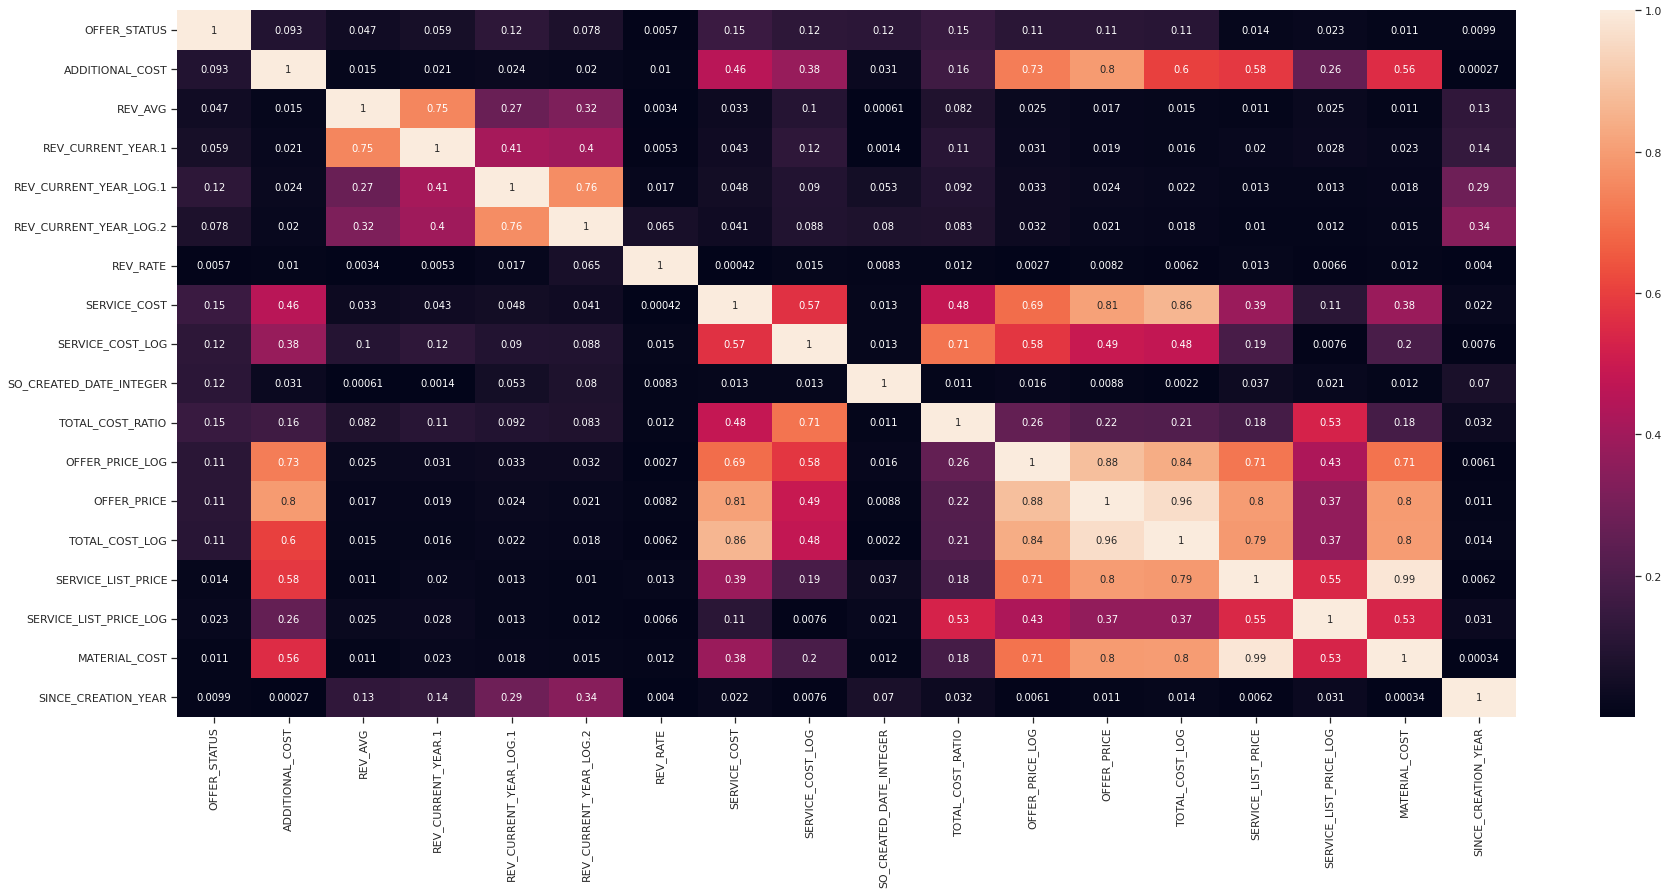

<IPython.core.display.Javascript object>

In [960]:
f, ax = plt.subplots(figsize=(30, 13))
sns.heatmap(
    abs(df.corr()),
    annot=True,
)
plt.show()

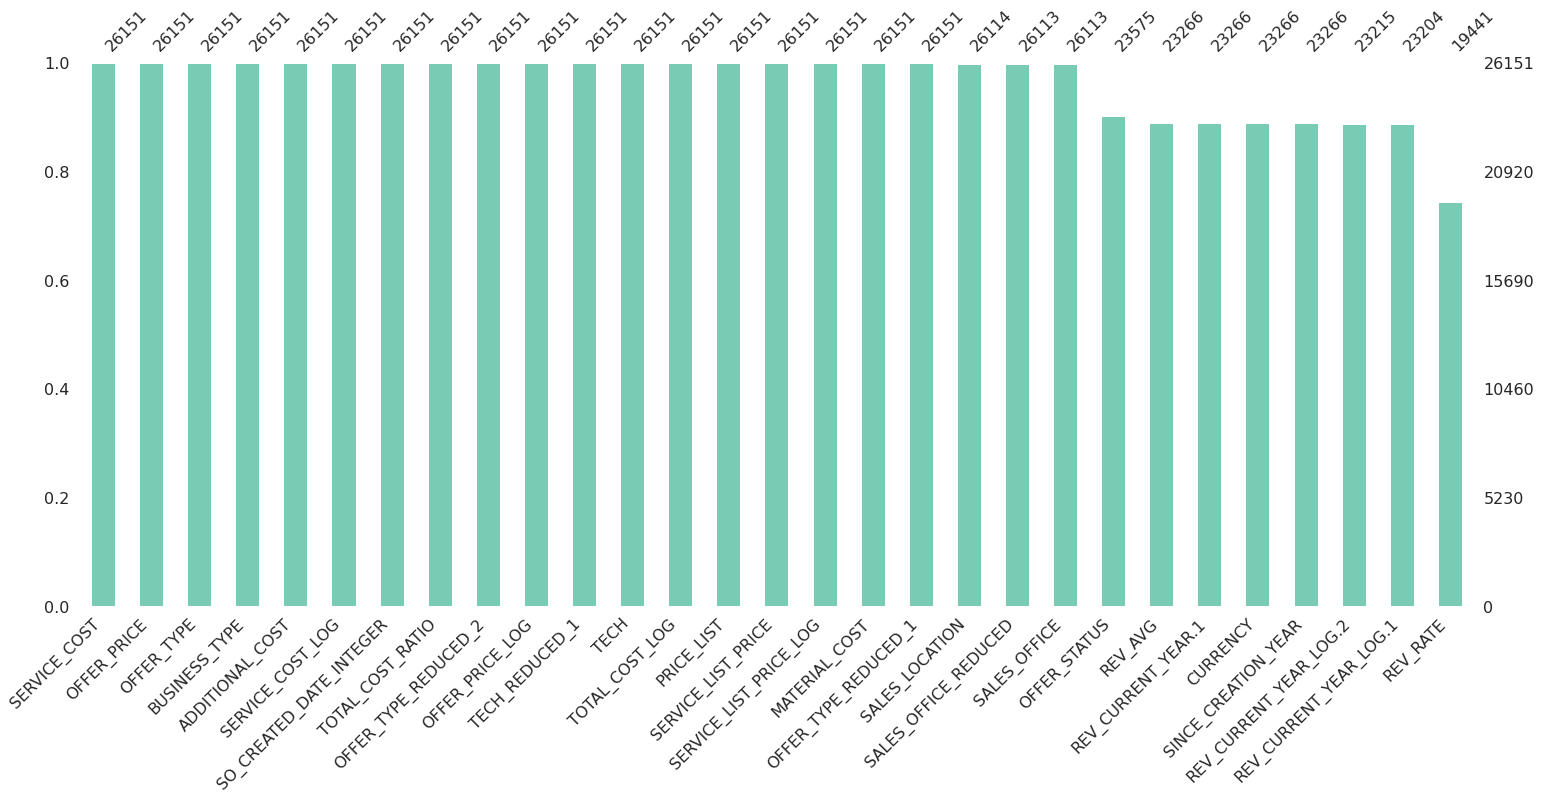

<IPython.core.display.Javascript object>

In [961]:
msno.bar(df, color="#79ccb3", sort="descending")
plt.show()

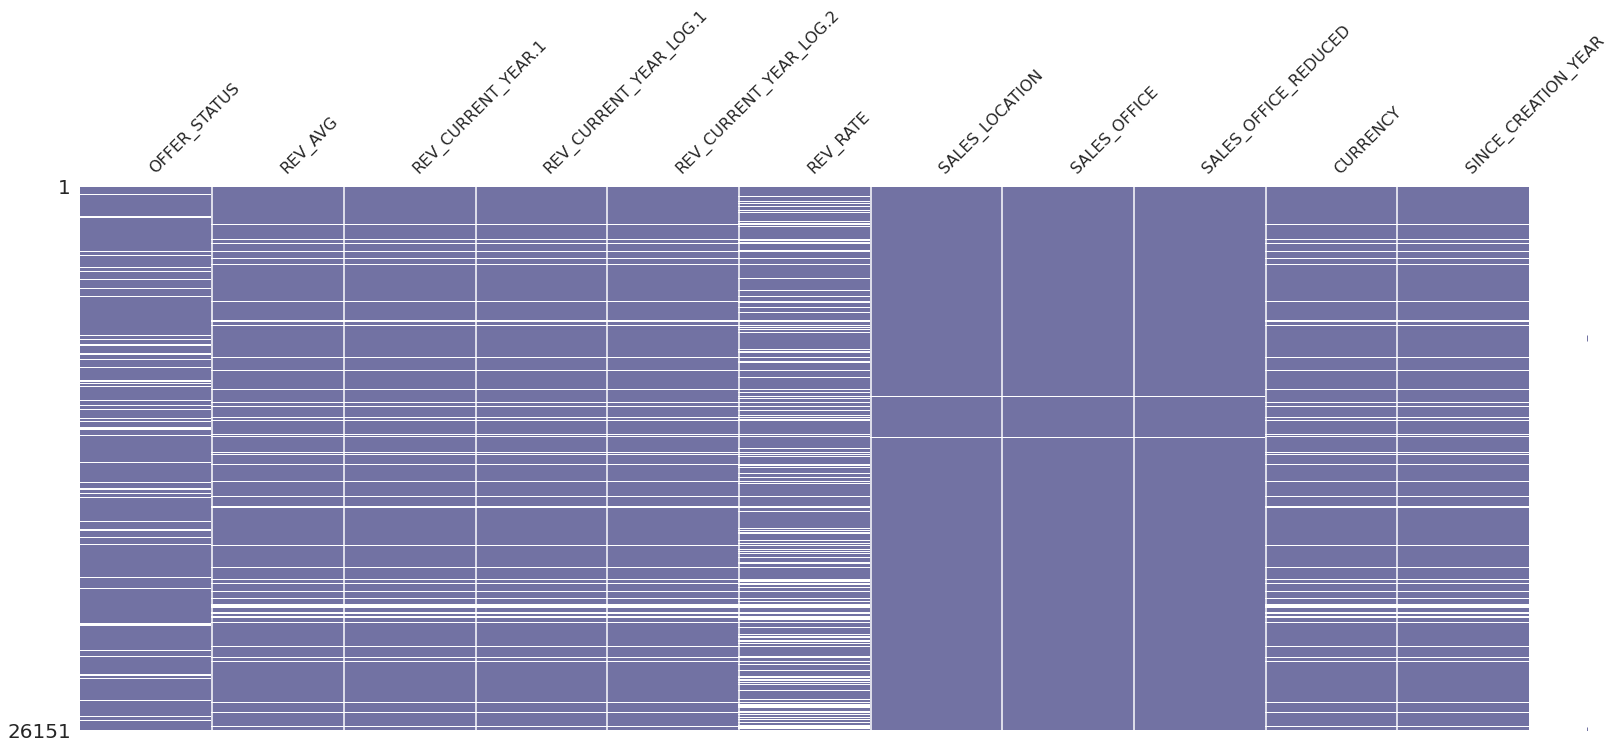

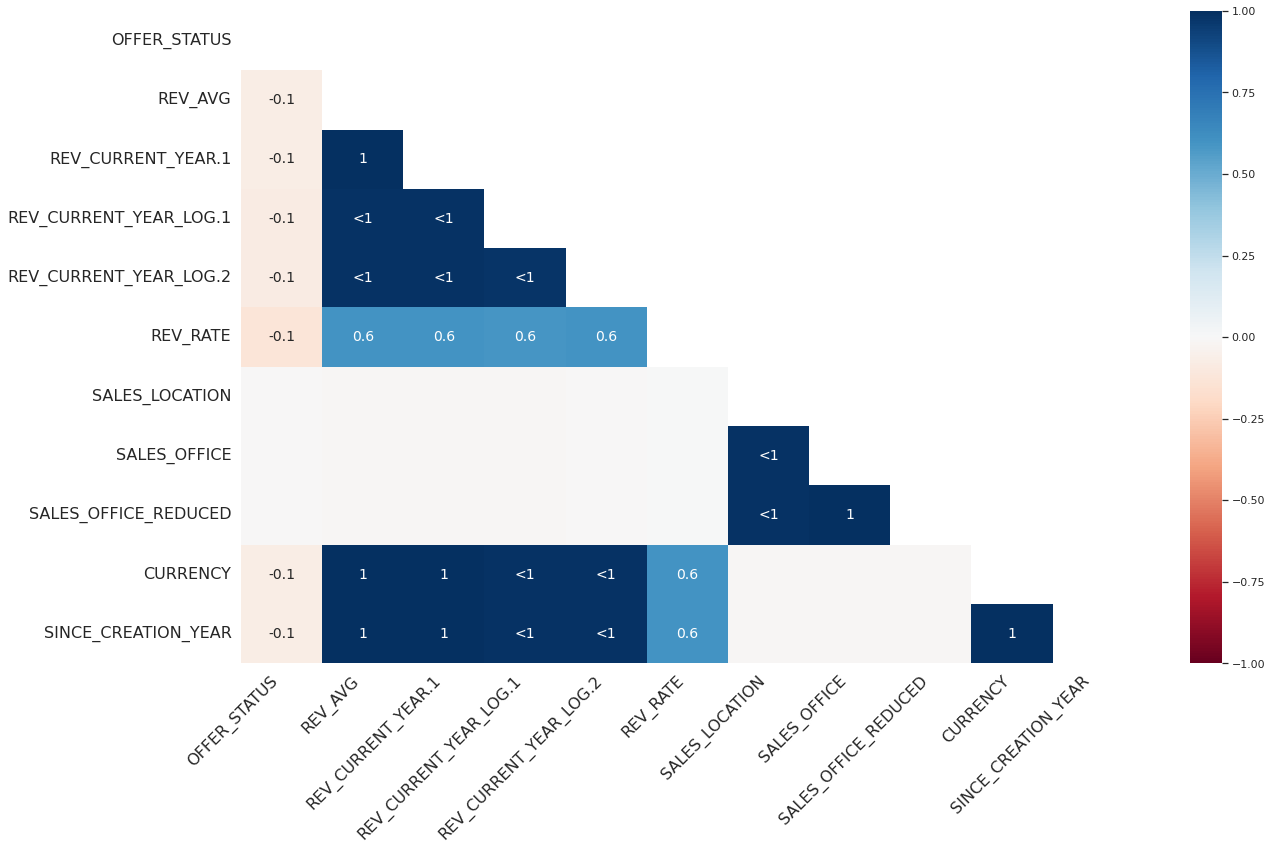

<IPython.core.display.Javascript object>

In [962]:
msno.matrix(
    df[get_null_columns(df)],
    color=(0.45, 0.45, 0.64),
    figsize=(27, 10),
    width_ratios=(10, 0),
)
plt.show()

# msno.dendrogram(df[get_null_columns(df)])

msno.heatmap(df[get_null_columns(df)])
plt.show()

In [963]:
col_to_type = [
    ######################### Nominal
    ("BUSINESS_TYPE", "Nominal"),
    ("CURRENCY", "Nominal"),
    ("HAS_COSTS_PRODUCT_A", "Nominal"),
    ("HAS_COSTS_PRODUCT_B", "Nominal"),
    ("HAS_COSTS_PRODUCT_C", "Nominal"),
    ("HAS_COSTS_PRODUCT_D", "Nominal"),
    ("HAS_COSTS_PRODUCT_E", "Nominal"),
    ("HAS_END_CUSTOMER", "Nominal"),
    ("HAS_ISIC", "Nominal"),
    ("IS_COUNTRY_CODE_CH", "Nominal"),
    ("IS_NA_CURRENCY", "Nominal"),
    ("IS_NA_OWNERSHIP_NO_INFO_AS_NA", "Nominal"),
    ("IS_NA_REV_CURRENT_YEAR", "Nominal"),
    ("IS_NA_REV_AVG", "Nominal"),
    ("IS_NA_REV_RATE", "Nominal"),
    ("IS_NA_SALES_OFFICE", "Nominal"),
    ("IS_NA_SALES_LOCATION", "Nominal"),
    ("OFFER_STATUS", "Nominal"),
    ("OFFER_TYPE", "Nominal"),
    ("OFFER_TYPE_REDUCED_1", "Nominal"),
    ("OFFER_TYPE_REDUCED_2", "Nominal"),
    ("OWNERSHIP", "Nominal"),
    ("OWNERSHIP_NA_AS_NO_INFO", "Nominal"),
    ("OWNERSHIP_NA_AS_NO_INFO_REDUCED", "Nominal"),
    ("OWNERSHIP_NO_INFO_AS_NA", "Nominal"),
    ("OWNERSHIP_NO_INFO_AS_NA_REDUCED", "Nominal"),
    ("OWNERSHIP_REDUCED", "Nominal"),
    ("PRICE_LIST", "Nominal"),
    ("SALES_LOCATION", "Nominal"),
    ("SALES_OFFICE", "Nominal"),
    ("SALES_OFFICE_REDUCED", "Nominal"),
    ("TECH", "Nominal"),
    ("TECH_REDUCED_1", "Nominal"),
    ("TECH_REDUCED_2_IS_F", "Nominal"),
    ("TECH_REDUCED_2_IS_F", "Nominal"),
    ######################### Continuous
    ("CREATION_YEAR", "Continuous"),
    ("CREATION_YEAR_LOG", "Continuous"),
    ("MATERIAL_COST", "Continuous"),
    ("MATERIAL_COST_LOG", "Continuous"),
    ("OFFER_PRICE", "Continuous"),
    ("OFFER_PRICE_LOG", "Continuous"),
    ("REV_AVG", "Continuous"),
    ("REV_CURRENT_YEAR.1", "Continuous"),
    ("REV_CURRENT_YEAR_LOG.1", "Continuous"),
    ("REV_CURRENT_YEAR.2", "Continuous"),
    ("REV_CURRENT_YEAR_LOG.2", "Continuous"),
    ("REV_RATE", "Continuous"),
    ("SERVICE_COST", "Continuous"),
    ("SERVICE_COST_LOG", "Continuous"),
    ("SERVICE_LIST_PRICE", "Continuous"),
    ("SERVICE_LIST_PRICE_LOG", "Continuous"),
    ("SINCE_CREATION_YEAR", "Continuous"),
    ("SINCE_CREATION_YEAR_LOG", "Continuous"),
    ("SO_CREATED_DATE_INTEGER", "Continuous"),
    ("SO_CREATED_DATE_SCALED", "Continuous"),
    ("TOTAL_COST", "Continuous"),
    ("TOTAL_COST_LOG", "Continuous"),
    ("TOTAL_COST_RATIO", "Continuous"),
    ("TOTAL_COSTS_PRODUCT", "Continuous"),
    ("TOTAL_COSTS_PRODUCT_LOG", "Continuous"),
    ("ADDITIONAL_COST", "Continuous"),
]



<IPython.core.display.Javascript object>

In [964]:
x = pd.DataFrame(col_to_type, columns=["Variable", "Variable_Type"])
df_info = df_info.merge(x, on="Variable").set_index("Variable")

<IPython.core.display.Javascript object>

In [965]:
assert not np.any(
    df_info.isna()
), "Some variable types could not be assigned to columns"

<IPython.core.display.Javascript object>

In [966]:
assert len(df_info.index) == df_info.shape[0]  # 1- Row Uniqueness (Drop Duplicates)

# 2- Column Uniqueness (Drop Singletons)
numerical_columns = list(
    df_info.loc[
        (df_info.loc[:, "Variable_Type"] == "Cardinal")
        | (df_info.loc[:, "Variable_Type"] == "Continuous")
    ].index
)
assert len(numerical_columns) > 0

categorical_columns = list(
    df_info.loc[
        (df_info.loc[:, "Variable_Type"] == "Nominal")
        | (df_info.loc[:, "Variable_Type"] == "Ordinal")
    ].index
)
assert len(categorical_columns) > 0

def ZeroVarianceFinder(df, numerical_columns):

    import pandas as pd
    import numpy as np

    zerovariance_numerical_features = []
    for col in numerical_columns:
        try:
            if pd.DataFrame(df[col]).describe().loc["std"][0] == 0.00 or np.isnan(
                pd.DataFrame(df[col]).describe().loc["std"][0]
            ):
                zerovariance_numerical_features.append(col)
        except:
            print("Error:", col)
    return zerovariance_numerical_features


zerovariance_numerical_features = ZeroVarianceFinder(df, numerical_columns)
assert zerovariance_numerical_features == []

singleton_categorical_features = []
for col in categorical_columns:
    if len(df[col].unique()) <= 1:
        singleton_categorical_features.append(col)
        
assert len(singleton_categorical_features) == 0
assert singleton_categorical_features == []


<IPython.core.display.Javascript object>

## Train/Test Split

In [967]:
df_all_processed = df.copy()
df_for_unlabeled_set = df_all_processed[np.isnan(df_all_processed["OFFER_STATUS"])]
df = df[~np.isnan(df["OFFER_STATUS"])]


<IPython.core.display.Javascript object>

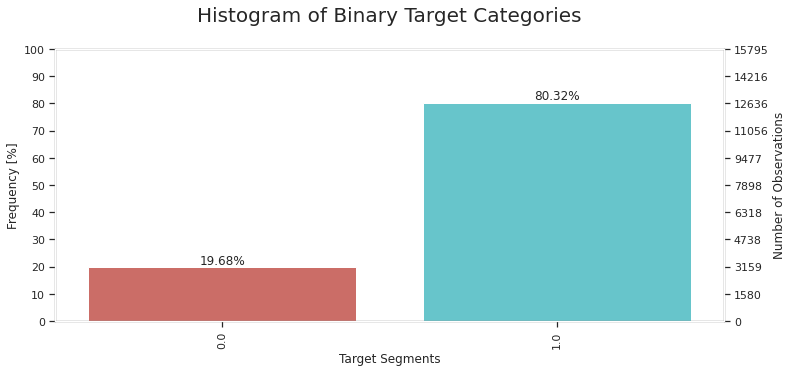

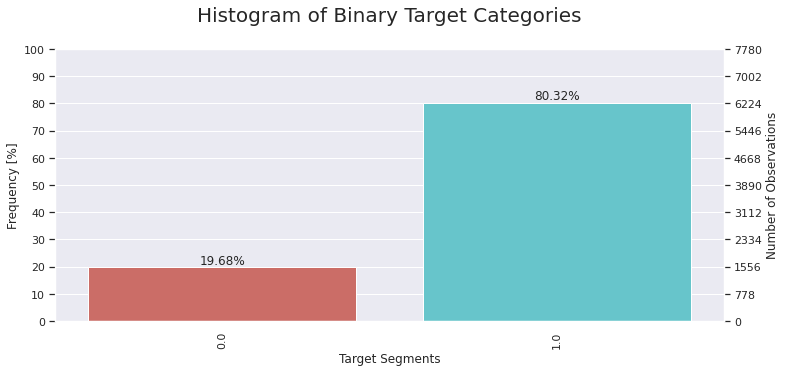

<Figure size 432x288 with 0 Axes>

<IPython.core.display.Javascript object>

In [968]:
training = True  # Make this false when predicting the real test set
if training:
    x = df.drop(["OFFER_STATUS"], axis=1)
    y = df["OFFER_STATUS"]

    X_train, X_test, Y_train, Y_test = train_test_split(
        x, y, test_size=0.33, stratify=y, random_state=42
    )

    histogram(
        X_train, Y_train
    )  #### **Histogram of Binary Target Categories for Train**

    histogram(X_test, Y_test)  #### **Histogram of Binary Target Categories for Test**
else:
    X_train = df.drop(["OFFER_STATUS"], axis=1)
    Y_train = df["OFFER_STATUS"]

    X_test = df_for_unlabeled_set.drop(["OFFER_STATUS"], axis=1)
    Y_test = df_for_unlabeled_set["OFFER_STATUS"]

In [969]:

print('[INFO] Size of df_all_processed:',df_all_processed.shape)
print('[INFO] Size of df_for_unlabeled_set:',df_for_unlabeled_set.shape)
print('[INFO] Size of X_train:',X_train.shape)
print("[INFO] Size of Y_train:", Y_train.shape)
print('[INFO] Size of X_test:',X_test.shape)
print("[INFO] Size of Y_test:", Y_test.shape)


[INFO] Size of df_all_processed: (26151, 29)
[INFO] Size of df_for_unlabeled_set: (2576, 29)
[INFO] Size of X_train: (15795, 28)
[INFO] Size of Y_train: (15795,)
[INFO] Size of X_test: (7780, 28)
[INFO] Size of Y_test: (7780,)


<IPython.core.display.Javascript object>

## Outlier Detection

In [970]:
### Finding sparse columns

sparse_columns = []
for col in numerical_columns:
    if df[col].quantile(0.01) == df[col].quantile(0.25) == df[col].mode()[0]:
        sparse_columns.append(col)

sparse_columns_2 = []
for col in numerical_columns:
    if df[col].quantile(0.01) == df[col].quantile(0.25):
        sparse_columns_2.append(col)
assert sparse_columns == sparse_columns_2

print("Sparse Columns:", sparse_columns)

Sparse Columns: []


<IPython.core.display.Javascript object>

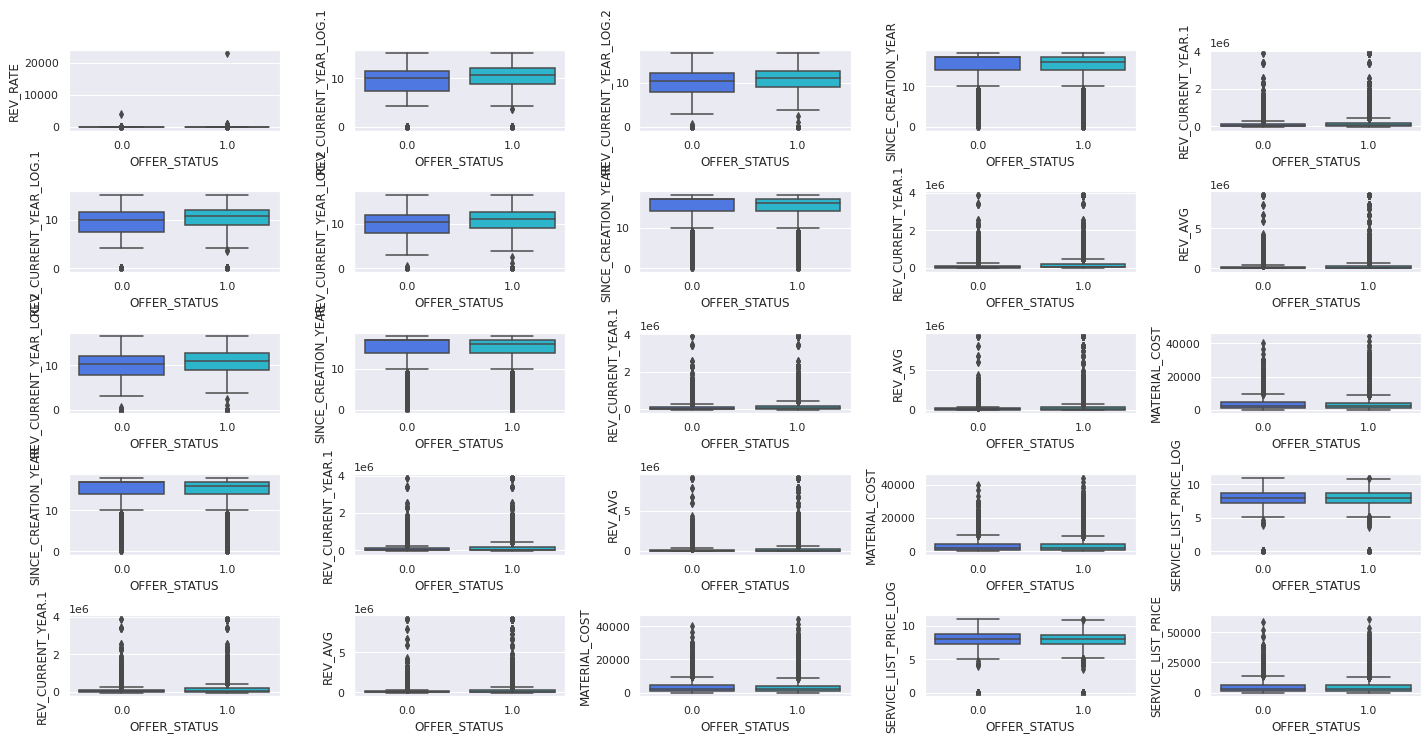

<IPython.core.display.Javascript object>

In [971]:
from pylab import rcParams


def box_plot(x, columns, data):
    matrix_indexes = [(x, y) for x in np.arange(5) for y in np.arange(5)]

    rcParams["figure.figsize"] = 20, 10
    fig, axs = plt.subplots(5, 5)
    plt.tight_layout()
    fig.subplots_adjust(top=0.7)
    sns.set(style="ticks", palette="rainbow")

    for i, j in matrix_indexes:
        sns.boxplot(x=x, y=columns[i + j], data=data, ax=axs[j, i])
    plt.tight_layout()
    plt.show()


box_plot(Y_train, numerical_columns, X_train)

In [972]:
"""
Algorithm 'HER(Hard-Edges Method)' applies induction to the elements of a value line which are:

    - lower than the 1th quantile to that quantile and
    - upper than the 99th quantile to that quantile.
    
Main aim is to diminish negative effects of outlier values on analytical operations being performed.
"""

def HardEdgeReduction(df,numerical_columns,sparse_columns,upper_quantile=0.99,lower_quantile=0.01):
    
    import pandas as pd

    import psutil, os, gc, time
    print("HardEdgeReduction process has began:\n")
    proc = psutil.Process(os.getpid())
    gc.collect()
    mem_0 = proc.memory_info().rss
    start_time = time.time()
    
    # Do outlier cleaning in only one loop
    epsilon = 0.0001 # for zero divisions

    # Define boundaries that we will use for Reduction operation

    df_outlier_cleaned = df.copy()


    print("Detected outliers will be replaced with edged quantiles/percentiles: 1% and 99%!\n")
    print("Total number of rows is: %s\n"%df_outlier_cleaned.shape[0])

    outlier_boundries_dict={}

    for col in numerical_columns:

        if col in sparse_columns:

            # First ignore the 'sparse' data points:
            nonsparse_data = pd.DataFrame(df_outlier_cleaned[df_outlier_cleaned[col] !=\
                                                             df_outlier_cleaned[col].mode()[0]][col]) 
            
            #we used only mode to catch sparse points, since we know/proved it is enough to do that.

            # Find Outlier Thresholds:
            # Note: All columns are right-skewed
            # For lower threshold (left-hand-side)
            if nonsparse_data[col].quantile(lower_quantile) < df_outlier_cleaned[col].mode()[0]: #Unexpected case
                lower_bound_sparse = nonsparse_data[col].quantile(lower_quantile)
            else:
                lower_bound_sparse = df_outlier_cleaned[col].mode()[0]
            
            # For upper threshold (right-hand-side)
            if nonsparse_data[col].quantile(upper_quantile) < df_outlier_cleaned[col].mode()[0]: #Unexpected case
                upper_bound_sparse = df_outlier_cleaned[col].mode()[0]
            else:
                upper_bound_sparse = nonsparse_data[col].quantile(upper_quantile)

            outlier_boundries_dict[col]=(lower_bound_sparse,upper_bound_sparse)

            # Inform user about the cardinality of Outlier existence:
            number_of_outliers = len(df_outlier_cleaned[(df_outlier_cleaned[col] < lower_bound_sparse) |\
                                                        (df_outlier_cleaned[col] > upper_bound_sparse)][col])
            print("Sparse: Outlier number in {} is equal to: ".format(col),round(number_of_outliers/(nonsparse_data.shape[0] -
                                                                                       nonsparse_data.isnull().sum()),2))

            # Replace Outliers with Edges --> 1% and 99%:
            if number_of_outliers > 0:

                # Replace 'left-hand-side' outliers with its 1% quantile value
                df_outlier_cleaned.loc[df_outlier_cleaned[col] < lower_bound_sparse,col] = lower_bound_sparse - epsilon # --> MAIN DF CHANGED

                # Replace 'right-hand-side' outliers with its 99% quantile value
                df_outlier_cleaned.loc[df_outlier_cleaned[col] > upper_bound_sparse,col] = upper_bound_sparse + epsilon # --> MAIN DF CHANGED

        else:
            # Find Edges:
            number_of_outliers = len(df_outlier_cleaned[(df_outlier_cleaned[col] < \
                                                         df_outlier_cleaned[col].quantile(lower_quantile))|\
                                                        (df_outlier_cleaned[col] > \
                                                         df_outlier_cleaned[col].quantile(upper_quantile))]\
                                     [col])
            print("Other: Outlier number in {} is equal to: ".format(col),round(number_of_outliers/(df[col].shape[0] -
                                                                                       df[col].isnull().sum()),2)) 

            # Replace 'Standard' outliers:
            if number_of_outliers > 0:
                # Replace all outliers with its %99 quartile
                lower_bound_sparse = df_outlier_cleaned[col].quantile(lower_quantile)
                df_outlier_cleaned.loc[df_outlier_cleaned[col] < \
                                       lower_bound_sparse,col] \
                = lower_bound_sparse  - epsilon

                upper_bound_sparse = df_outlier_cleaned[col].quantile(upper_quantile)
                df_outlier_cleaned.loc[df_outlier_cleaned[col] > \
                                       upper_bound_sparse,col] \
                = upper_bound_sparse  + epsilon

            outlier_boundries_dict[col]=(lower_bound_sparse,upper_bound_sparse)


    print('HardEdgeReduction process has been completed!')
    print("--- in %s minutes ---" % ((time.time() - start_time)/60))

    return df_outlier_cleaned, outlier_boundries_dict


<IPython.core.display.Javascript object>

In [973]:
X_train, outlier_boundries_dict = HardEdgeReduction(
    X_train, numerical_columns, sparse_columns
)

HardEdgeReduction process has began:

Detected outliers will be replaced with edged quantiles/percentiles: 1% and 99%!

Total number of rows is: 15795

Other: Outlier number in REV_RATE is equal to:  0.02
Other: Outlier number in REV_CURRENT_YEAR_LOG.1 is equal to:  0.0
Other: Outlier number in REV_CURRENT_YEAR_LOG.2 is equal to:  0.01
Other: Outlier number in SINCE_CREATION_YEAR is equal to:  0.0
Other: Outlier number in REV_CURRENT_YEAR.1 is equal to:  0.01
Other: Outlier number in REV_AVG is equal to:  0.01
Other: Outlier number in MATERIAL_COST is equal to:  0.01
Other: Outlier number in SERVICE_LIST_PRICE_LOG is equal to:  0.01
Other: Outlier number in SERVICE_LIST_PRICE is equal to:  0.01
Other: Outlier number in TOTAL_COST_LOG is equal to:  0.02
Other: Outlier number in OFFER_PRICE_LOG is equal to:  0.02
Other: Outlier number in OFFER_PRICE is equal to:  0.02
Other: Outlier number in TOTAL_COST_RATIO is equal to:  0.0
Other: Outlier number in SO_CREATED_DATE_INTEGER is equal to:

<IPython.core.display.Javascript object>

In [974]:
outlier_boundries_dict

{'REV_RATE': (0.0074070924044768, 21.430654962426257),
 'REV_CURRENT_YEAR_LOG.1': (0.0, 14.654343320121846),
 'REV_CURRENT_YEAR_LOG.2': (0.0, 16.423825089416642),
 'SINCE_CREATION_YEAR': (1.0, 18.0),
 'REV_CURRENT_YEAR.1': (0.0, 2313663.8029354257),
 'REV_AVG': (0.0, 7910616.773369983),
 'MATERIAL_COST': (0.0, 22365.31999999999),
 'SERVICE_LIST_PRICE_LOG': (0.0, 10.327989796083276),
 'SERVICE_LIST_PRICE': (0.0, 30575.584999999995),
 'TOTAL_COST_LOG': (601.3646, 37382.6744),
 'OFFER_PRICE_LOG': (6.97914527506881, 10.804712627410469),
 'OFFER_PRICE': (1074.0, 49252.36399999998),
 'TOTAL_COST_RATIO': (1074.0, 49252.36399999998),
 'SO_CREATED_DATE_INTEGER': (1547191600.5, 1623051738.0),
 'SERVICE_COST_LOG': (0.0, 10.152279035274708),
 'ADDITIONAL_COST': (-421.1314000000001, 16253.900999999996),
 'SERVICE_COST': (0.0, 25648.501999999953)}

<IPython.core.display.Javascript object>

##  Cleaning Outliers for Test Dataset




In [975]:
# Do outlier cleaning in only one loop
epsilon = 0.0001  # for zero divisions

# Define boundaries that we will use for Reduction operation
upper_quantile = 0.99
lower_quantile = 0.01

df_test_outlier_cleaned = X_test.copy()

print(
    "Detected outliers will be replaced with edged quantiles/percentiles: 1% and 99%!\n"
)
print("Total number of rows is: %s\n" % df_test_outlier_cleaned.shape[0])

for col in numerical_columns:

    lower_bound = outlier_boundries_dict[col][0]
    upper_bound = outlier_boundries_dict[col][1]

    # Inform user about the cardinality of Outlier existence:
    number_of_outliers = len(
        df_test_outlier_cleaned[
            (df_test_outlier_cleaned[col] < lower_bound)
            | (df_test_outlier_cleaned[col] > upper_bound)
        ][col]
    )
    print(
        "Outlier number in {} is equal to: ".format(col),
        round(
            number_of_outliers
            / (
                df_test_outlier_cleaned[col].shape[0]
                - df_test_outlier_cleaned[col].isnull().sum()
            ),
            2,
        ),
    )

    # Replace Outliers with Edges --> 1% and 99%:
    if number_of_outliers > 0:

        # Replace 'left-hand-side' outliers with its 1% quantile value
        df_test_outlier_cleaned.loc[df_test_outlier_cleaned[col] < lower_bound, col] = (
            lower_bound - epsilon
        )  # --> MAIN DF CHANGED

        # Replace 'right-hand-side' outliers with its 99% quantile value
        df_test_outlier_cleaned.loc[df_test_outlier_cleaned[col] > upper_bound, col] = (
            upper_bound + epsilon
        )  # --> MAIN DF CHANGED

Detected outliers will be replaced with edged quantiles/percentiles: 1% and 99%!

Total number of rows is: 7780

Outlier number in REV_RATE is equal to:  0.02
Outlier number in REV_CURRENT_YEAR_LOG.1 is equal to:  0.0
Outlier number in REV_CURRENT_YEAR_LOG.2 is equal to:  0.01
Outlier number in SINCE_CREATION_YEAR is equal to:  0.0
Outlier number in REV_CURRENT_YEAR.1 is equal to:  0.01
Outlier number in REV_AVG is equal to:  0.01
Outlier number in MATERIAL_COST is equal to:  0.01
Outlier number in SERVICE_LIST_PRICE_LOG is equal to:  0.01
Outlier number in SERVICE_LIST_PRICE is equal to:  0.01
Outlier number in TOTAL_COST_LOG is equal to:  0.02
Outlier number in OFFER_PRICE_LOG is equal to:  0.02
Outlier number in OFFER_PRICE is equal to:  0.02
Outlier number in TOTAL_COST_RATIO is equal to:  1.0
Outlier number in SO_CREATED_DATE_INTEGER is equal to:  0.02
Outlier number in SERVICE_COST_LOG is equal to:  0.01
Outlier number in ADDITIONAL_COST is equal to:  0.02
Outlier number in SERVI

<IPython.core.display.Javascript object>

In [976]:
X_test = df_test_outlier_cleaned

<IPython.core.display.Javascript object>

## Visualization After Cleaning Outlier


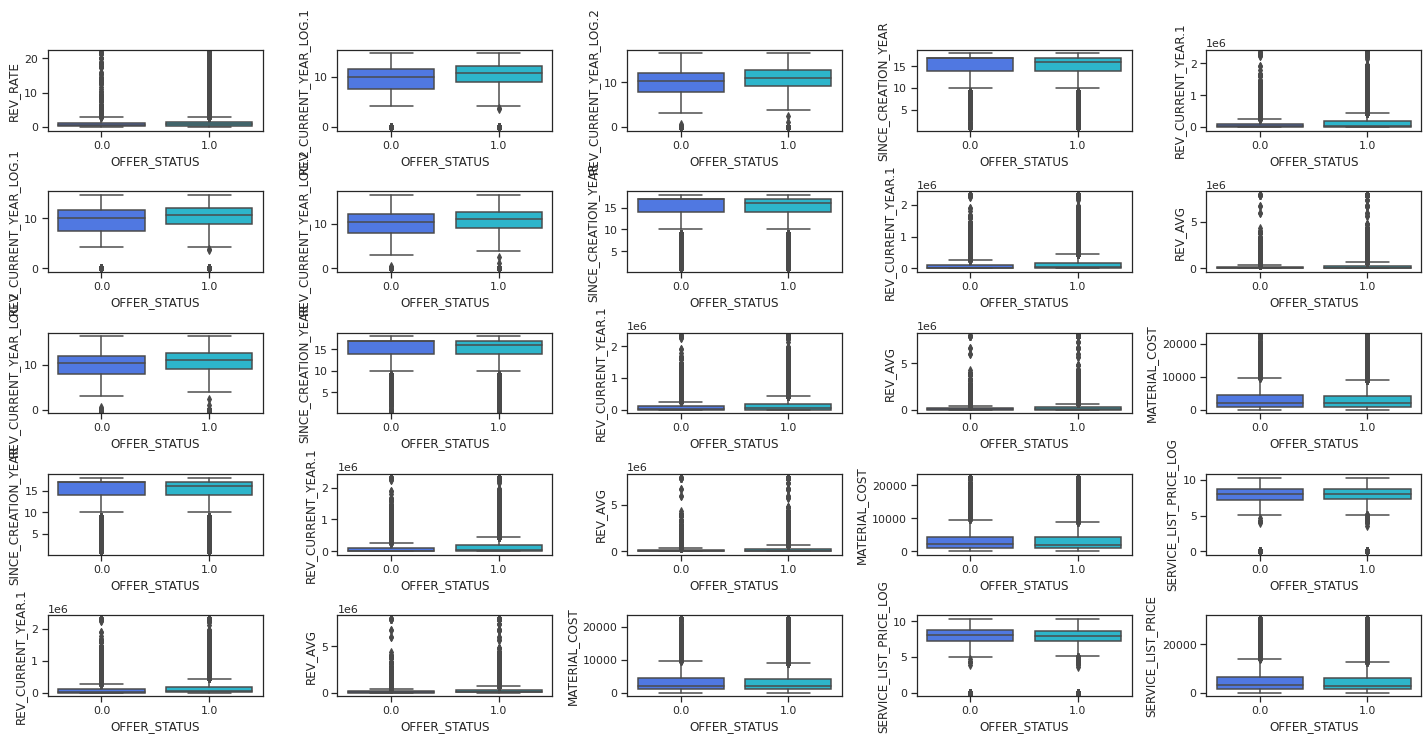

<IPython.core.display.Javascript object>

In [977]:
box_plot(Y_train, numerical_columns, X_train)

## Imputation for Missing Values

In [978]:
Zero_MR_variables_list = list(df_info[df_info["%_Missing_Value"] == 0].index)
Low_MR_variables_list = list(
    df_info[
        (df_info["%_Missing_Value"] > 0) & (df_info["%_Missing_Value"] <= 0.05)
    ].index
)
Moderate_MR_variables_list = list(
    df_info[
        (df_info["%_Missing_Value"] > 0.05) & (df_info["%_Missing_Value"] <= 0.275)
    ].index
)
High_MR_variables_list = list(
    df_info[
        (df_info["%_Missing_Value"] > 0.275) & (df_info["%_Missing_Value"] <= 0.50)
    ].index
)
Extreme_MR_variables_list = list(
    df_info[
        (df_info["%_Missing_Value"] > 0.50) & (df_info["%_Missing_Value"] <= 0.95)
    ].index
)
Drop_MR_variables_list = list(df_info[df_info["%_Missing_Value"] > 0.95].index)


print("[INFO] Number of Zero_MR_variables_list:", len(Zero_MR_variables_list))
print("[INFO] Number of Low_MR_variables_list:", len(Low_MR_variables_list))
print("[INFO] Number of Moderate_MR_variables_list:", len(Moderate_MR_variables_list))
print("[INFO] Number of High_MR_variables_list:", len(High_MR_variables_list))
print("[INFO] Number of Extreme_MR_variables_list:", len(Extreme_MR_variables_list))


assert len(Zero_MR_variables_list) + len(Low_MR_variables_list) + len(
    Moderate_MR_variables_list
) + len(High_MR_variables_list) + len(Extreme_MR_variables_list) == len(df_info)

[INFO] Number of Zero_MR_variables_list: 18
[INFO] Number of Low_MR_variables_list: 3
[INFO] Number of Moderate_MR_variables_list: 8
[INFO] Number of High_MR_variables_list: 0
[INFO] Number of Extreme_MR_variables_list: 0


<IPython.core.display.Javascript object>

In [979]:
# Simple Imputer for Low Missing Values


def SimpleImputer(df, data_info, variable_list):
    for col in variable_list:

        if col in numerical_columns:

            print("Total null values: {}".format(df[[str(col)]].isnull().sum()))

            average = float(df[col].mean())
            std = float(df[col].std())
            count_nan = int(df[col].isnull().sum())
            rand = np.random.normal(loc=average, scale=std, size=count_nan)
            slice_col = pd.Series(df[col].copy())
            slice_col[pd.isnull(slice_col)] = rand
            df[col] = slice_col

            print("Numerical variable {} have been imputed.".format(col))

        else:

            print("Total null values: {}".format(df[[str(col)]].isnull().sum()))
            df.loc[df.loc[:, col].isnull(), col] = np.random.choice(
                sorted(list(df.loc[:, col].dropna().unique())),
                size=int(df.loc[df.loc[:, col].isnull(), col].shape[0]),
                p=[
                    pd.Series(
                        df.groupby(col).size() / df.loc[:, col].dropna().shape[0]
                    ).iloc[i]
                    for i in np.arange(0, len(df.loc[:, col].dropna().unique()))
                ],
            )

            print("Categorical variable {} have been imputed.".format(col))




<IPython.core.display.Javascript object>

In [980]:
print(Low_MR_variables_list)

SimpleImputer(X_train, df_info, Low_MR_variables_list)

['SALES_OFFICE', 'SALES_OFFICE_REDUCED', 'SALES_LOCATION']
Total null values: SALES_OFFICE    25
dtype: int64
Categorical variable SALES_OFFICE have been imputed.
Total null values: SALES_OFFICE_REDUCED    25
dtype: int64
Categorical variable SALES_OFFICE_REDUCED have been imputed.
Total null values: SALES_LOCATION    25
dtype: int64
Categorical variable SALES_LOCATION have been imputed.


<IPython.core.display.Javascript object>

In [981]:
SimpleImputer(X_test, df_info, Low_MR_variables_list)

Total null values: SALES_OFFICE    11
dtype: int64
Categorical variable SALES_OFFICE have been imputed.
Total null values: SALES_OFFICE_REDUCED    11
dtype: int64
Categorical variable SALES_OFFICE_REDUCED have been imputed.
Total null values: SALES_LOCATION    10
dtype: int64
Categorical variable SALES_LOCATION have been imputed.


<IPython.core.display.Javascript object>

In [982]:
MissingUniqueStatistics(X_train.loc[:, Low_MR_variables_list])

,#_Total_Entry,#_Missing_Value,%_Missing_Value,Data_Type,#_Uniques_Values
Variable,,,,,
SALES_OFFICE,15795,0,0.0,object,38
SALES_OFFICE_REDUCED,15795,0,0.0,object,34
SALES_LOCATION,15795,0,0.0,object,43


<IPython.core.display.Javascript object>

In [983]:
MissingUniqueStatistics(X_test.loc[:, Low_MR_variables_list])

,#_Total_Entry,#_Missing_Value,%_Missing_Value,Data_Type,#_Uniques_Values
Variable,,,,,
SALES_OFFICE,7780,0,0.0,object,37
SALES_OFFICE_REDUCED,7780,0,0.0,object,34
SALES_LOCATION,7780,0,0.0,object,42


<IPython.core.display.Javascript object>

## STRING CONVERSION


### MEAN ENCODING


In [984]:
class KFoldTargetEncoderTrain(base.BaseEstimator,
                               base.TransformerMixin):
    def __init__(self,colnames,targetName,
                  n_fold=5, verbosity=True,
                  discardOriginal_col=False):
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)
        
        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold,
                   shuffle = True, random_state=42)
        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X.loc[X.index[val_ind], col_mean_name] = \
            X_val[self.colnames].map(X_tr.groupby(self.colnames)
                                     [self.targetName].mean())
            X[col_mean_name].fillna(mean_of_target, inplace = True)
        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'\
                  .format(col_mean_name,self.targetName,
                          np.corrcoef(X[self.targetName].values,
                                      encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
        return X
def StringConverterTrain(df,target_name,variable_list):
    for col in variable_list:
        targetc = KFoldTargetEncoderTrain(col,target_name,n_fold=4)
        new_train = targetc.fit_transform(df)
    return new_train


<IPython.core.display.Javascript object>

In [985]:
nominal_variable = list(df_info[df_info["Variable_Type"] == "Nominal"].index)
nominal_lst = [
    item
    for item in Moderate_MR_variables_list
    + High_MR_variables_list
    + Extreme_MR_variables_list
    if item in nominal_variable
]
if "OFFER_STATUS" in nominal_lst:
    nominal_lst.remove("OFFER_STATUS")

nominal_lst

['CURRENCY']

<IPython.core.display.Javascript object>

In [986]:
df_trial = pd.concat([X_train, Y_train], axis=1).copy()
df_output_train = StringConverterTrain(
    df=df_trial, target_name="OFFER_STATUS", variable_list=nominal_lst
)

Correlation between the new feature, CURRENCY_Kfold_Target_Enc and, OFFER_STATUS is 0.05783992015715096.


<IPython.core.display.Javascript object>

In [987]:
for item in nominal_lst:
    print(df_output_train.loc[:, [item + "_Kfold_Target_Enc"]].isnull().sum())

CURRENCY_Kfold_Target_Enc    0
dtype: int64


<IPython.core.display.Javascript object>

In [988]:
for item in nominal_lst:
    X_train[item] = df_output_train[item + "_Kfold_Target_Enc"]

<IPython.core.display.Javascript object>

### Mean Encoding for nominal variables(non missing value)

In [989]:
df_encoding = pd.concat([X_train, Y_train], axis=1).copy()
categorical_non_missing_columns = type_separator(
    df_encoding[get_non_null_columns(df_encoding)]
)["categorical"]

if "OFFER_STATUS" in categorical_non_missing_columns:
    categorical_non_missing_columns.remove("OFFER_STATUS")
print(categorical_non_missing_columns)

df_encoding_train = StringConverterTrain(
    df=df_encoding,
    target_name="OFFER_STATUS",
    variable_list=categorical_non_missing_columns,
)

for item in categorical_non_missing_columns:
    X_train[item] = df_encoding_train[item + "_Kfold_Target_Enc"]

['BUSINESS_TYPE', 'OFFER_TYPE', 'OFFER_TYPE_REDUCED_1', 'OFFER_TYPE_REDUCED_2', 'SALES_LOCATION', 'SALES_OFFICE', 'SALES_OFFICE_REDUCED', 'TECH_REDUCED_1', 'TECH', 'PRICE_LIST']
Correlation between the new feature, BUSINESS_TYPE_Kfold_Target_Enc and, OFFER_STATUS is 0.24891458006238984.
Correlation between the new feature, OFFER_TYPE_Kfold_Target_Enc and, OFFER_STATUS is 0.2566378382565627.
Correlation between the new feature, OFFER_TYPE_REDUCED_1_Kfold_Target_Enc and, OFFER_STATUS is 0.22299953120736812.
Correlation between the new feature, OFFER_TYPE_REDUCED_2_Kfold_Target_Enc and, OFFER_STATUS is 0.21735754122228645.
Correlation between the new feature, SALES_LOCATION_Kfold_Target_Enc and, OFFER_STATUS is 0.19683828076310722.
Correlation between the new feature, SALES_OFFICE_Kfold_Target_Enc and, OFFER_STATUS is 0.19650581545601484.
Correlation between the new feature, SALES_OFFICE_REDUCED_Kfold_Target_Enc and, OFFER_STATUS is 0.1960721214420537.
Correlation between the new feature,

<IPython.core.display.Javascript object>

In [990]:
for item in categorical_non_missing_columns:
    print(df_encoding_train.loc[:, [item + "_Kfold_Target_Enc"]].isnull().sum())

BUSINESS_TYPE_Kfold_Target_Enc    0
dtype: int64
OFFER_TYPE_Kfold_Target_Enc    0
dtype: int64
OFFER_TYPE_REDUCED_1_Kfold_Target_Enc    0
dtype: int64
OFFER_TYPE_REDUCED_2_Kfold_Target_Enc    0
dtype: int64
SALES_LOCATION_Kfold_Target_Enc    0
dtype: int64
SALES_OFFICE_Kfold_Target_Enc    0
dtype: int64
SALES_OFFICE_REDUCED_Kfold_Target_Enc    0
dtype: int64
TECH_REDUCED_1_Kfold_Target_Enc    0
dtype: int64
TECH_Kfold_Target_Enc    0
dtype: int64
PRICE_LIST_Kfold_Target_Enc    0
dtype: int64


<IPython.core.display.Javascript object>

In [991]:
MissingUniqueStatistics(X_train)

,#_Total_Entry,#_Missing_Value,%_Missing_Value,Data_Type,#_Uniques_Values
Variable,,,,,
REV_RATE,11460,4335,0.2745,float64,4438
REV_CURRENT_YEAR_LOG.1,13895,1900,0.1203,float64,5050
REV_CURRENT_YEAR_LOG.2,13907,1888,0.1195,float64,4885
SINCE_CREATION_YEAR,13939,1856,0.1175,float64,20
REV_AVG,13939,1856,0.1175,float64,5426
REV_CURRENT_YEAR.1,13939,1856,0.1175,float64,5051
OFFER_PRICE_LOG,15795,0,0.0000,float64,11799
CURRENCY,15795,0,0.0000,float64,17
MATERIAL_COST,15795,0,0.0000,float64,5146


<IPython.core.display.Javascript object>

# **String Converter for Test Dataset**

In [992]:
df_output_test = X_test.copy()
mean_of_target = df_output_train["OFFER_STATUS"].copy().mean()
target_mean_list = nominal_lst
for col in target_mean_list:
    df_output_test[col] = df_output_test[col].map(
        df_output_train.groupby(col)[col + "_Kfold_Target_Enc"].mean()
    )
    df_output_test[col].fillna(mean_of_target, inplace=True)

<IPython.core.display.Javascript object>

In [993]:
for item in nominal_lst:
    print(df_output_test.loc[:, [item]].isnull().sum())

CURRENCY    0
dtype: int64


<IPython.core.display.Javascript object>

In [994]:
X_test[nominal_lst] = df_output_test[nominal_lst]

<IPython.core.display.Javascript object>

In [995]:
X_test_encoder = X_test.copy()
mean_of_target = df_encoding_train["OFFER_STATUS"].copy().mean()
target_mean_list = categorical_non_missing_columns
for col in target_mean_list:
    X_test_encoder[col + "_Kfold_Target_Enc"] = X_test_encoder[col].map(
        df_encoding_train.groupby(col)[col + "_Kfold_Target_Enc"].mean()
    )
    X_test_encoder[col + "_Kfold_Target_Enc"].fillna(mean_of_target, inplace=True)

<IPython.core.display.Javascript object>

In [996]:
for item in categorical_non_missing_columns:
    X_test[item] = X_test_encoder[item + "_Kfold_Target_Enc"]

MissingUniqueStatistics(X_test[categorical_non_missing_columns])

,#_Total_Entry,#_Missing_Value,%_Missing_Value,Data_Type,#_Uniques_Values
Variable,,,,,
BUSINESS_TYPE,7780,0,0.0,float64,9
OFFER_TYPE,7780,0,0.0,float64,29
OFFER_TYPE_REDUCED_1,7780,0,0.0,float64,18
OFFER_TYPE_REDUCED_2,7780,0,0.0,float64,14
SALES_LOCATION,7780,0,0.0,float64,41
SALES_OFFICE,7780,0,0.0,float64,37
SALES_OFFICE_REDUCED,7780,0,0.0,float64,34
TECH_REDUCED_1,7780,0,0.0,float64,4
TECH,7780,0,0.0,float64,7


<IPython.core.display.Javascript object>

## Modal Based Imputation

In [997]:
def MBI(df, columns, train_or_test, lst_numerical):

    data_binary_encoded = df.copy()
    le = LabelEncoder()

    if columns:
        for col in columns:
            if train_or_test == "test":
                le.fit(X_train[col].copy().astype(str))
                data_binary_encoded[col] = le.transform(df[col].copy().astype(str))
            else:
                data_binary_encoded[col] = le.fit_transform(df[col].copy().astype(str))

    data_scaled = data_binary_encoded.copy()

    for col in numerical_columns:

        scaler = StandardScaler()

        if train_or_test == "test":

            scaler.fit(np.array(X_train.loc[:, col]).reshape(-1, 1))
            data_scaled.loc[:, col] = scaler.transform(
                np.array(data_scaled.loc[:, col]).reshape(-1, 1)
            )

        else:
            data_scaled.loc[:, col] = scaler.fit_transform(
                np.array(data_scaled.loc[:, col]).reshape(-1, 1)
            )

    for col in lst_numerical:

        target_dropped_fullcases = (
            data_scaled.drop(col, axis=1)
            .loc[
                :,
                list(
                    set(Zero_MR_variables_list + Low_MR_variables_list)
                    - set(["CLASS", "KEY", "CLNHGVS"])
                ),
            ]
            .copy()
        )

        target = data_scaled.loc[:, col]
        null_mask = target.isna()
        print(col)

        if col in numerical_columns:

            mlp = MLPRegressor(
                hidden_layer_sizes=(
                    100,
                    10,
                ),
                activation="tanh",
                solver="adam",
                learning_rate="adaptive",
                max_iter=1000,
                learning_rate_init=0.01,
                alpha=0.01,
                early_stopping=False,
            )
        else:
            mlp = MLPClassifier(
                hidden_layer_sizes=(
                    100,
                    10,
                ),
                activation="tanh",
                solver="adam",
                learning_rate="adaptive",
                max_iter=1000,
                learning_rate_init=0.01,
                alpha=0.01,
                early_stopping=False,
            )

        mlp.fit(target_dropped_fullcases[~null_mask], target[~null_mask])
        data_scaled.loc[null_mask, col] = mlp.predict(
            target_dropped_fullcases[null_mask]
        )

    print(data_scaled.loc[:, lst_numerical].isnull().sum())
    return data_scaled

<IPython.core.display.Javascript object>

In [998]:
moderate_numerical_variables = [
    item for item in Moderate_MR_variables_list if item in numerical_columns
]
moderate_numerical_variables

['REV_RATE',
 'REV_CURRENT_YEAR_LOG.1',
 'REV_CURRENT_YEAR_LOG.2',
 'SINCE_CREATION_YEAR',
 'REV_CURRENT_YEAR.1',
 'REV_AVG']

<IPython.core.display.Javascript object>

In [999]:
assert (
    "categorical" not in type_separator(X_train)
    or not type_separator(X_train)["categorical"]
), print("All categorical variables should have encoded, check encodings!")
assert (
    "categorical" not in type_separator(X_test)
    or not type_separator(X_test)["categorical"]
), print("All categorical variables should have encoded, check encodings!")

ValueError: [ERROR] Something wrong with column:TOTAL_COST_RATIO cannot be this case, check conversions!

<IPython.core.display.Javascript object>

In [ ]:
X_train_scaled = MBI(X_train, None, "train", moderate_numerical_variables)

In [ ]:
X_train_scaled

In [ ]:
X_test_scaled = MBI(X_test, None, "test", moderate_numerical_variables)

In [ ]:
X_test_scaled

In [ ]:
MissingUniqueStatistics(X_train_scaled)

In [ ]:
assert get_null_columns(X_train_scaled) == [], print(
    "There are some missing values left!"
)
assert get_null_columns(X_test_scaled) == [], print(
    "There are some missing values left!"
)

# Manual Feature Importance

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train_scaled, Y_train)

features = X_train_scaled.columns
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20, 10))
feat_importances = pd.Series(importances, index=features)
feat_importances.nlargest(len(indices)).plot(kind="bar", color="#79CCB3")

In [ ]:
manual_classifier_try = False
if manual_classifier_try:

    # Creating an empty Dataframe with Scores
    df_accur_roc_score = pd.DataFrame(columns=["Roc_Auc_Score"])

    import matplotlib.pyplot as plt
    from sklearn import metrics
    from sklearn.linear_model import LogisticRegression
    import xgboost as xgb
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from lightgbm import LGBMClassifier
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.experimental import enable_hist_gradient_boosting
    from sklearn.ensemble import HistGradientBoostingClassifier

    ## **LogisticRegression**
    clf = LogisticRegression(random_state=0)
    clf.fit(X_train_scaled, Y_train)
    y_preds = clf.predict_proba(X_test_scaled)
    preds = y_preds[:, 1]
    fpr, tpr, _ = metrics.roc_curve(Y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    df_accur_roc_score.loc["Logistic_regression"] = [auc_score]
    print(
        "[INFO] BAC SCORE",
        metrics.balanced_accuracy_score(Y_test, clf.predict(X_test_scaled)),
    )

    ## **XGBoost Classifier**

    xgb_model = xgb.XGBClassifier(
        n_estimators=150,
        random_state=0,
        learning_rate=0.25,
        eta=0.4,
        booster="gbtree",
        base_score=0.8,
        colsample_bylevel=0.9009229642844634,
        gamma=0.49967765132613584,
        max_depth=6,
        min_child_weight=7,
        reg_lambda=0.27611902459972926,
        subsample=0.9300916052594785,
    )
    xgb_model.fit(X_train_scaled, Y_train)
    y_preds = xgb_model.predict_proba(X_test_scaled)
    preds = y_preds[:, 1]
    fpr, tpr, _ = metrics.roc_curve(Y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    df_accur_roc_score.loc["XGBoost_Classifier"] = [auc_score]
    print(
        "[INFO] xgb_model,BAC SCORE",
        metrics.balanced_accuracy_score(Y_test, xgb_model.predict(X_test_scaled)),
    )

    ## **KNeighbors Classifier**

    knn = KNeighborsClassifier()
    knn.fit(X_train_scaled, Y_train)
    y_preds = knn.predict_proba(X_test_scaled)
    preds = y_preds[:, 1]
    fpr, tpr, _ = metrics.roc_curve(Y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    df_accur_roc_score.loc["KNeighborsClassifier"] = [auc_score]
    print(
        "[INFO] KNeighborsClassifier,BAC SCORE",
        metrics.balanced_accuracy_score(Y_test, knn.predict(X_test_scaled)),
    )

    ## **Decision Tree Classifier**

    reg_dtr = DecisionTreeClassifier(random_state=0)
    reg_dtr.fit(X_train_scaled, Y_train)
    y_preds = reg_dtr.predict_proba(X_test_scaled)
    preds = y_preds[:, 1]
    fpr, tpr, _ = metrics.roc_curve(Y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    df_accur_roc_score.loc["DecisionTreeClassifier"] = [auc_score]
    print(
        "[INFO] DecisionTreeClassifier,BAC SCORE",
        metrics.balanced_accuracy_score(Y_test, reg_dtr.predict(X_test_scaled)),
    )
    ##  **LightGBM Classifier**
    lgbm = LGBMClassifier(
        max_depth=6,
        n_estimators=100,
        random_state=0,
        learning_rate=0.1,
        eta=0.4,
        base_score=0.8,
        colsample_bylevel=0.9009229642844634,
        gamma=0.49967765132613584,
        min_child_weight=9,
        reg_lambda=0.27611902459972926,
        subsample=0.9300916052594785,
        min_samples_split=2,
        # min_samples_leaf=0.1,
    )
    lgbm.fit(X_train_scaled, Y_train)
    y_preds = lgbm.predict_proba(X_test_scaled)
    preds = y_preds[:, 1]
    fpr, tpr, _ = metrics.roc_curve(Y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    df_accur_roc_score.loc["LGBMClassifier"] = [auc_score]
    print(
        "[INFO] BAC SCORE",
        metrics.balanced_accuracy_score(Y_test, lgbm.predict(X_test_scaled)),
    )
    ## Gradient Boosting Classifier
    gradient_boosting_clf = GradientBoostingClassifier(
        n_estimators=100, learning_rate=0.1, max_depth=7, random_state=0
    ).fit(X_train_scaled, Y_train)
    y_preds = gradient_boosting_clf.predict_proba(X_test_scaled)
    preds = y_preds[:, 1]
    fpr, tpr, _ = metrics.roc_curve(Y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    df_accur_roc_score.loc["GradientBoostingClassifier"] = [auc_score]
    print(
        "[INFO] LGBMClassifier,BAC SCORE",
        metrics.balanced_accuracy_score(
            Y_test, gradient_boosting_clf.predict(X_test_scaled)
        ),
    )

    ## **Hist Gradient Boosting Classifier**

    hist_gradient_boosting_clf = HistGradientBoostingClassifier(
        learning_rate=0.25, max_depth=4, random_state=0
    ).fit(X_train_scaled, Y_train)
    y_preds = hist_gradient_boosting_clf.predict_proba(X_test_scaled)
    preds = y_preds[:, 1]
    fpr, tpr, _ = metrics.roc_curve(Y_test, preds)
    auc_score = metrics.auc(fpr, tpr)
    df_accur_roc_score.loc["HistGradientBoostingClassifier"] = [auc_score]
    print(
        "[INFO] HistGradientBoostingClassifier,BAC SCORE",
        metrics.balanced_accuracy_score(
            Y_test, hist_gradient_boosting_clf.predict(X_test_scaled)
        ),
    )

    print(df_accur_roc_score)
    df_accur_roc_score.sort_values(by=["Roc_Auc_Score"], ascending=False).plot(
        kind="bar",
        y="Roc_Auc_Score",
        figsize=(20, 8),
        color="#79ccb3",
        rot=0,
        title="Model outputs by roc score before feature importance",
    )

## Autosklearn

In [ ]:
X_for_boruta = pd.concat([X_train_scaled, X_test_scaled])

In [ ]:
Y_for_boruta = pd.concat([Y_train, Y_test])

In [ ]:
from sklearn.ensemble import RandomForestClassifier


# define random forest classifier
forest = RandomForestClassifier(n_jobs=-1, class_weight="balanced")
forest.fit(X_for_boruta, Y_for_boruta)


from boruta import BorutaPy

# define Boruta feature selection method
feat_selector = BorutaPy(
    forest,
    # n_jobs=-1,
    n_estimators="auto",
    verbose=2,
    random_state=42,
)


feat_selector.fit(
    X_for_boruta.to_numpy(), Y_for_boruta.to_numpy()
)  # find all relevant features
print(feat_selector.support_)  # check selected features
print(feat_selector.ranking_)  # check ranking of features
# check selected features
a = list(
    zip(
        list(feat_selector.ranking_),
        list(feat_selector.support_),
        list(X_for_boruta.columns),
    )
)

[", # ".join(map(str, [f'{x[2]}", # ', x[0], x[1]])) for x in sorted(a)]


In [ ]:
boruta_reduced_columns = [
    "ADDITIONAL_COST",  # , # 1, # True',
    "BUSINESS_TYPE",  # , # 1, # True',
    "OFFER_TYPE",  # , # 1, # True',
    "OFFER_TYPE_REDUCED_1",  # , # 1, # True',
    "OFFER_TYPE_REDUCED_2",  # , # 1, # True',
    "REV_AVG",  # , # 1, # True',
    "REV_CURRENT_YEAR.1",  # , # 1, # True',
    "REV_CURRENT_YEAR_LOG.1",  # , # 1, # True',
    "REV_CURRENT_YEAR_LOG.2",  # , # 1, # True',
    "REV_RATE",  # , # 1, # True',
    "SALES_LOCATION",  # , # 1, # True',
    "SALES_OFFICE",  # , # 1, # True',
    "SALES_OFFICE_REDUCED",  # , # 1, # True',
    "SERVICE_COST",  # , # 1, # True',
    "SERVICE_COST_LOG",  # , # 1, # True',
    "SO_CREATED_DATE_INTEGER",  # , # 1, # True',
    # "SO_CREATED_DATE_SCALED",  # , # 1, # True',
    "TOTAL_COST_RATIO",  # , # 1, # True',
    "OFFER_PRICE_LOG",  # , # 2, # False',
    "OFFER_PRICE",  # , # 3, # False',
    "TECH_REDUCED_1",  # , # 4, # False',
    # "REV_CURRENT_YEAR.2",  # , # 5, # False',
    # "TOTAL_COST",  # , # 5, # False',
    "TECH",  # , # 7, # False',
    "TOTAL_COST_LOG",  # , # 7, # False',
    "PRICE_LIST",  # , # 9, # False',
    "SERVICE_LIST_PRICE",  # , # 9, # False',
    "SERVICE_LIST_PRICE_LOG",  # , # 11, # False',
    # "MATERIAL_COST_LOG",  # , # 12, # False',
    "MATERIAL_COST",  # , # 13, # False',
    "CURRENCY",  # , # 14, # False',
    "SINCE_CREATION_YEAR",  # , # 15, # False',
    # "CREATION_YEAR",  # , # 16, # False',
    # "CREATION_YEAR_LOG",  # , # 16, # False',
    # "SINCE_CREATION_YEAR_LOG",  # , # 18, # False',
    #########################################################33
    # 'TECH_REDUCED_2_IS_F', # , # 19, # False',
    # 'OWNERSHIP_NA_AS_NO_INFO', # , # 21, # False',
    # 'TOTAL_COSTS_PRODUCT', # , # 21, # False',
    # 'TOTAL_COSTS_PRODUCT_LOG', # , # 21, # False',
    # 'OWNERSHIP_NA_AS_NO_INFO_REDUCED', # , # 23, # False',
    # 'OWNERSHIP', # , # 24, # False',
    # 'OWNERSHIP_REDUCED', # , # 24, # False',
    # 'OWNERSHIP_NO_INFO_AS_NA_REDUCED', # , # 26, # False',
    # 'OWNERSHIP_NO_INFO_AS_NA', # , # 27, # False',
    # 'IS_COUNTRY_CODE_CH', # , # 28, # False',
    # 'HAS_END_CUSTOMER', # , # 29, # False',
    # 'IS_NA_REV_RATE', # , # 30, # False',
    # 'IS_NA_REV_AVG', # , # 31, # False',
    # 'HAS_COSTS_PRODUCT_D', # , # 32, # False',
    # 'HAS_COSTS_PRODUCT_B', # , # 33, # False',
    # 'IS_NA_REV_CURRENT_YEAR', # , # 33, # False',
    # 'IS_NA_CURRENCY', # , # 35, # False',
    # 'IS_NA_OWNERSHIP_NO_INFO_AS_NA', # , # 35, # False',
    # 'HAS_ISIC', # , # 37, # False',
    # 'HAS_COSTS_PRODUCT_A', # , # 38, # False',
    # 'HAS_COSTS_PRODUCT_E', # , # 39, # False',
    # 'HAS_COSTS_PRODUCT_C', # , # 40, # False',
    # 'IS_NA_SALES_OFFICE', # , # 41, # False',
    # 'IS_NA_SALES_LOCATION', # , # 42, # False'
]

In [ ]:
# MODELL
x_train_data = X_train_scaled[boruta_reduced_columns].copy()
x_test_data = X_test_scaled[boruta_reduced_columns].copy()

model2 = AutoSklearnClassifier(
    time_left_for_this_task=2 * 60,
    # time_left_for_this_task=60,
    seed=42,
    per_run_time_limit=30,
    n_jobs=-1,
    metric=autosklearn.metrics.balanced_accuracy,
    memory_limit=10 * 3072,
    # resampling_strategy="cv",
    # resampling_strategy_arguments={"cv": {"folds": 5}, "shuffle": True},
    # resampling_strategy_arguments={"cv": {"folds": 10}, "shuffle": True},
    # resampling_strategy_arguments={"train_size": 0.67, "shuffle": True},
)

start = time.time()
model2.fit(x_train_data, Y_train)
end = time.time()
y_hat = model2.predict(x_test_data)
# print(model2.sprint_statistics())
# print(model2.best_val_acc)
best_val_score_here = float(model2.sprint_statistics().split("\n")[3][25:])
print(model2.get_models_with_weights())
# model2.leaderboard()


# Evaluate

print("Elapsed Time:", end - start)
# print("Dropped until:", col)
print("Best Val Score:", best_val_score_here)
val_acc = balanced_accuracy_score(y_true=Y_test, y_pred=y_hat)
print("Final BAC Score: %.3f" % val_acc)

# Pickle
if not (("best_val_acc" in vars() or "best_val_acc" in globals())):
    best_val_acc = val_acc
file_name = f"model_pickles/model_{int(val_acc*10**3)}" + str(
    datetime.datetime.now()
).replace(" ", "_")
if val_acc >= best_val_acc:
    with open(file_name, "wb") as f:
        pickle.dump(model2, f)
else:
    with open(file_name, "wb") as f:
        pickle.dump(model2, f)

In [ ]:
predict_final = True
if predict_final:
    df_tmp = pd.read_csv("interim_data/df_completed_1_2_3_with_mv_new.csv")
    test_set_id_col = df_tmp[np.isnan(df_tmp["OFFER_STATUS"])]["TEST_SET_ID"]

    ## Predict BREAK - start
    real_test = x_test_data
    real_test["prediction"] = model2.predict(real_test)
    real_test = pd.concat([real_test["prediction"], test_set_id_col], axis=1)
    real_test = real_test.rename(columns={"TEST_SET_ID": "id"})
    real_test["prediction"] = real_test["prediction"].astype(int)
    real_test["id"] = real_test["id"].astype(int)

    ## Predict BREAK - stop

    #real_test.to_csv("predictions_versed_chimpanzee_5.csv", header=True, index=False)
    print(real_test[["prediction"]].value_counts())

In [ ]:
Best Val Score: 0.713349
Final BAC Score: 0.704

## First BAC SCORES

In [ ]:
print(
    "[INFO] BAC SCORE",
    metrics.balanced_accuracy_score(Y_test, clf.predict(X_test_scaled)),
)

print(
    "[INFO] BAC SCORE",
    metrics.balanced_accuracy_score(Y_test, xgb_model.predict(X_test_scaled)),
)

print(
    "[INFO] BAC SCORE",
    metrics.balanced_accuracy_score(Y_test, knn.predict(X_test_scaled)),
)

print(
    "[INFO] BAC SCORE",
    metrics.balanced_accuracy_score(Y_test, reg_dtr.predict(X_test_scaled)),
)

print(
    "[INFO] BAC SCORE",
    metrics.balanced_accuracy_score(Y_test, lgbm.predict(X_test_scaled)),
)

print(
    "[INFO] BAC SCORE",
    metrics.balanced_accuracy_score(
        Y_test, gradient_boosting_clf.predict(X_test_scaled)
    ),
)

print(
    "[INFO] BAC SCORE",
    metrics.balanced_accuracy_score(
        Y_test, hist_gradient_boosting_clf.predict(X_test_scaled)
    ),
)

In [ ]:
Y_test.value_counts()

In [ ]:
pd.concat([X_train_scaled, Y_train], axis=1).to_csv(
    "train_for_h2o.csv", index=False, header=True
)
pd.concat([X_test_scaled, Y_test], axis=1).to_csv(
    "test_for_h2o.csv", index=False, header=True
)



In [ ]:

pd.concat([X_train, Y_train], axis=1).to_csv(
    "train_for_h2o_2.csv", index=False, header=True
)
pd.concat([X_test, Y_test], axis=1).to_csv(
    "test_for_h2o_2.csv", index=False, header=True
)


In [ ]:
train = h2o.import_file("train_for_h2o_2.csv")
test = h2o.import_file("test_for_h2o_2.csv")

import pandas as pd
import numpy as np
import h2o

h2o.init(max_mem_size="32G")
from h2o.automl import H2OAutoML


x = train.columns
y = "OFFER_STATUS"
train[y] = train[y].asfactor()
x.remove(y)
aml = H2OAutoML(
    max_models=200,
    balance_classes=True,
    seed=42,
    # max_runtime_secs=120,
    max_runtime_secs=3*60*60,
)
aml.train(x=x, y=y, training_frame=train)
pred = aml.predict(test)
pred = pred[0].as_data_frame().values.flatten()

print('BAC',balanced_accuracy_score(Y_test, pred))
print(aml.leaderboard)


In [ ]:
$

In [ ]:
train = h2o.import_file("train_for_h2o.csv")
test = h2o.import_file("test_for_h2o.csv")

import pandas as pd
import numpy as np
import h2o

h2o.init(max_mem_size="32G")
from h2o.automl import H2OAutoML


x = train.columns
y = "OFFER_STATUS"
train[y] = train[y].asfactor()
x.remove(y)
aml = H2OAutoML(
    max_models=200,
    balance_classes=True,
    seed=42,
    # max_runtime_secs=120,
    max_runtime_secs=3*60*60,
)
aml.train(x=x, y=y, training_frame=train)
pred = aml.predict(test)
pred = pred[0].as_data_frame().values.flatten()

print('BAC',balanced_accuracy_score(Y_test, pred))
print(aml.leaderboard)


In [ ]:
predict_final = True
if predict_final:
    df_tmp = pd.read_csv("interim_data/df_completed_1_2_3_with_mv_new.csv")
    test_set_id_col = df_tmp[np.isnan(df_tmp["OFFER_STATUS"])]["TEST_SET_ID"]

    ## Predict BREAK - start
    real_test = X_real_real_test
    real_test["prediction"] = model2.predict(real_test)
    real_test = pd.concat([real_test["prediction"], test_set_id_col], axis=1)
    real_test = real_test.rename(columns={"TEST_SET_ID": "id"})
    real_test["prediction"] = real_test["prediction"].astype(int)
    real_test["id"] = real_test["id"].astype(int)

    ## Predict BREAK - stop

    #real_test.to_csv("predictions_versed_chimpanzee_5.csv", header=True, index=False)
    print(real_test[["prediction"]].value_counts())

In [ ]:
X_real_real_test = df_for_unlabeled_set.drop(["OFFER_STATUS"], axis=1)
Y_real_real_test = df_for_unlabeled_set["OFFER_STATUS"]


In [ ]:
predict_final = True
if predict_final:
    df_tmp = pd.read_csv("interim_data/df_completed_1_2_3_with_mv_new.csv")
    test_set_id_col = df_tmp[np.isnan(df_tmp["OFFER_STATUS"])]["TEST_SET_ID"]

    ## Predict BREAK - start
    real_test = X_real_real_test

    real_test["prediction"] = aml.predict(h2o.import_file("X_real_real_test.csv"))
    real_test = pd.concat([real_test["prediction"], test_set_id_col], axis=1)
    real_test = real_test.rename(columns={"TEST_SET_ID": "id"})
    real_test["prediction"] = real_test["prediction"].astype(int)
    real_test["id"] = real_test["id"].astype(int)

    ## Predict BREAK - stop

    # real_test.to_csv("predictions_versed_chimpanzee_5.csv", header=True, index=False)
    print(real_test[["prediction"]].value_counts())

## Helper Functions

In [ ]:
def type_separator_old(df: pd.DataFrame, print_results=False):
    dtype_names = ["categorical", "binary", "continuous", "integer", "numerical"]
    set_separator = dict.fromkeys(dtype_names, [])

    dtype_char_to_names = {
        "O": "categorical",
        "i": "integer",
        "u": "integer",
        "f": "continuous",
    }

    for col in df.columns:
        unique_vals = set(df[col].dropna().unique())

        if len(unique_vals) < 2 or (
            df[col].dtype == np.dtype("object") and len(unique_vals) > 500
        ):
            raise ValueError(
                f"[ERROR] Something wrong with column:{col} cannot be this case, check conversions!"
            )

        if unique_vals == {0, 1} or unique_vals == {0.0, 1.0}:
            set_separator["binary"].append(col)
        elif df[col].dtype.str[1] in dtype_char_to_names:
            dtype_char = df[col].dtype.str[1]
            dtype_name = dtype_char_to_names[dtype_char]
            set_separator[dtype_name].append(col)
        else:
            raise ValueError(
                f'[ERROR] Numpy data type:"{df[col].dtype}" of col:"{col}" not understood.'
            )

    set_separator["numerical"] = set_separator["continuous"] + set_separator["integer"]
    set_separator["categorical"] += set_separator["binary"]

    if print_results:
        for key, val in set_separator.items():
            print("type:", key, "columns:")
            for col in sorted(val):
                print(">", col)
            print("-" * 32)
    return set_separator


def type_separator(df: pd.DataFrame, print_results=False):
    dtype_names = ["categorical", "binary", "continuous", "integer", "numerical"]
    type_to_cols = dict.fromkeys(dtype_names, [])

    dtype_char_to_names = {
        "O": "categorical",
        "i": "integer",
        "u": "integer",
        "f": "continuous",
    }

    for col in df.columns:
        unique_vals = set(df[col].dropna().unique())

        if len(unique_vals) < 2 or (
            df[col].dtype == np.dtype("object") and len(unique_vals) > 500
        ):
            raise ValueError(
                f"[ERROR] Something wrong with column:{col} cannot be this case, check conversions!"
            )

        if unique_vals == {0, 1} or unique_vals == {0.0, 1.0}:
            type_to_cols["binary"] = type_to_cols["binary"] + [col]
        elif df[col].dtype.str[1] in dtype_char_to_names:
            dtype_char = df[col].dtype.str[1]
            dtype_name = dtype_char_to_names[dtype_char]
            type_to_cols[dtype_name] = type_to_cols[dtype_name] + [col]
        else:
            raise ValueError(
                f'[ERROR] Numpy data type:"{df[col].dtype}" of col:"{col}" not understood.'
            )

    type_to_cols["numerical"] = type_to_cols["continuous"] + type_to_cols["integer"]
    type_to_cols["nominal"] = type_to_cols["categorical"] + type_to_cols["binary"]
    for dtype_name, col_names in type_to_cols.items():
        assert len(type_to_cols[dtype_name]) == len(
            set(type_to_cols[dtype_name])
        ), f'For type:"{dtype_name}", some columns are duplicate in: {col_names}.'

    if print_results:
        for key, val in type_to_cols.items():
            print("type:", key, "columns:")
            for col in sorted(val):
                print(">", col)
            print("-" * 32)
    return type_to_cols


def get_null_columns(df: pd.DataFrame) -> List:
    return [col for col in df.columns if np.any(df[col].isna())]


def get_non_null_columns(df: pd.DataFrame) -> List:
    return [col for col in df.columns if not np.any(df[col].isna())]


def get_inf_columns(df: pd.DataFrame) -> List:
    return [col for col in df.columns if np.any(df[col] == np.inf)]


def print_nan_and_inf_columns(df: pd.DataFrame):
    print("NaN and Infinity Columns and Counts:")
    for col in sorted(get_null_columns(df)):
        print("> [NaN     ]", col, "Null Count:", np.sum(df[col].isna()))
    for col in sorted(get_inf_columns(df)):
        print("> [INFINITY]", col, "Inf Count:", np.sum(df[col] == np.inf))


def get_labeled_set(df: pd.DataFrame, target_col: str = "OFFER_STATUS"):
    return df[~np.isnan(df[target_col])]


def get_unlabeled_set(df: pd.DataFrame, target_col: str = "OFFER_STATUS"):
    return df[np.isnan(df[target_col])]


def MissingUniqueStatistics(df, show_unique_values=False):

    total_entry_list = []
    total_missing_value_list = []
    missing_value_ratio_list = []
    data_type_list = []
    unique_values_list = []
    number_of_unique_values_list = []
    variable_name_list = []

    for col in df.columns:

        variable_name_list.append(col)
        missing_value_ratio = round((df[col].isna().sum() / len(df[col])), 4)
        total_entry_list.append(df[col].shape[0] - df[col].isna().sum())
        total_missing_value_list.append(df[col].isna().sum())
        missing_value_ratio_list.append(missing_value_ratio)
        data_type_list.append(df[col].dtype)
        unique_values_list.append(list(df[col].unique()))
        number_of_unique_values_list.append(len(df[col].unique()))

    data_info_df = pd.DataFrame(
        {
            "Variable": variable_name_list,
            "#_Total_Entry": total_entry_list,
            "#_Missing_Value": total_missing_value_list,
            "%_Missing_Value": missing_value_ratio_list,
            "Data_Type": data_type_list,
            "Unique_Values": unique_values_list,
            "#_Uniques_Values": number_of_unique_values_list,
        }
    )
    if not show_unique_values:
        data_info_df = data_info_df.drop("Unique_Values", axis=1)

    return data_info_df.sort_values(by="#_Missing_Value", ascending=False).set_index(
        "Variable"
    )


def histogram(df, feature):  # Histogram of the target categories
    %matplotlib inline
    ncount = len(df)
    ax = sns.countplot(x=feature, data=df, palette="hls")
    sns.set(font_scale=1)
    ax.set_xlabel("Target Segments")
    plt.xticks(rotation=90)
    ax.set_ylabel("Number of Observations")
    fig = plt.gcf()
    fig.set_size_inches(12, 5)
    # Make twin axis
    ax2 = ax.twinx()
    # Switch so count axis is on right, frequency on left
    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()
    # Also switch the labels over
    ax.yaxis.set_label_position("right")
    ax2.yaxis.set_label_position("left")
    ax2.set_ylabel("Frequency [%]")
    for p in ax.patches:
        x = p.get_bbox().get_points()[:, 0]
        y = p.get_bbox().get_points()[1, 1]
        ax.annotate(
            "{:.2f}%".format(100.0 * y / ncount),
            (x.mean(), y),
            ha="center",
            va="bottom",
        )  # set the alignment of the text
    # Use a LinearLocator to ensure the correct number of ticks
    ax.yaxis.set_major_locator(ticker.LinearLocator(11))
    # Fix the frequency range to 0-100
    ax2.set_ylim(0, 100)
    ax.set_ylim(0, ncount)
    # And use a MultipleLocator to ensure a tick spacing of 10
    ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))
    # Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
    ax2.grid(None)
    plt.title("Histogram of Binary Target Categories", fontsize=20, y=1.08)
    plt.show()
    plt.savefig("target_histogram.png")
    del ncount, x, y

    # USAGE: histogram(data, "CLASS")

## From Submission 3, With H2O

In [ ]:
def apply_h2o(data, max_runtime_secs=10 * 60, max_models=20, balance_classes=True,
              models_dir_path = './h2o_models_with_data'):
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
    X_train, X_test, y_train, y_test = data
    
    from h2o.automl import H2OAutoML
    import h2o
    
    if not os.path.exists(models_dir_path):
        os.makedirs(models_dir_path)
        
    results_dir_path =f'{models_dir_path}/results_ts_{timestamp}'
    os.makedirs(results_dir_path)
        
    train_path =f"{results_dir_path}/train.csv"
    test_path =f"{results_dir_path}/test.csv"

    pd.concat([X_train, Y_train], axis=1).to_csv(train_path, index=False, header=True)
    pd.concat([X_test, Y_test], axis=1).to_csv(test_path, index=False, header=True)

    train = h2o.import_file(train_path)
    test = h2o.import_file(test_path)

    h2o.init(max_mem_size="36G")

    x = train.columns
    train["OFFER_STATUS"] = train["OFFER_STATUS"].asfactor()
    x.remove("OFFER_STATUS")
    aml = H2OAutoML(
        max_models=max_models,
        balance_classes=balance_classes,
        max_runtime_secs=int(max_runtime_secs),
        seed=42,
    )
    aml.train(x=x, y="OFFER_STATUS", training_frame=train)
    
    print("[INFO] Timestamp:",timestamp)
    print('[INFO] AML Leaderboard',aml.leaderboard)
    
    model_bac_scores = []
    for i in range(int(aml.max_models * 1.5)):
        current_model = aml.leaderboard[i, 0]
        if current_model == "NA":
            print(f"[INFO] Found {i} models in total.")
            break
        current_model = h2o.get_model(current_model)
        new_pred = current_model.predict(test)
        new_pred = new_pred[0].as_data_frame().values.flatten()
        model_bac_score = balanced_accuracy_score(Y_test, new_pred)
        print(f'[INFO] Model #{i}, BAC={model_bac_score}.')
        model_bac_scores.append(model_bac_score)
    
    index_max_bac_score = model_bac_scores.index(max(model_bac_scores))
    
    saved_model_path=f'{results_dir_path}/model_{"bac_%.3f" % model_bac_scores[index_max_bac_score]}'
    h2o.save_model(model=h2o.get_model(aml.leaderboard[index_max_bac_score, 0]), 
                   path=saved_model_path, force=True)
    
    print("[INFO] RESULTS:")
    print(f' > Train data saved to:"{train_path}".')
    print(f' > Test data saved to :"{test_path}".')
    print(f' > H20 Model saved to :"{saved_model_path}".')

    return aml, model_bac_scores


In [ ]:
def code_block(params:dict, verbose=False, calc_feature_importances=False):
    
    ####### Get Parameters - Start ################
    df = pd.read_csv(params['preprocessed_data_path']) # Read Data
    ###############################################
    
    ####### Block Specific Helper Functions #######
    def print_if_verbose(*args, **kwargs):
        if verbose:
            print(*args, **kwargs)
    ###############################################

    ###############################################
    id_columns = ["CUSTOMER", "TEST_SET_ID", "IDX_CUSTOMER"]
    unnecessary_reduced_cols = [
        "OFFER_TYPE_REDUCED_1",
        "OFFER_TYPE_REDUCED_2",
        "SALES_OFFICE_REDUCED",
    ]

    to_be_dropped_cols = id_columns + unnecessary_reduced_cols
    df = df.drop(to_be_dropped_cols, axis=1)

    # new columns
    df["ADDITIONAL_COST"] = df["OFFER_PRICE"] - df["MATERIAL_COST"] - df["SERVICE_COST"]
    df["TOTAL_COST"] = df["MATERIAL_COST"] + df["SERVICE_COST"]

    ###############################################

    assert 'OFFER_STATUS' not in type_separator(df)["categorical"]
    for col in type_separator(df)["categorical"]:
        num_unq = len(df[col].unique())
        trimmed_col = col.strip().replace(" ", "_")
        if num_unq < 5:
            print_if_verbose(f"[INFO] Col:{col},num_of_unq:{num_unq}, applying 1-HOT encoding.")
            onehot_df = pd.get_dummies(df[col])
            onehot_df = onehot_df.add_prefix(trimmed_col + "_1HOTENC_")
            df = pd.concat((df, onehot_df), axis=1)
        elif num_unq >= 5:
            print_if_verbose(f"[INFO] Col:{col},num_of_unq:{num_unq}, applying BINARY encoding.")
            encoder = ce.BinaryEncoder(cols=[col])
            binenc_df = encoder.fit_transform(df[[col]])
            binenc_df.columns = [
                f"{trimmed_col}_BINENC_{i}" for i in range(len(binenc_df.columns))
            ]
            df = pd.concat((df, binenc_df), axis=1)

    for col in type_separator(df)["categorical"]:
        if col != 'OFFER_STATUS':
            df[col] = pd.Categorical(df[col])

    ##########################

    ###### ADDITIONAL < FEATURES - START
    add_less_than_features = True
    print("[WARN] Adding Less Than Features:", add_less_than_features)

    if add_less_than_features:
        raw_num_cols = type_separator(df)["numerical"]
        nonraw_strings_in_cols = ("OFFER_STATUS","IS_NA","HAS_","1HOTENC","BINENC","IS_","_LOG")
        raw_num_cols = [a for a in raw_num_cols if not any( x in a for x in nonraw_strings_in_cols)]

        raw_numeric_cols_combinations = list(itertools.combinations(raw_num_cols, r=2))
        new_less_than_cols = []
        for col1, col2 in raw_numeric_cols_combinations:
            new_col = np.where(
                np.isnan(df[col1]) | np.isnan(df[col2]), np.nan, (df[col1] < df[col2])
            )
            name_of_new_col = col1 + "_<_" + col2

            if (len(np.unique(new_col[~np.isnan(new_col)])) > 1):  # Not all values are 1 or 0
                new_less_than_cols.append(pd.Series(new_col, name=name_of_new_col))
                print_if_verbose(f'[INFO] Added new "less than" column: "{name_of_new_col}".')
            else:
                print_if_verbose(f'[INFO] NOT added "Less Then" column: "{name_of_new_col}".')

        df = pd.concat([df, pd.concat(new_less_than_cols, axis=1)], axis=1)

    ############# DROPPP -START
    drop_cols = [
        ############## Correlation are same or very similar
        "OWNERSHIP_NA_AS_NO_INFO_1HOTENC_Privately Owned/Publicly Traded",
        "OWNERSHIP_NA_AS_NO_INFO_REDUCED_1HOTENC_Privately Owned/Publicly Traded",
        "OWNERSHIP_NO_INFO_AS_NA_1HOTENC_Privately Owned/Publicly Traded",
        "OWNERSHIP_NO_INFO_AS_NA_REDUCED_1HOTENC_Privately Owned/Publicly Traded",
        "OWNERSHIP_NA_AS_NO_INFO_1HOTENC_Individual Person",
        "OWNERSHIP_NA_AS_NO_INFO_1HOTENC_Governmental",
        "OWNERSHIP_NA_AS_NO_INFO_1HOTENC_No information",
        "OWNERSHIP_NO_INFO_AS_NA_REDUCED_1HOTENC_NOT_GIVEN",
        "OWNERSHIP_NO_INFO_AS_NA_1HOTENC_NOT_GIVEN",
        "OWNERSHIP_REDUCED_1HOTENC_NOT_GIVEN",
        "TECH_REDUCED_2_IS_F",
        "TECH_BINENC_0",
        "SINCE_CREATION_YEAR_<_REV_PERCENTAGE_INCREASE_NO_OUTLIER",  # (34, False)
        ############## Experimentally
        "TOTAL_COSTS_PRODUCT_LOG",
        "CURRENCY_BINENC_0",  # (19, False)
        "OWNERSHIP_BINENC_0",  # (20, False)
        "OWNERSHIP_NO_INFO_AS_NA_1HOTENC_Individual Person",  # (21, False)
        "IS_NA_SALES_LOCATION",  # (22, False)
        "IS_NA_SALES_OFFICE",  # (23, False)
        ## From XGB Feature Importance
        "SERVICE_COST_<_CREATION_YEAR",  # 0.0
        "REV_CURRENT_YEAR.1_<_REV_PERCENTAGE_INCREASE",  # 0.0
        "CREATION_YEAR_<_TOTAL_COST",  # 0.0
        "CREATION_YEAR_<_REV_PERCENTAGE_INCREASE",  # 0.0
        "CREATION_YEAR_<_ADDITIONAL_COST",  # 0.0
    ]

    for col in drop_cols:
        if col in list(df.columns):
            print_if_verbose("[INFO] Dropped:", col)
            df = df.drop(col, axis=1)

    if calc_feature_importances:
        def calculate_feature_importances():
            from boruta import BorutaPy
            from sklearn.ensemble import RandomForestClassifier

            df_new = df[~np.isnan(df["OFFER_STATUS"])].copy()
            columns_to_be_dropped = get_null_columns(df_new)
            if "categorical" in type_separator(df_new):
                columns_to_be_dropped += [
                    col for col in type_separator(df_new)["categorical"]
                    if col in df_new.columns
                ]
            columns_to_be_dropped = set(columns_to_be_dropped)
            if "OFFER_STATUS" in columns_to_be_dropped:
                columns_to_be_dropped.remove("OFFER_STATUS")

            df_new = df_new.drop(columns_to_be_dropped, axis=1)
            X, y = df_new.drop("OFFER_STATUS", axis=1), df_new["OFFER_STATUS"]

            forest = RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth=5)
            forest.fit(X, y)
            
            feat_selector = BorutaPy( # define Boruta feature selection method
                forest, n_estimators="auto", verbose=2,
                random_state=42,
            )
            
            feat_selector.fit(X.to_numpy(), y.to_numpy()) # find all relevant features
            feature_importances = list(zip(feat_selector.ranking_,feat_selector.support_,X.columns))
            for item in sorted(feature_importances):
                print(item, ",")
        calculate_feature_importances()

    df_for_test = df[np.isnan(df["OFFER_STATUS"])]
    df = df[~np.isnan(df["OFFER_STATUS"])]
    
    X, y = df.drop("OFFER_STATUS", axis=1), df["OFFER_STATUS"] # Col Selection & Conversion
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
    
    if params['classifer'] == 'h2o':
        return apply_h2o(data=[X_train, X_test, y_train, y_test],max_runtime_secs=params['max_runtime_secs'])


In [ ]:
result = code_block(
    params={
        "max_runtime_secs": 3 * 60,
        "preprocessed_data_path": "interim_data/df_completed_1_2_3_with_mv_new.csv",
        # "preprocessed_data_path": "interim_data/df_completed_1_2_3_with_mv.csv",
        "classifer": "h2o",
    }
)
result

## From Submission 4, With H2O & AutoSklearn

In [1000]:
# def code_block(params:dict, verbose=False, calc_feature_importances=False):
# "max_runtime_secs": 3 * 60,
verbose = False
training_mode = True  # Make this false when predicting the real test set
is_data_analysis_and_visualization_part = False
preprocessed_data_path = "interim_data/df_completed_1_2_3_with_mv_new.csv"
test_size_in_split = 0.33

<IPython.core.display.Javascript object>

In [1001]:
####### Block Specific Helper Functions #######
def print_if_verbose(*args, **kwargs):
    if verbose:
        print(*args, **kwargs)


###############################################

############# Data Postprocessing #############
df = pd.read_csv(preprocessed_data_path).drop(  # Read Data
    ["CUSTOMER", "TEST_SET_ID", "IDX_CUSTOMER"], axis=1
)

# Add some new columns
df["ADDITIONAL_COST"] = df["OFFER_PRICE"] - df["MATERIAL_COST"] - df["SERVICE_COST"]
df["TOTAL_COST"] = df["MATERIAL_COST"] + df["SERVICE_COST"]
df["TOTAL_COST_LOG"] = df["MATERIAL_COST"] + df["SERVICE_COST"]
df["TOTAL_COST_RATIO"] = df["MATERIAL_COST"] / df["TOTAL_COST"]

# HIGH ABSOLUTE CORRELATIONS BETWEEN INDEPENDENT VALUES:
# > abs(Corr)=1.00 with: "SO_CREATED_DATE_SCALED"    <->   "SO_CREATED_DATE_INTEGER"
# > abs(Corr)=1.00 with: "SINCE_CREATION_YEAR"       <->   "CREATION_YEAR_LOG"
# > abs(Corr)=1.00 with: "SINCE_CREATION_YEAR"       <->   "CREATION_YEAR"
# > abs(Corr)=1.00 with: "IS_NA_REV_CURRENT_YEAR"    <->   "IS_NA_CURRENCY"
# > abs(Corr)=1.00 with: "MATERIAL_COST_LOG"         <->   "SERVICE_LIST_PRICE_LOG"
# > abs(Corr)=1.00 with: "TOTAL_COST"                <->   "TOTAL_COST_LOG"
# > abs(Corr)=0.99 with: "TOTAL_COST"                <->   "IS_NA_REV_AVG"
# > abs(Corr)=0.99 with: "SERVICE_LIST_PRICE"        <->   "MATERIAL_COST"
# > abs(Corr)=0.99 with: "REV_AVG"                   <->   "REV_CURRENT_YEAR.2"
# > abs(Corr)=0.99 with: "REV_AVG"                   <->   "REV_CURRENT_YEAR.1"
# > abs(Corr)=0.99 with: "IS_NA_SALES_OFFICE"        <->   "IS_NA_SALES_LOCATION"
# > abs(Corr)=0.99 with: "IS_NA_REV_CURRENT_YEAR"    <->   "IS_NA_OWNERSHIP_NO_INFO_AS_NA"
# > abs(Corr)=0.96 with: "TOTAL_COST"                <->   "OFFER_PRICE"
# > abs(Corr)=0.96 with: "SINCE_CREATION_YEAR_LOG"   <->   "SINCE_CREATION_YEAR"

selected_cols_by_boruta = [
    "OFFER_STATUS",  ################ Target Column
    "ADDITIONAL_COST",  # , # 1, # True',
    "BUSINESS_TYPE",  # , # 1, # True',
    "OFFER_TYPE",  # , # 1, # True',
    "OFFER_TYPE_REDUCED_1",  # , # 1, # True',
    "OFFER_TYPE_REDUCED_2",  # , # 1, # True',
    "REV_AVG",  # , # 1, # True',
    "REV_CURRENT_YEAR.1",  # , # 1, # True',
    "REV_CURRENT_YEAR_LOG.1",  # , # 1, # True',
    "REV_CURRENT_YEAR_LOG.2",  # , # 1, # True',
    "REV_RATE",  # , # 1, # True',
    "SALES_LOCATION",  # , # 1, # True',
    "SALES_OFFICE",  # , # 1, # True',
    "SALES_OFFICE_REDUCED",  # , # 1, # True',
    "SERVICE_COST",  # , # 1, # True',
    "SERVICE_COST_LOG",  # , # 1, # True',
    "SO_CREATED_DATE_INTEGER",  # , # 1, # True',
    # "SO_CREATED_DATE_SCALED",  # , # 1, # True',
    # "TOTAL_COST_RATIO",  # , # 1, # True',
    "OFFER_PRICE_LOG",  # , # 2, # False',
    "OFFER_PRICE",  # , # 3, # False',
    "TECH_REDUCED_1",  # , # 4, # False',
    # "REV_CURRENT_YEAR.2",  # , # 5, # False',
    # "TOTAL_COST",  # , # 5, # False',
    "TECH",  # , # 7, # False',
    "TOTAL_COST_LOG",  # , # 7, # False',
    # "PRICE_LIST",  # , # 9, # False',
    "SERVICE_LIST_PRICE",  # , # 9, # False',
    "SERVICE_LIST_PRICE_LOG",  # , # 11, # False',
    # "MATERIAL_COST_LOG",  # , # 12, # False',
    "MATERIAL_COST",  # , # 13, # False',
    "CURRENCY",  # , # 14, # False',
    # "SINCE_CREATION_YEAR",  # , # 15, # False',
    # "CREATION_YEAR",  # , # 16, # False',
    # "CREATION_YEAR_LOG",  # , # 16, # False',
    # "SINCE_CREATION_YEAR_LOG",  # , # 18, # False',
    # 'TECH_REDUCED_2_IS_F', # , # 19, # False',
    # 'OWNERSHIP_NA_AS_NO_INFO', # , # 21, # False',
    # 'TOTAL_COSTS_PRODUCT', # , # 21, # False',
    # 'TOTAL_COSTS_PRODUCT_LOG', # , # 21, # False',
    # 'OWNERSHIP_NA_AS_NO_INFO_REDUCED', # , # 23, # False',
    # 'OWNERSHIP', # , # 24, # False',
    # 'OWNERSHIP_REDUCED', # , # 24, # False',
    # 'OWNERSHIP_NO_INFO_AS_NA_REDUCED', # , # 26, # False',
    # 'OWNERSHIP_NO_INFO_AS_NA', # , # 27, # False',
    # 'IS_COUNTRY_CODE_CH', # , # 28, # False',
    # 'HAS_END_CUSTOMER', # , # 29, # False',
    # 'IS_NA_REV_RATE', # , # 30, # False',
    # 'IS_NA_REV_AVG', # , # 31, # False',
    # 'HAS_COSTS_PRODUCT_D', # , # 32, # False',
    # 'HAS_COSTS_PRODUCT_B', # , # 33, # False',
    # 'IS_NA_REV_CURRENT_YEAR', # , # 33, # False',
    # 'IS_NA_CURRENCY', # , # 35, # False',
    # 'IS_NA_OWNERSHIP_NO_INFO_AS_NA', # , # 35, # False',
    # 'HAS_ISIC', # , # 37, # False',
    # 'HAS_COSTS_PRODUCT_A', # , # 38, # False',
    # 'HAS_COSTS_PRODUCT_E', # , # 39, # False',
    # 'HAS_COSTS_PRODUCT_C', # , # 40, # False',
    # 'IS_NA_SALES_OFFICE', # , # 41, # False',
    # 'IS_NA_SALES_LOCATION', # , # 42, # False'
]
assert "OFFER_STATUS" in by_boruta_selected_cols
df = df[selected_cols_by_boruta]
###############################################

######## Data Analysis and Visualization ######
if is_data_analysis_and_visualization_part:

    def data_analysis_and_visualization_part():
        print("[INFO] Correlation Matrix:")
        f, ax = plt.subplots(figsize=(30, 13))
        sns.heatmap(abs(df.corr()), annot=True)
        plt.show()

        print("[INFO] Missing Values:")
        msno.bar(df, color="#79ccb3", sort="descending")
        plt.show()

        print("[INFO] Missing Value Correlations - 1:")
        msno.matrix(
            df[get_null_columns(df)],
            color=(0.45, 0.45, 0.64),
            figsize=(27, 10),
            width_ratios=(10, 0),
        )
        plt.show()

        print("[INFO] Missing Value Correlations - 2:")
        msno.dendrogram(df[get_null_columns(df)])
        plt.show()

        print("[INFO] Missing Value Correlations - 3:")
        msno.heatmap(df[get_null_columns(df)])
        plt.show()

    data_analysis_and_visualization_part()
###############################################

######## Outlier Detection #############
print("[INFO] Outlier Detection has begun.")

col_to_type = [
    ######################### Nominal
    ("BUSINESS_TYPE", "Nominal"),
    ("CURRENCY", "Nominal"),
    ("HAS_COSTS_PRODUCT_A", "Nominal"),
    ("HAS_COSTS_PRODUCT_B", "Nominal"),
    ("HAS_COSTS_PRODUCT_C", "Nominal"),
    ("HAS_COSTS_PRODUCT_D", "Nominal"),
    ("HAS_COSTS_PRODUCT_E", "Nominal"),
    ("HAS_END_CUSTOMER", "Nominal"),
    ("HAS_ISIC", "Nominal"),
    ("IS_COUNTRY_CODE_CH", "Nominal"),
    ("IS_NA_CURRENCY", "Nominal"),
    ("IS_NA_OWNERSHIP_NO_INFO_AS_NA", "Nominal"),
    ("IS_NA_REV_CURRENT_YEAR", "Nominal"),
    ("IS_NA_REV_AVG", "Nominal"),
    ("IS_NA_REV_RATE", "Nominal"),
    ("IS_NA_SALES_OFFICE", "Nominal"),
    ("IS_NA_SALES_LOCATION", "Nominal"),
    ("OFFER_STATUS", "Nominal"),
    ("OFFER_TYPE", "Nominal"),
    ("OFFER_TYPE_REDUCED_1", "Nominal"),
    ("OFFER_TYPE_REDUCED_2", "Nominal"),
    ("OWNERSHIP", "Nominal"),
    ("OWNERSHIP_NA_AS_NO_INFO", "Nominal"),
    ("OWNERSHIP_NA_AS_NO_INFO_REDUCED", "Nominal"),
    ("OWNERSHIP_NO_INFO_AS_NA", "Nominal"),
    ("OWNERSHIP_NO_INFO_AS_NA_REDUCED", "Nominal"),
    ("OWNERSHIP_REDUCED", "Nominal"),
    ("PRICE_LIST", "Nominal"),
    ("SALES_LOCATION", "Nominal"),
    ("SALES_OFFICE", "Nominal"),
    ("SALES_OFFICE_REDUCED", "Nominal"),
    ("TECH", "Nominal"),
    ("TECH_REDUCED_1", "Nominal"),
    ("TECH_REDUCED_2_IS_F", "Nominal"),
    ######################### Continuous
    ("CREATION_YEAR", "Continuous"),
    ("CREATION_YEAR_LOG", "Continuous"),
    ("MATERIAL_COST", "Continuous"),
    ("MATERIAL_COST_LOG", "Continuous"),
    ("OFFER_PRICE", "Continuous"),
    ("OFFER_PRICE_LOG", "Continuous"),
    ("REV_AVG", "Continuous"),
    ("REV_CURRENT_YEAR.1", "Continuous"),
    ("REV_CURRENT_YEAR_LOG.1", "Continuous"),
    ("REV_CURRENT_YEAR.2", "Continuous"),
    ("REV_CURRENT_YEAR_LOG.2", "Continuous"),
    ("REV_RATE", "Continuous"),
    ("SERVICE_COST", "Continuous"),
    ("SERVICE_COST_LOG", "Continuous"),
    ("SERVICE_LIST_PRICE", "Continuous"),
    ("SERVICE_LIST_PRICE_LOG", "Continuous"),
    ("SINCE_CREATION_YEAR", "Continuous"),
    ("SINCE_CREATION_YEAR_LOG", "Continuous"),
    ("SO_CREATED_DATE_INTEGER", "Continuous"),
    ("SO_CREATED_DATE_SCALED", "Continuous"),
    ("TOTAL_COST", "Continuous"),
    ("TOTAL_COST_LOG", "Continuous"),
    ("TOTAL_COST_RATIO", "Continuous"),
    ("TOTAL_COSTS_PRODUCT", "Continuous"),
    ("TOTAL_COSTS_PRODUCT_LOG", "Continuous"),
    ("ADDITIONAL_COST", "Continuous"),
]
df_info = MissingUniqueStatistics(df)
df_col_to_type = pd.DataFrame(col_to_type, columns=["Variable", "Variable_Type"])
df_info = df_info.merge(df_col_to_type, on="Variable").set_index("Variable")
print_if_verbose(df_info)

numerical_columns = list(
    df_info.loc[
        (df_info.loc[:, "Variable_Type"] == "Cardinal")
        | (df_info.loc[:, "Variable_Type"] == "Continuous")
    ].index
)
assert len(numerical_columns) > 0

categorical_columns = list(
    df_info.loc[
        (df_info.loc[:, "Variable_Type"] == "Nominal")
        | (df_info.loc[:, "Variable_Type"] == "Ordinal")
    ].index
)
assert len(categorical_columns) > 0


assert len({x[0] for x in col_to_type}) == len(
    [x[0] for x in col_to_type]
), "There are some duplicate columns in col_to_type list!"
assert not np.any(df_info.isna()), "Some variable types are null!"
assert len(df_info.index) == df_info.shape[0], "Some Rows are not unique!"

df_all_processed = df.copy()
df_for_unlabeled_set = df_all_processed[np.isnan(df_all_processed["OFFER_STATUS"])]
df = df_all_processed[~np.isnan(df["OFFER_STATUS"])]

if training_mode:
    x, y = df.drop(["OFFER_STATUS"], axis=1), df["OFFER_STATUS"]
    X_train, X_test, Y_train, Y_test = train_test_split(
        x, y, test_size=test_size_in_split, stratify=y, random_state=42
    )
    if verbose:
        histogram(X_train, Y_train)
        histogram(X_test, Y_test)
else:
    X_train, Y_train = df.drop(["OFFER_STATUS"], axis=1), df["OFFER_STATUS"]

    X_test = df_for_unlabeled_set.drop(["OFFER_STATUS"], axis=1)
    Y_test = df_for_unlabeled_set["OFFER_STATUS"]


print_if_verbose(
    f"df_all_processed:{df_all_processed.shape}",
    f"df_for_unlabeled_set:{df_for_unlabeled_set.shape}",
    f"X_train:{X_train.shape}",
    f"Y_train:{Y_train.shape}",
    f"X_test:{X_test.shape}",
    f"Y_test:{Y_test.shape}",
    sep="\n",
)

[INFO] Outlier Detection has begun.


<IPython.core.display.Javascript object>

In [1002]:
def HardEdgeReduction(
    df, numerical_columns, sparse_columns, upper_quantile=0.99, lower_quantile=0.01
):
    """
    Algorithm 'HER(Hard-Edges Method)' applies induction to the elements of a value line which are:

        - lower than the 1th quantile to that quantile and
        - upper than the 99th quantile to that quantile.

    Main aim is to diminish negative effects of outlier values on analytical operations being performed.
    """

    import pandas as pd
    import psutil, os, gc, time

    print_if_verbose("HardEdgeReduction process has began:\n")
    proc = psutil.Process(os.getpid())
    gc.collect()
    mem_0 = proc.memory_info().rss
    start_time = time.time()

    epsilon = 0.0001  # for zero divisions

    # Define boundaries that we will use for Reduction operation
    df_outlier_cleaned = df.copy()

    print_if_verbose(
        "Detected outliers will be replaced with edged quantiles/percentiles: 1% and 99%!\n"
    )
    print_if_verbose("Total number of rows is: %s\n" % df_outlier_cleaned.shape[0])

    outlier_boundries_dict = {}

    for col in numerical_columns:

        if col in sparse_columns:
            nonsparse_data = pd.DataFrame(
                df_outlier_cleaned[
                    df_outlier_cleaned[col] != df_outlier_cleaned[col].mode()[0]
                ][col]
            )

            if (  # For lower threshold (left-hand-side)
                nonsparse_data[col].quantile(lower_quantile)
                < df_outlier_cleaned[col].mode()[0]
            ):  # Unexpected case
                lower_bound_sparse = nonsparse_data[col].quantile(lower_quantile)
            else:
                lower_bound_sparse = df_outlier_cleaned[col].mode()[0]

            if (  # For upper threshold (right-hand-side)
                nonsparse_data[col].quantile(upper_quantile)
                < df_outlier_cleaned[col].mode()[0]
            ):  # Unexpected case
                upper_bound_sparse = df_outlier_cleaned[col].mode()[0]
            else:
                upper_bound_sparse = nonsparse_data[col].quantile(upper_quantile)

            outlier_boundries_dict[col] = (lower_bound_sparse, upper_bound_sparse)

            # Inform user about the cardinality of Outlier existence:
            number_of_outliers = len(
                df_outlier_cleaned[
                    (df_outlier_cleaned[col] < lower_bound_sparse)
                    | (df_outlier_cleaned[col] > upper_bound_sparse)
                ][col]
            )
            print_if_verbose(
                "Sparse: Outlier number in {} is equal to: ".format(col),
                round(
                    number_of_outliers
                    / (nonsparse_data.shape[0] - nonsparse_data.isnull().sum()),
                    2,
                ),
            )

            # Replace Outliers with Edges --> 1% and 99%:
            if number_of_outliers > 0:

                # Replace 'left-hand-side' outliers with its 1% quantile value
                df_outlier_cleaned.loc[
                    df_outlier_cleaned[col] < lower_bound_sparse, col
                ] = (
                    lower_bound_sparse - epsilon
                )  # --> MAIN DF CHANGED

                # Replace 'right-hand-side' outliers with its 99% quantile value
                df_outlier_cleaned.loc[
                    df_outlier_cleaned[col] > upper_bound_sparse, col
                ] = (
                    upper_bound_sparse + epsilon
                )  # --> MAIN DF CHANGED

        else:  # Find Edges:
            number_of_outliers = len(
                df_outlier_cleaned[
                    (
                        df_outlier_cleaned[col]
                        < df_outlier_cleaned[col].quantile(lower_quantile)
                    )
                    | (
                        df_outlier_cleaned[col]
                        > df_outlier_cleaned[col].quantile(upper_quantile)
                    )
                ][col]
            )
            print_if_verbose(
                "Other: Outlier number in {} is equal to: ".format(col),
                round(
                    number_of_outliers / (df[col].shape[0] - df[col].isnull().sum()), 2
                ),
            )

            # Replace 'Standard' outliers:
            if number_of_outliers > 0:
                # Replace all outliers with its %99 quartile
                lower_bound_sparse = df_outlier_cleaned[col].quantile(lower_quantile)
                df_outlier_cleaned.loc[
                    df_outlier_cleaned[col] < lower_bound_sparse, col
                ] = (lower_bound_sparse - epsilon)

                upper_bound_sparse = df_outlier_cleaned[col].quantile(upper_quantile)
                df_outlier_cleaned.loc[
                    df_outlier_cleaned[col] > upper_bound_sparse, col
                ] = (upper_bound_sparse + epsilon)

            outlier_boundries_dict[col] = (lower_bound_sparse, upper_bound_sparse)

    print_if_verbose("HardEdgeReduction process has been completed!")
    print_if_verbose("--- in %s minutes ---" % ((time.time() - start_time) / 60))

    return df_outlier_cleaned, outlier_boundries_dict


X_train, outlier_boundries_dict = HardEdgeReduction(
    X_train, numerical_columns, sparse_columns
)

print_if_verbose(outlier_boundries_dict)

##  Cleaning Outliers for Test Dataset

epsilon = 0.0001  # for zero divisions

# Define boundaries that we will use for Reduction operation
upper_quantile, lower_quantile = 0.99, 0.01

df_test_outlier_cleaned = X_test.copy()

print_if_verbose(
    "Detected outliers being replaced with edged quantiles/percentiles: 1% and 99%!"
)
print_if_verbose("Total number of rows is: %s\n" % df_test_outlier_cleaned.shape[0])

for col in numerical_columns:
    lower_bound = outlier_boundries_dict[col][0]
    upper_bound = outlier_boundries_dict[col][1]

    # Inform user about the cardinality of Outlier existence:
    number_of_outliers = len(
        df_test_outlier_cleaned[
            (df_test_outlier_cleaned[col] < lower_bound)
            | (df_test_outlier_cleaned[col] > upper_bound)
        ][col]
    )
    print_if_verbose(
        "Outlier number in {} is equal to: ".format(col),
        round(
            number_of_outliers
            / (
                df_test_outlier_cleaned[col].shape[0]
                - df_test_outlier_cleaned[col].isnull().sum()
            ),
            2,
        ),
    )

    # Replace Outliers with Edges --> 1% and 99%:
    if number_of_outliers > 0:
        # Replace 'left-hand-side' outliers with its 1% quantile value
        df_test_outlier_cleaned.loc[df_test_outlier_cleaned[col] < lower_bound, col] = (
            lower_bound - epsilon
        )  # --> MAIN DF CHANGED

        # Replace 'right-hand-side' outliers with its 99% quantile value
        df_test_outlier_cleaned.loc[df_test_outlier_cleaned[col] > upper_bound, col] = (
            upper_bound + epsilon
        )  # --> MAIN DF CHANGED

X_test = df_test_outlier_cleaned

if verbose:
    box_plot(
        Y_train, numerical_columns, X_train
    )  ## Visualization After Cleaning Outlier

print("[INFO] Outlier Detection has been completed.")
###############################################

######## Missing Value Imputation #############
print("[INFO] Missing Value Imputation has begun.")
missing_values_info = df_info["%_Missing_Value"]

Zero_MR_variables_list = list(df_info[missing_values_info == 0].index)
Low_MR_variables_list = list(
    df_info[(missing_values_info > 0) & (missing_values_info <= 0.05)].index
)
Moderate_MR_variables_list = list(
    df_info[(missing_values_info > 0.05) & (missing_values_info <= 0.275)].index
)
High_MR_variables_list = list(
    df_info[(missing_values_info > 0.275) & (missing_values_info <= 0.50)].index
)
Extreme_MR_variables_list = list(
    df_info[(missing_values_info > 0.50) & (missing_values_info <= 0.95)].index
)
Drop_MR_variables_list = list(df_info[missing_values_info > 0.95].index)

print("[INFO] Number of Zero_MR_variables_list:", len(Zero_MR_variables_list))
print("[INFO] Number of Low_MR_variables_list:", len(Low_MR_variables_list))
print("[INFO] Number of Moderate_MR_variables_list:", len(Moderate_MR_variables_list))
print("[INFO] Number of High_MR_variables_list:", len(High_MR_variables_list))
print("[INFO] Number of Extreme_MR_variables_list:", len(Extreme_MR_variables_list))


assert len(Zero_MR_variables_list) + len(Low_MR_variables_list) + len(
    Moderate_MR_variables_list
) + len(High_MR_variables_list) + len(Extreme_MR_variables_list) == len(df_info)

# Simple Imputer for Low Missing Values


def SimpleImputer(df, data_info, variable_list):
    for col in variable_list:

        if col in numerical_columns:

            print_if_verbose(
                "Total null values: {}".format(df[[str(col)]].isnull().sum())
            )

            average = float(df[col].mean())
            std = float(df[col].std())
            count_nan = int(df[col].isnull().sum())
            rand = np.random.normal(loc=average, scale=std, size=count_nan)
            slice_col = pd.Series(df[col].copy())
            slice_col[pd.isnull(slice_col)] = rand
            df[col] = slice_col

            print_if_verbose("Numerical variable {} have been imputed.".format(col))

        else:

            print_if_verbose(
                "Total null values: {}".format(df[[str(col)]].isnull().sum())
            )
            df.loc[df.loc[:, col].isnull(), col] = np.random.choice(
                sorted(list(df.loc[:, col].dropna().unique())),
                size=int(df.loc[df.loc[:, col].isnull(), col].shape[0]),
                p=[
                    pd.Series(
                        df.groupby(col).size() / df.loc[:, col].dropna().shape[0]
                    ).iloc[i]
                    for i in np.arange(0, len(df.loc[:, col].dropna().unique()))
                ],
            )

            print_if_verbose("Categorical variable {} have been imputed.".format(col))


print_if_verbose(Low_MR_variables_list)

SimpleImputer(X_train, df_info, Low_MR_variables_list)
SimpleImputer(X_test, df_info, Low_MR_variables_list)

print_if_verbose(MissingUniqueStatistics(X_train.loc[:, Low_MR_variables_list]))
print_if_verbose(MissingUniqueStatistics(X_test.loc[:, Low_MR_variables_list]))

print("[INFO] Missing Value Imputation has been completed.")
###############################################

[INFO] Outlier Detection has been completed.
[INFO] Missing Value Imputation has begun.
[INFO] Number of Zero_MR_variables_list: 16
[INFO] Number of Low_MR_variables_list: 3
[INFO] Number of Moderate_MR_variables_list: 7
[INFO] Number of High_MR_variables_list: 0
[INFO] Number of Extreme_MR_variables_list: 0
[INFO] Missing Value Imputation has been completed.


<IPython.core.display.Javascript object>

In [1003]:
######## Categorical Value Encodings #########
### MEAN ENCODING

class KFoldTargetEncoderTrain(base.BaseEstimator,
                               base.TransformerMixin):
    def __init__(self,colnames,targetName,
                  n_fold=5, verbosity=True,
                  discardOriginal_col=False):
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
    
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)
        
        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold,
                   shuffle = True, random_state=42)
        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X.loc[X.index[val_ind], col_mean_name] = \
            X_val[self.colnames].map(X_tr.groupby(self.colnames)
                                     [self.targetName].mean())
            X[col_mean_name].fillna(mean_of_target, inplace = True)
        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print_if_verbose('Correlation between the new feature, {} and, {} is {}.'\
                  .format(col_mean_name,self.targetName,
                          np.corrcoef(X[self.targetName].values,
                                      encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
        return X
def StringConverterTrain(df,target_name,variable_list):
    for col in variable_list:
        targetc = KFoldTargetEncoderTrain(col,target_name,n_fold=4)
        new_train = targetc.fit_transform(df)
    return new_train


nominal_variable = list(df_info[df_info["Variable_Type"] == "Nominal"].index)
nominal_lst = [
    item
    for item in Moderate_MR_variables_list
    + High_MR_variables_list
    + Extreme_MR_variables_list
    if item in nominal_variable
]
if "OFFER_STATUS" in nominal_lst:
    nominal_lst.remove("OFFER_STATUS")

nominal_lst

df_trial = pd.concat([X_train, Y_train], axis=1).copy()
df_output_train = StringConverterTrain(
    df=df_trial, target_name="OFFER_STATUS", variable_list=nominal_lst
)

for item in nominal_lst:
    print_if_verbose(df_output_train.loc[:, [item + "_Kfold_Target_Enc"]].isnull().sum())

for item in nominal_lst:
    X_train[item] = df_output_train[item + "_Kfold_Target_Enc"]

### Mean Encoding for nominal variables(non missing value)

df_encoding = pd.concat([X_train, Y_train], axis=1).copy()
categorical_non_missing_columns = type_separator(df_encoding[get_non_null_columns(df_encoding)])["categorical"]

if "OFFER_STATUS" in categorical_non_missing_columns:
    categorical_non_missing_columns.remove("OFFER_STATUS")
print_if_verbose(categorical_non_missing_columns)

df_encoding_train = StringConverterTrain(
    df=df_encoding,
    target_name="OFFER_STATUS",
    variable_list=categorical_non_missing_columns,
)

for item in categorical_non_missing_columns:
    X_train[item] = df_encoding_train[item + "_Kfold_Target_Enc"]

for item in categorical_non_missing_columns:
    print_if_verbose(df_encoding_train.loc[:, [item + "_Kfold_Target_Enc"]].isnull().sum())

MissingUniqueStatistics(X_train)

# **String Converter for Test Dataset**

df_output_test = X_test.copy()
mean_of_target = df_output_train["OFFER_STATUS"].copy().mean()
target_mean_list = nominal_lst
for col in target_mean_list:
    df_output_test[col] = df_output_test[col].map(
        df_output_train.groupby(col)[col + "_Kfold_Target_Enc"].mean()
    )
    df_output_test[col].fillna(mean_of_target, inplace=True)

for item in nominal_lst:
    print_if_verbose(df_output_test.loc[:, [item]].isnull().sum())

X_test[nominal_lst] = df_output_test[nominal_lst]

X_test_encoder = X_test.copy()
mean_of_target = df_encoding_train["OFFER_STATUS"].copy().mean()
target_mean_list = categorical_non_missing_columns
for col in target_mean_list:
    X_test_encoder[col + "_Kfold_Target_Enc"] = X_test_encoder[col].map(
        df_encoding_train.groupby(col)[col + "_Kfold_Target_Enc"].mean()
    )
    X_test_encoder[col + "_Kfold_Target_Enc"].fillna(mean_of_target, inplace=True)

for item in categorical_non_missing_columns:
    X_test[item] = X_test_encoder[item + "_Kfold_Target_Enc"]

MissingUniqueStatistics(X_test[categorical_non_missing_columns])

## Modal Based Imputation

def MBI(df, columns, train_or_test, lst_numerical):

    data_binary_encoded = df.copy()
    le = LabelEncoder()

    if columns:
        for col in columns:
            if train_or_test == "test":
                le.fit(X_train[col].copy().astype(str))
                data_binary_encoded[col] = le.transform(df[col].copy().astype(str))
            else:
                data_binary_encoded[col] = le.fit_transform(df[col].copy().astype(str))

    data_scaled = data_binary_encoded.copy()

    for col in numerical_columns:

        scaler = StandardScaler()

        if train_or_test == "test":

            scaler.fit(np.array(X_train.loc[:, col]).reshape(-1, 1))
            data_scaled.loc[:, col] = scaler.transform(
                np.array(data_scaled.loc[:, col]).reshape(-1, 1)
            )

        else:
            data_scaled.loc[:, col] = scaler.fit_transform(
                np.array(data_scaled.loc[:, col]).reshape(-1, 1)
            )

    for col in lst_numerical:

        target_dropped_fullcases = (
            data_scaled.drop(col, axis=1)
            .loc[
                :,
                list(
                    set(Zero_MR_variables_list + Low_MR_variables_list)
                    - set(["CLASS", "KEY", "CLNHGVS"])
                ),
            ]
            .copy()
        )

        target = data_scaled.loc[:, col]
        null_mask = target.isna()
        print_if_verbose(col)

        if col in numerical_columns:

            mlp = MLPRegressor(
                hidden_layer_sizes=(
                    100,
                    10,
                ),
                activation="tanh",
                solver="adam",
                learning_rate="adaptive",
                max_iter=1000,
                learning_rate_init=0.01,
                alpha=0.01,
                early_stopping=False,
            )
        else:
            mlp = MLPClassifier(
                hidden_layer_sizes=(
                    100,
                    10,
                ),
                activation="tanh",
                solver="adam",
                learning_rate="adaptive",
                max_iter=1000,
                learning_rate_init=0.01,
                alpha=0.01,
                early_stopping=False,
            )

        mlp.fit(target_dropped_fullcases[~null_mask], target[~null_mask])
        data_scaled.loc[null_mask, col] = mlp.predict(
            target_dropped_fullcases[null_mask]
        )

    print_if_verbose(data_scaled.loc[:, lst_numerical].isnull().sum())
    return data_scaled

moderate_numerical_variables = [
    item for item in Moderate_MR_variables_list if item in numerical_columns
]


<IPython.core.display.Javascript object>

In [1004]:
moderate_numerical_variables

assert (
    "categorical" not in type_separator(X_train)
    or not type_separator(X_train)["categorical"]
), print_if_verbose("All categorical variables should have encoded, check encodings!")
assert (
    "categorical" not in type_separator(X_test)
    or not type_separator(X_test)["categorical"]
), print_if_verbose("All categorical variables should have encoded, check encodings!")

X_train_scaled = MBI(X_train, None, "train", moderate_numerical_variables)

X_train_scaled

X_test_scaled = MBI(X_test, None, "test", moderate_numerical_variables)

X_test_scaled

MissingUniqueStatistics(X_train_scaled)

assert get_null_columns(X_train_scaled) == [], print_if_verbose(
    "There are some missing values left!"
)
assert get_null_columns(X_test_scaled) == [], print_if_verbose(
    "There are some missing values left!"
)


###############################################

<IPython.core.display.Javascript object>

<AxesSubplot:>

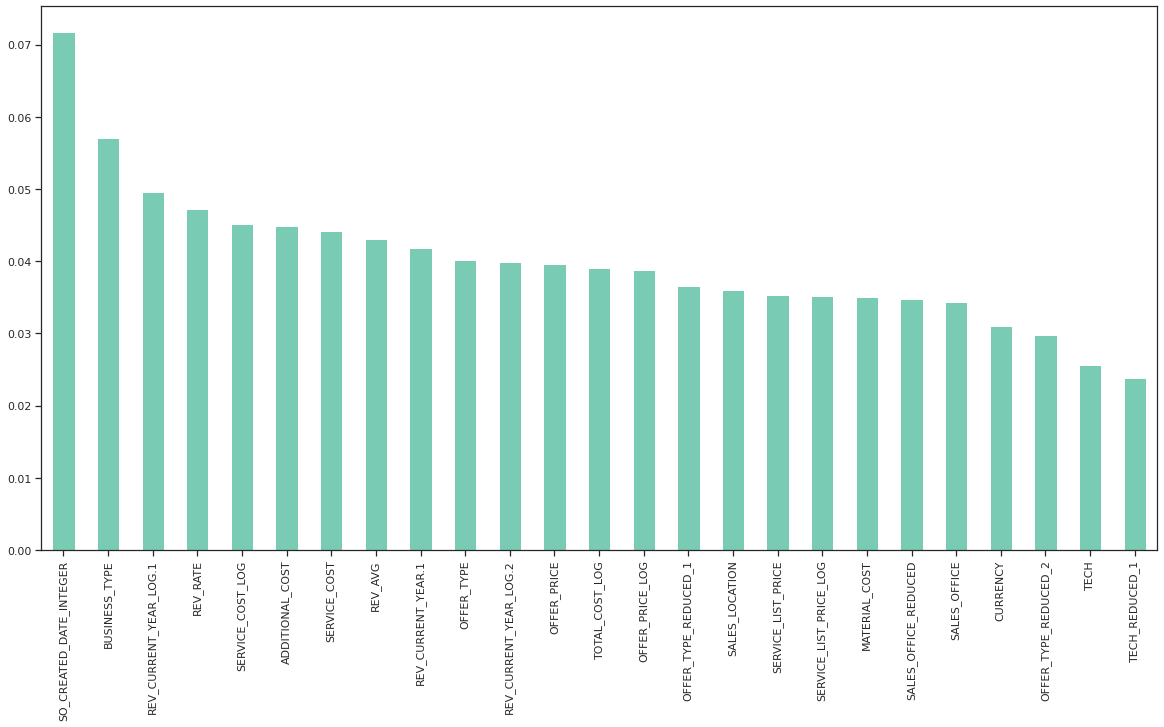

<IPython.core.display.Javascript object>

In [1005]:
rnd_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train_scaled, Y_train)

features = X_train_scaled.columns
importances = rnd_clf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(20, 10))
feat_importances = pd.Series(importances, index=features)
feat_importances.nlargest(len(indices)).plot(kind="bar", color="#79CCB3")

In [1011]:
resultt = apply_h2o(
    data=[X_train_scaled, X_test_scaled, Y_train, Y_test], max_runtime_secs=2 * 60
)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,14 hours 41 mins
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.2
H2O_cluster_version_age:,3 days
H2O_cluster_name:,H2O_from_python_iceking_yrpdtn
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.656 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
[INFO] Timestamp: 2022-01-29_16:07:34
[INFO] AML Leaderboard 

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_36_20220129_160736,0.796544,0.394315,0.930109,0.399715,0.349888,0.122421
StackedEnsemble_BestOfFamily_2_AutoML_36_20220129_160736,0.794524,0.395747,0.928928,0.377707,0.350461,0.122823
StackedEnsemble_BestOfFamily_1_AutoML_36_20220129_160736,0.793592,0.396432,0.929191,0.370225,0.351041,0.12323
GBM_1_AutoML_36_20220129_160736,0.792155,0.401603,0.928468,0.380546,0.353114,0.124689
GBM_2_AutoML_36_20220129_160736,0.790533,0.402425,0.92798,0.392821,0.35354,0.12499
GBM_3_AutoML_36_20220129_160736,0.784366,0.408667,0.924019,0.395786,0.356969,0.127427
GBM_4_AutoML_36_20220129_160736,0.784144,0.415725,0.924809,0.411669,0.358524,0.12854
DRF_1_AutoML_36_20220129_160736,0.777504,0.542146,0.920685,0.405061,0.369609,0.136611
XGBoost_3_AutoML_36_20220129_160736,0.776035,0.54954,0.922932,0.421154,0.428835,0.183899
XGBoost_2_AutoML_36_20220129_160736,0.769417,0.501547,0.918994,0.416495,0.405553,0.164473



stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
[INFO] Model #0, BAC=0.608001342918982.
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
[INFO] Model #1, BAC=0.6089076146370226.
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
[INFO] Model #2, BAC=0.6272273583368375.
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
[INFO] Model #3, BAC=0.7129885393028006.
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
[INFO] Model #4, BAC=0.7073582197710746.
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
[INFO] Model #5, BAC=0.7076619653004703.
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
[INFO] Model #6, BAC=0.7024381902410721.
drf prediction progress: |██████████████████████

In [1012]:
resultt

(<h2o.automl._estimator.H2OAutoML at 0x7fac2737c880>,
 [0.608001342918982,
  0.6089076146370226,
  0.6272273583368375,
  0.7129885393028006,
  0.7073582197710746,
  0.7076619653004703,
  0.7024381902410721,
  0.5811365350787935,
  0.6219416007932922,
  0.6635680650772183,
  0.6673042082552935,
  0.6833004449882458,
  0.5858001682620624,
  0.6095282234053595])

<IPython.core.display.Javascript object>

In [1006]:
use_auto_sklearn=False
if use_auto_sklearn:
    x_train_data = X_train_scaled.copy()
    x_test_data = X_test_scaled.copy()

    model2 = AutoSklearnClassifier(
        time_left_for_this_task=2 * 60,
        # time_left_for_this_task=60,
        seed=42,
        per_run_time_limit=30,
        n_jobs=-1,
        metric=autosklearn.metrics.balanced_accuracy,
        memory_limit=10 * 3072,
        # resampling_strategy="cv",
        # resampling_strategy_arguments={"cv": {"folds": 5}, "shuffle": True},
        # resampling_strategy_arguments={"cv": {"folds": 10}, "shuffle": True},
        # resampling_strategy_arguments={"train_size": 0.67, "shuffle": True},
    )

    start = time.time()
    model2.fit(x_train_data, Y_train)
    end = time.time()
    y_hat = model2.predict(x_test_data)
    # print(model2.sprint_statistics())
    # print(model2.best_val_acc)
    best_val_score_here = float(model2.sprint_statistics().split("\n")[3][25:])
    print(model2.get_models_with_weights())
    # model2.leaderboard()


    # Evaluate

    print("Elapsed Time:", end - start)
    # print("Dropped until:", col)
    print("Best Val Score:", best_val_score_here)
    val_acc = balanced_accuracy_score(y_true=Y_test, y_pred=y_hat)
    print("Final BAC Score: %.3f" % val_acc)

    # Pickle
    if not (("best_val_acc" in vars() or "best_val_acc" in globals())):
        best_val_acc = val_acc
    file_name = f"model_pickles/model_{int(val_acc*10**3)}" + str(
        datetime.datetime.now()
    ).replace(" ", "_")
    if val_acc >= best_val_acc:
        with open(file_name, "wb") as f:
            pickle.dump(model2, f)
    else:
        with open(file_name, "wb") as f:
            pickle.dump(model2, f)

[(0.4, SimpleClassificationPipeline({'balancing:strategy': 'weighting', 'classifier:__choice__': 'extra_trees', 'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'feature_agglomeration', 'classifier:extra_trees:bootstrap': 'False', 'classifier:extra_trees:criterion': 'gini', 'classifier:extra_trees:max_depth': 'None', 'classifier:extra_trees:max_features': 0.9127511083390432, 'classifier:extra_trees:max_leaf_nodes': 'None', 'classifier:extra_trees:min_impurity_decrease': 0.0, 'classifier:extra_trees:min_samples_leaf': 8, 'classifier:extra_trees:min_samples_split': 17, 'classifier:extra_trees:min_weight_fraction_leaf': 0.0, 'data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__': 'no_encoding', 'data_preprocessor:feature_type:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessor:feature

<IPython.core.display.Javascript object>

In [1007]:
## gggggg

<IPython.core.display.Javascript object>

In [1015]:
from sklearn.ensemble import RandomForestClassifier

X_for_boruta = pd.concat([X_train_scaled, X_test_scaled]).copy()
Y_for_boruta = pd.concat([Y_train, Y_test]).copy()
# define random forest classifier
forest = RandomForestClassifier(n_jobs=-1, class_weight="balanced")
forest.fit(X_for_boruta, Y_for_boruta)


from boruta import BorutaPy

# define Boruta feature selection method
feat_selector = BorutaPy(
    forest,
    n_estimators="auto",
    verbose=2,
    random_state=42,
)


feat_selector.fit(
    X_for_boruta.to_numpy(), Y_for_boruta.to_numpy()
)  # find all relevant features
print(feat_selector.support_)  # check selected features
print(feat_selector.ranking_)  # check ranking of features
# check selected features
a = list(
    zip(
        list(feat_selector.ranking_),
        list(feat_selector.support_),
        list(X_for_boruta.columns),
    )
)

[", # ".join(map(str, [f'{x[2]}", # ', x[0], x[1]])) for x in sorted(a)]

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	25
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	13
Tentative: 	4
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	4
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	13
Tentative: 	4
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	13
Tentative: 	4
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	13
Tentative: 	4
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	13
Tentative: 	4
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	13
Tentative: 	4
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	13
Tentative: 	4
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	13
Tentative: 	4
Rejected: 	8
I

['ADDITIONAL_COST", # , # 1, # True',
 'BUSINESS_TYPE", # , # 1, # True',
 'OFFER_TYPE", # , # 1, # True',
 'OFFER_TYPE_REDUCED_1", # , # 1, # True',
 'OFFER_TYPE_REDUCED_2", # , # 1, # True',
 'REV_CURRENT_YEAR.1", # , # 1, # True',
 'REV_CURRENT_YEAR_LOG.1", # , # 1, # True',
 'REV_RATE", # , # 1, # True',
 'SALES_LOCATION", # , # 1, # True',
 'SALES_OFFICE", # , # 1, # True',
 'SALES_OFFICE_REDUCED", # , # 1, # True',
 'SERVICE_COST", # , # 1, # True',
 'SERVICE_COST_LOG", # , # 1, # True',
 'SO_CREATED_DATE_INTEGER", # , # 1, # True',
 'REV_AVG", # , # 2, # False',
 'REV_CURRENT_YEAR_LOG.2", # , # 3, # False',
 'TECH", # , # 4, # False',
 'TOTAL_COST_LOG", # , # 5, # False',
 'OFFER_PRICE", # , # 6, # False',
 'OFFER_PRICE_LOG", # , # 7, # False',
 'SERVICE_LIST_PRICE", # , # 9, # False',
 'SERVICE_LIST_PRICE_LOG", # , # 9, # False',
 'TECH_REDUCED_1", # , # 9, # False',
 'MATERIAL_COST", # , # 11, # False',
 'CURRENCY", # , # 12, # False']

<IPython.core.display.Javascript object>

In [1009]:
Best Val Score: 0.70742
Final BAC Score: 0.713

SyntaxError: invalid syntax (3393114541.py, line 1)

<IPython.core.display.Javascript object>

### real predictt

In [ ]:
def test_h2o(X_test,models_dir_path):
    from h2o.automl import H2OAutoML
    import h2o
    
    if not os.path.exists(models_dir_path):
        os.makedirs(models_dir_path)
        
    train_path =f"{results_dir_path}/train.csv"
    test_path =f"{results_dir_path}/test.csv"

    pd.concat([X_train, Y_train], axis=1).to_csv("/tmp", index=False, header=True)
    pd.concat([X_test, Y_test], axis=1).to_csv(test_path, index=False, header=True)

    train = h2o.import_file(train_path)
    test = h2o.import_file(test_path)

    h2o.init(max_mem_size="36G")

    x = train.columns
    train["OFFER_STATUS"] = train["OFFER_STATUS"].asfactor()
    x.remove("OFFER_STATUS")
    aml = H2OAutoML(
        max_models=max_models,
        balance_classes=balance_classes,
        max_runtime_secs=int(max_runtime_secs),
        seed=42,
    )
    aml.train(x=x, y="OFFER_STATUS", training_frame=train)
    
    print("[INFO] Timestamp:",timestamp)
    print('[INFO] AML Leaderboard',aml.leaderboard)
    
    model_bac_scores = []
    for i in range(int(aml.max_models * 1.5)):
        current_model = aml.leaderboard[i, 0]
        if current_model == "NA":
            print(f"[INFO] Found {i} models in total.")
            break
        current_model = h2o.get_model(current_model)
        new_pred = current_model.predict(test)
        new_pred = new_pred[0].as_data_frame().values.flatten()
        model_bac_score = balanced_accuracy_score(Y_test, new_pred)
        print(f'[INFO] Model #{i}, BAC={model_bac_score}.')
        model_bac_scores.append(model_bac_score)
    
    index_max_bac_score = model_bac_scores.index(max(model_bac_scores))
    
    
    
    saved_model_path=f'{results_dir_path}/model_{"bac_%.3f" % model_bac_scores[index_max_bac_score]}'
    h2o.save_model(model=h2o.get_model(aml.leaderboard[index_max_bac_score, 0]), 
                   path=saved_model_path, force=True)
    
    print("[INFO] RESULTS:")
    print(f' > Train data saved to:"{train_path}".')
    print(f' > Test data saved to :"{test_path}".')
    print(f' > H20 Model saved to :"{saved_model_path}".')

    return aml, model_bac_scores

In [1019]:
# test_h2o(models_dir_path='h2o_models_with_data/results_ts_2022-01-29_13:09:41/model_bac_0.734')
models_dir_path = "h2o_models_with_data/results_ts_2022-01-29_13:09:41/model_bac_0.734/GBM_1_AutoML_31_20220129_130944"

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1072]:
def aa():
    my_model = h2o.load_model(models_dir_path)
    df = pd.read_csv("interim_data/df_completed_1_2_3_with_mv_new.csv")

    ppppp = df_for_unlabeled_set.drop(["OFFER_STATUS", "CUSTOMER"], axis=1)
    x_realll = h2o.H2OFrame(ppppp)

    ggl = my_model.predict(x_realll)
    gg = ggl[0].as_data_frame().values.flatten()
    
    real_test = ppppp
    real_test['prediction'] =gg
    test_set_id_col = df[np.isnan(df["OFFER_STATUS"])]["TEST_SET_ID"]
    real_test = pd.concat([real_test["prediction"], test_set_id_col], axis=1)
    real_test = real_test.rename(columns={"TEST_SET_ID": "id"})
    
    real_test["prediction"] = real_test["prediction"].astype(int)
    real_test["id"] = real_test["id"].astype(int)
    print(ggl)
    
    
    return real_test


lllresult = aa()

print(lllresult)
print(lllresult.prediction.value_counts())

lllresult.to_csv("predictions_versed_chimpanzee_5.csv", header=True, index=False)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict,p0,p1
0,0.207541,0.792459
0,0.228596,0.771404
0,0.285075,0.714925
0,0.283514,0.716486
0,0.450318,0.549682
0,0.241144,0.758856
0,0.262926,0.737074
0,0.538225,0.461775
0,0.223898,0.776102
1,0.15567,0.84433



       prediction     id
5               0      6
8               0      9
13              0     14
34              0     35
35              0     36
...           ...    ...
26018           1  26019
26032           0  26033
26049           1  26050
26057           1  26058
26085           0  26086

[2576 rows x 2 columns]
1    1732
0     844
Name: prediction, dtype: int64


<IPython.core.display.Javascript object>

In [1070]:
lllresult.as_data_frame().head(30)

,predict,p0,p1
0,0,0.207541,0.792459
1,0,0.228596,0.771404
2,0,0.285075,0.714925
3,0,0.283514,0.716486
4,0,0.450318,0.549682
5,0,0.241144,0.758856
6,0,0.262926,0.737074
7,0,0.538225,0.461775
8,0,0.223898,0.776102
9,1,0.155670,0.844330


<IPython.core.display.Javascript object>

In [1050]:
pd.Series(ggggggggggggg).value_counts()

1    1732
0     844
dtype: int64

<IPython.core.display.Javascript object>

In [ ]:
    df_tmp = pd.read_csv("interim_data/df_completed_1_2_3_with_mv_new.csv")
    test_set_id_col = df_tmp[np.isnan(df_tmp["OFFER_STATUS"])]["TEST_SET_ID"]

    ## Predict BREAK - start
    real_test = x_test_data
    real_test["prediction"] = model2.predict(real_test)
    real_test = pd.concat([real_test["prediction"], test_set_id_col], axis=1)
    real_test = real_test.rename(columns={"TEST_SET_ID": "id"})
    real_test["prediction"] = real_test["prediction"].astype(int)
    real_test["id"] = real_test["id"].astype(int)

    ## Predict BREAK - stop

    #real_test.to_csv("predictions_versed_chimpanzee_5.csv", header=True, index=False)
    print(real_test[["prediction"]].value_counts())